<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import user defined python functions. Used importlib as having stability issues with simple import and not picking up the files
spec = importlib.util.spec_from_file_location("create_model_results", "/content/drive/MyDrive/birkbeck_msc-project/python_files/create_model_results.py")
create_model_results = importlib.util.module_from_spec(spec)
spec.loader.exec_module(create_model_results)


In [ ]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Feature Data for FA Cup games with last 2 seasons held back for final testing of best models

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe().drop(columns=['season_year', 'match_id', 'match_name','match_final_score'])
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)

test_flag = 'Cross-Validation'


arena_stadium_capacity  home_team_league_level  home_win  \
0                     41837                       1         1   
1                     41837                       1         1   
2                     41837                       1         1   
3                     74879                       1         1   
4                     74879                       1         0   
..                      ...                     ...       ...   
300                    <NA>                       6         0   
301                    <NA>                       6         0   
302                    9527                       4         1   
303                    6064                       6         0   
304                    4100                       6         1   

     home_team_round_3_position  home_team_massey  home_team_colley  \
0                             1                 1                 1   
1                             1                 1                 1   
2                             1                 1                 1   
3                             1                 1                 1   
4                             2                 4                 7   
..                          ...               ...               ...   
300                          64                58                64   
301                          64                58                64   
302                          64                58                64   
303                          64                58                64   
304                          64                58                64   

     home_team_keener  home_team_trueskill  home_team_borda_count  \
0                  12                    1                      3   
1                  12                    1                      3   
2                  12                    1                      3   
3                  12                    1                      3   
4                   4                    6                      4   
..                ...                  ...                    ...   
300                57                   63                     64   
301                57                   63                     64   
302                57                   63                     64   
303                57                   63                     64   
304                57                   63                     64   

     home_team_local_kemeny_optimisation  ...  match_weather_data_hours_dew  \
0                                      2  ...                           NaN   
1                                      2  ...                         34.70   
2                                      2  ...                         47.00   
3                                      2  ...                         71.20   
4                                      4  ...                           NaN   
..                                   ...  ...                           ...   
300                                   64  ...                           NaN   
301                                   64  ...                           NaN   
302                                   64  ...                         37.15   
303                                   64  ...                         41.45   
304                                   64  ...                         32.75   

     match_weather_data_hours_precip  match_weather_data_hours_snow  \
0                                NaN                            NaN   
1                              0.000                            0.0   
2                              0.000                            0.0   
3                              0.000                            NaN   
4                                NaN                            NaN   
..                               ...                            ...   
300                              NaN                            NaN   
301                      

Empty DataFrame
Columns: [metric_id, metric]
Index: []

In [ ]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [ ]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [ ]:
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []


  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-testidation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      train_accuracies = []
      train_recalls = []
      test_accuracies = []
      test_recalls = []
      all_y_train_true = []
      all_y_train_pred = []
      all_y_train_pred_proba = []  # Store probabilities for ROC
      all_y_test_true = []
      all_y_test_pred = []
      all_y_test_pred_proba = []  # Store probabilities for ROC

      # Perform cross-testidation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
          X_train, X_test = X.iloc[train_index], X.iloc[test_index]
          y_train, y_test = y.iloc[train_index], y.iloc[test_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_test, _ = add_home_advantage(X_test)
              numeric_features = [home_advantage_column] + numeric_features

          # Drop home win and league level feature so not used in modelling as impact predictability be proviing the winner
          columns_to_drop = ['home_win', 'home_team_league_level', 'away_team_league_level']
          X_train = X_train.drop(columns_to_drop, axis=1)
          X_test = X_test.drop(columns_to_drop, axis=1)
          numeric_features = [feat for feat in numeric_features if feat not in columns_to_drop]
          print(f'numeric features {numeric_features}')

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)
              print(f"Weights being used: {weights}")

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Calculate train metrics
          y_train_pred = best_model.predict(X_train)
          y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

          train_accuracy = accuracy_score(y_train, y_train_pred)
          train_recall = recall_score(y_train, y_train_pred)

          train_accuracies.append(train_accuracy)
          train_recalls.append(train_recall)

          # Calculate test metrics
          y_test_pred = best_model.predict(X_test)
          y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

          test_accuracy = accuracy_score(y_test, y_test_pred)
          test_recall = recall_score(y_test, y_test_pred)

          test_accuracies.append(test_accuracy)
          test_recalls.append(test_recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Train Accuracy': train_accuracy,
              'Train Recall': train_recall,
              'Test Accuracy': test_accuracy,
              'Test Recall': test_recall,
          })

          # Store true and predicted testues for later analysis
          all_y_train_true.extend(y_train)
          all_y_train_pred.extend(y_train_pred)
          all_y_train_pred_proba.extend(y_train_pred_proba)
          all_y_test_true.extend(y_test)
          all_y_test_pred.extend(y_test_pred)
          all_y_test_pred_proba.extend(y_test_pred_proba)

          print(f"Fold {fold} Train Accuracy: {train_accuracy:.3f}, test Accuracy: {test_accuracy:.3f}")
          print(f"Fold {fold} Train Recall: {train_recall:.3f}, test Recall: {test_recall:.3f}")

      # Calculate average fold accuracies
      avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
      print(f"Average Train Accuracy: {avg_train_accuracy:.3f}")
      avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)
      print(f"Average Test Accuracy: {avg_test_accuracy:.3f}")

      # Calculate average recall
      avg_train_recall = sum(train_recalls) / len(train_recalls)
      print(f"Average Train Recall: {avg_train_recall:.3f}")
      avg_test_recall = sum(test_recalls) / len(test_recalls)
      print(f"Average Test Recall: {avg_test_recall:.3f}")

      # Calculate overall log loss
      train_log_loss = log_loss(all_y_train_true, all_y_train_pred_proba)
      test_log_loss = log_loss(all_y_test_true, all_y_test_pred_proba)
      print(f"Overall Train Log Loss: {train_log_loss:.3f}, Test Log Loss: {test_log_loss:.3f}")

      # Create and display results using existing function
      #results_df, cm_fig, roc_fig = create_model_results_df(all_y_test_true, all_y_test_pred, fold_test_accuracies, fold_test_recalls,  all_y_test_pred_proba, model_name_ranking)
      results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)

      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

Standard LogisticRegression no_ranking
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.227
Fold 1 Train Accuracy: 0.779, test Accuracy: 0.721
Fold 1 Train Recall: 0.318, test Recall: 0.188
numeric features ['are

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   Standard LogisticRegression no_ranking  \
0                                   0.770   
1                                   0.009   
2                                   0.682   
3                                   0.034   
4                                   0.302   
5                                   0.028   
6                                   0.173   
7                                   0.075   
8                                   0.469   
9                                   0.751   
10                                  0.682   
11                                194.000   
12                                 29.000   
13                                 68.000   
14                                 14.000   
15                                  0.740   
16                                  0.870   
17                                  0.800   
18                                  0.326   
19                                  0.171   
20                                  0.224   
21                                  0.533   
22                                  0.520   
23                                  0.512   
24                                  0.629   
25                                  0.682   
26                                  0.645   
27                                  0.548   

   Standard LogisticRegression round_3_position  \
0                                         0.776   
1                                         0.010   
2                                         0.682   
3                                         0.020   
4                                         0.317   
5                                         0.025   
6                                         0.160   
7                                         0.034   
8                                         0.471   
9                                         0.664   
10                                        0.682   
11                                      195.000   
12                                       28.000   
13                                      

Model Name Ranking  Fold  \
0              Standard LogisticRegression no_ranking     1   
1              Standard LogisticRegression no_ranking     2   
2              Standard LogisticRegression no_ranking     3   
3              Standard LogisticRegression no_ranking     4   
4              Standard LogisticRegression no_ranking     5   
5        Standard LogisticRegression round_3_position     1   
6        Standard LogisticRegression round_3_position     2   
7        Standard LogisticRegression round_3_position     3   
8        Standard LogisticRegression round_3_position     4   
9        Standard LogisticRegression round_3_position     5   
10                 Standard LogisticRegression massey     1   
11                 Standard LogisticRegression massey     2   
12                 Standard LogisticRegression massey     3   
13                 Standard LogisticRegression massey     4   
14                 Standard LogisticRegression massey     5   
15                 Standard LogisticRegression colley     1   
16                 Standard LogisticRegression colley     2   
17                 Standard LogisticRegression colley     3   
18                 Standard LogisticRegression colley     4   
19                 Standard LogisticRegression colley     5   
20                 Standard LogisticRegression keener     1   
21                 Standard LogisticRegression keener     2   
22                 Standard LogisticRegression keener     3   
23                 Standard LogisticRegression keener     4   
24                 Standard LogisticRegression keener     5   
25              Standard LogisticRegression trueskill     1   
26              Standard LogisticRegression trueskill     2   
27              Standard LogisticRegression trueskill     3   
28              Standard LogisticRegression trueskill     4   
29              Standard LogisticRegression trueskill     5   
30            Standard LogisticRegression borda_count     1   
31            Standard LogisticRegression borda_count     2   
32            Standard LogisticRegression borda_count     3   
33            Standard LogisticRegression borda_count     4   
34            Standard LogisticRegression borda_count     5   
35  Standard LogisticRegression local_kemeny_optim...     1   
36  Standard LogisticRegression local_kemeny_optim...     2   
37  Standard LogisticRegression local_kemeny_optim...     3   
38  Standard LogisticRegression local_kemeny_optim...     4   
39  Standard LogisticRegression local_kemeny_optim...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 100.0, 'classifier__penalty'...   
1   {'classifier__C': 1000.0, 'classifier__penalty...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 1000.0, 'classifier__penalty...   
5   {'classifier__C': 10.0, 'classifier__penalty':...   
6   {'classifier__C': 10.0, 'classifier__penalty':...   
7   {'classifier__C': 10.0, 'classifier__penalty':...   
8   {'classifier__C': 10.0, 'classifier__penalty':...   
9   {'classifier__C': 1000.0, 'classifier__penalty...   
10  {'classifier__C': 10.0, 'classifier__penalty':...   
11  {'classifier__C': 100.0, 'classifier__penalty'...   
12  {'classifier__C': 100.0, 'classifier__penalty'...   
13  {'classifier__C': 100.0, 'classifier__penalty'...   
14  {'classifier__C': 1000.0, 'classifier__penalty...   
15  {'classifier__C': 100.0, 'classifier__penalty'...   
16  {'classifier__C': 100.0, 'classifier__penalty'...   
17  {'classifier__C': 100.0, 'classifier__penalty'...   
18  {'classifier__C': 100.0, 'classifier__penalty'...   
19  {'classifier__C': 1000.0, 'classifier__penalty...   
20  {'classifier__C': 1000.0, 'classifier__penalty...   
21  {'classifier__C': 100.0, 'classifier__penalty'...   
22  {'classifier__C': 10.0, 'classifier__penalty':...   
23  {'classifier__C': 100.0, 'classifier__penalty'...   
24  {'classifier__C': 1000

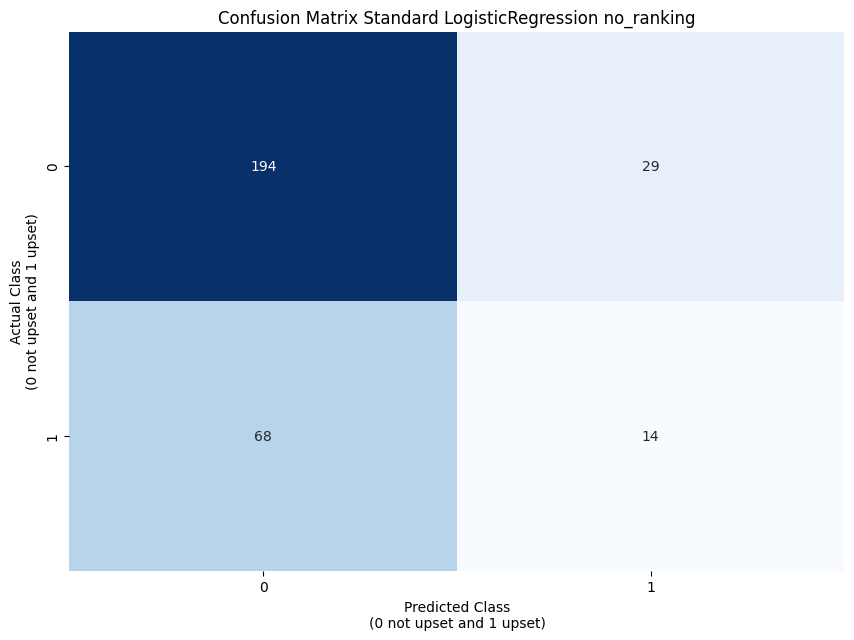

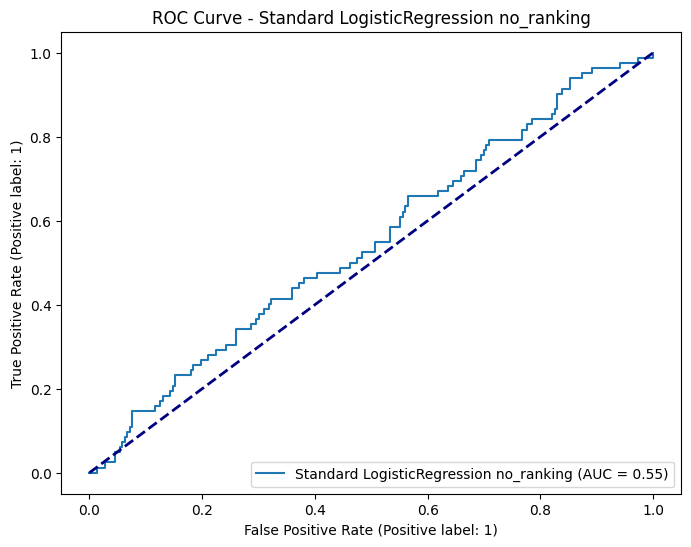

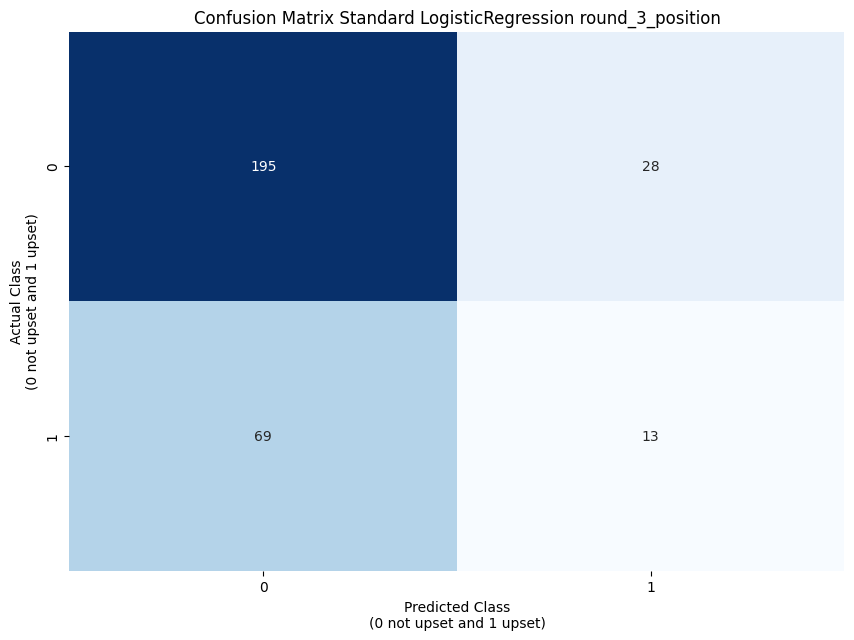

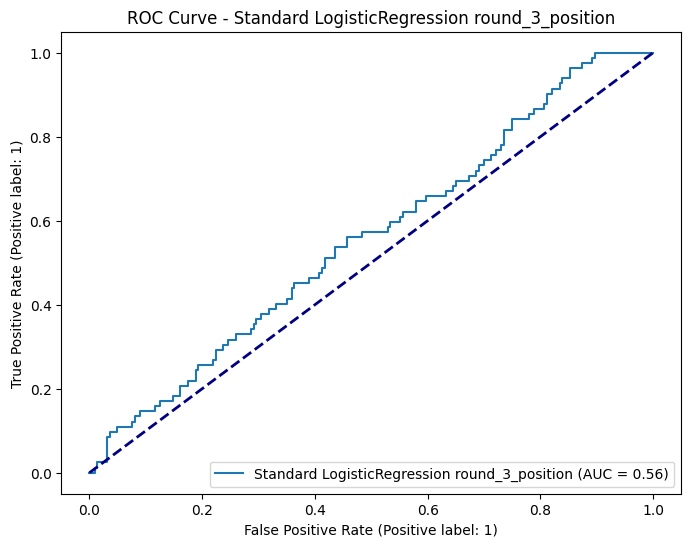

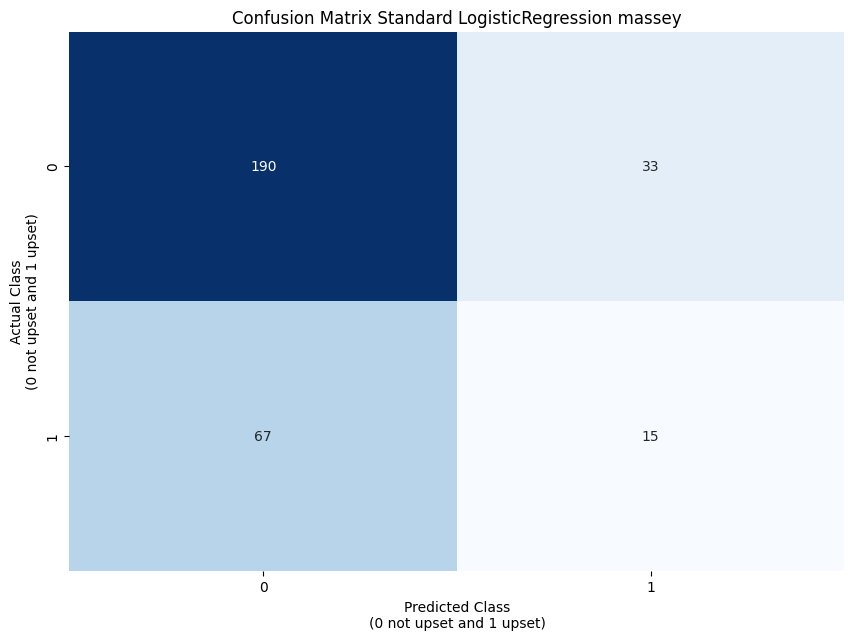

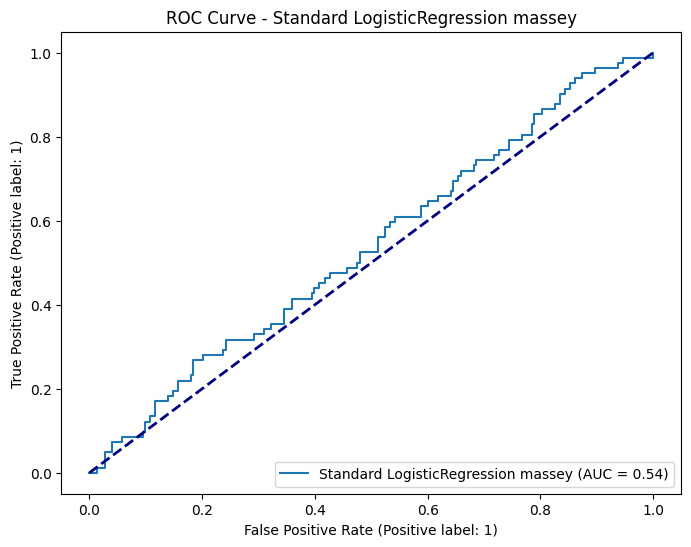

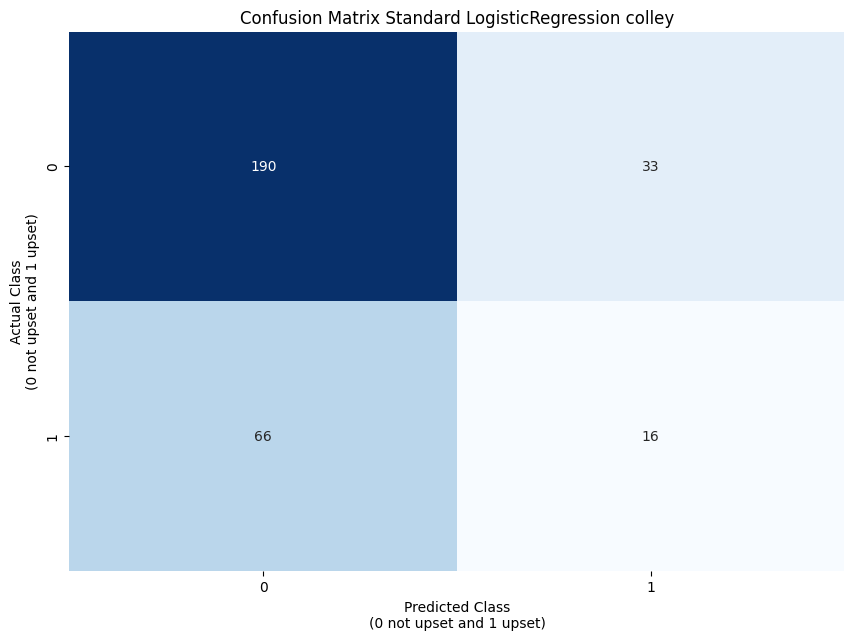

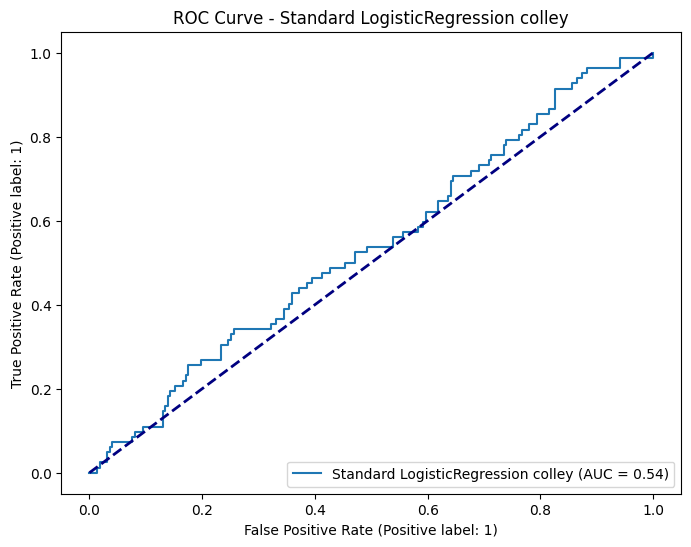

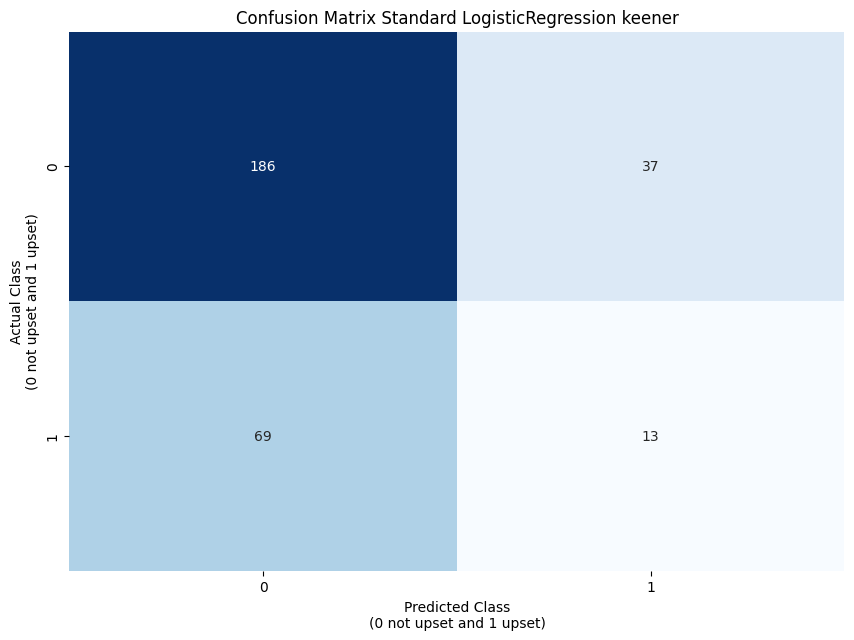

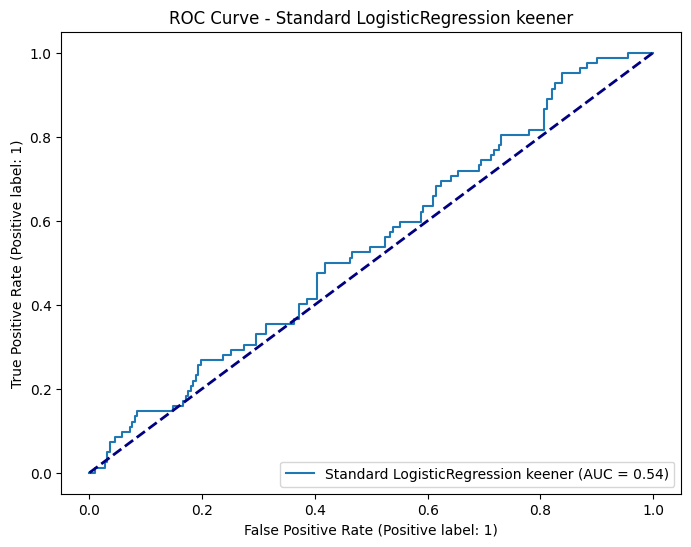

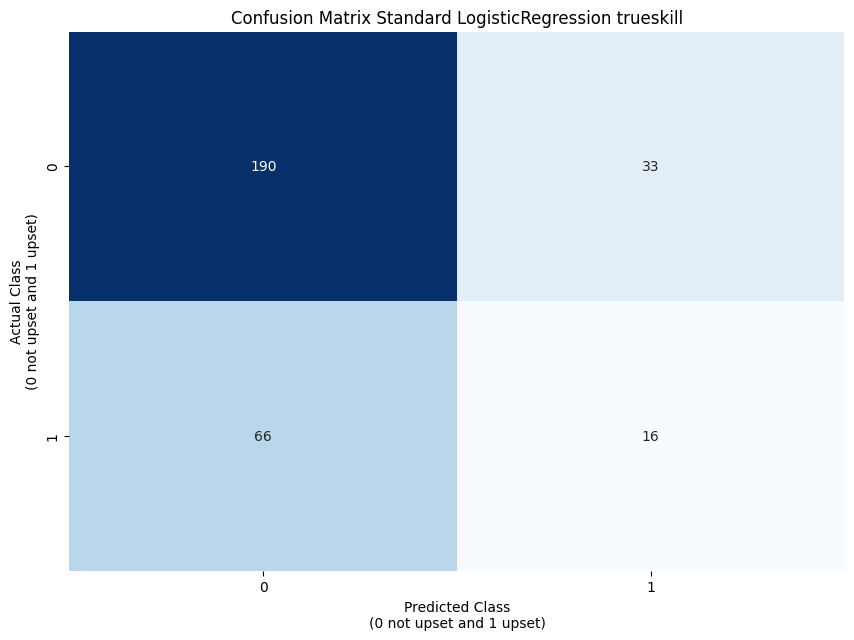

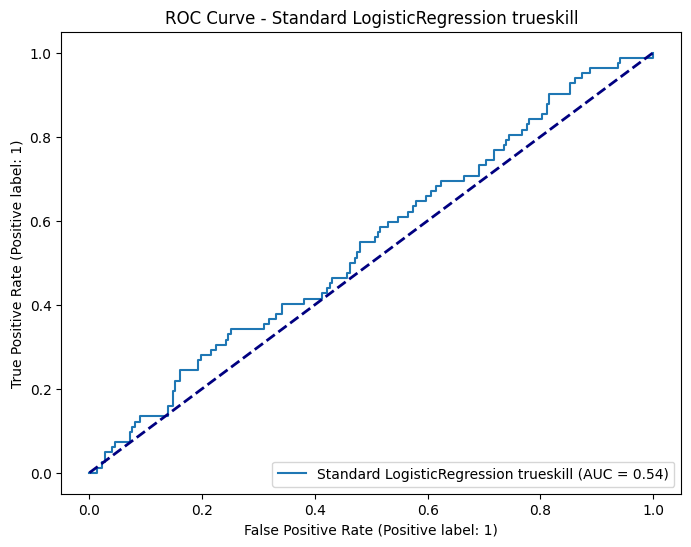

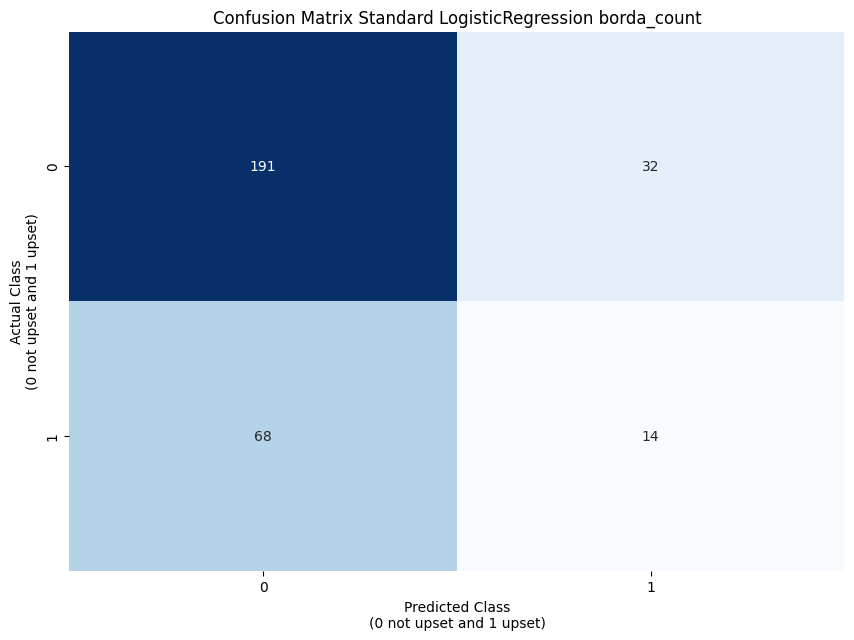

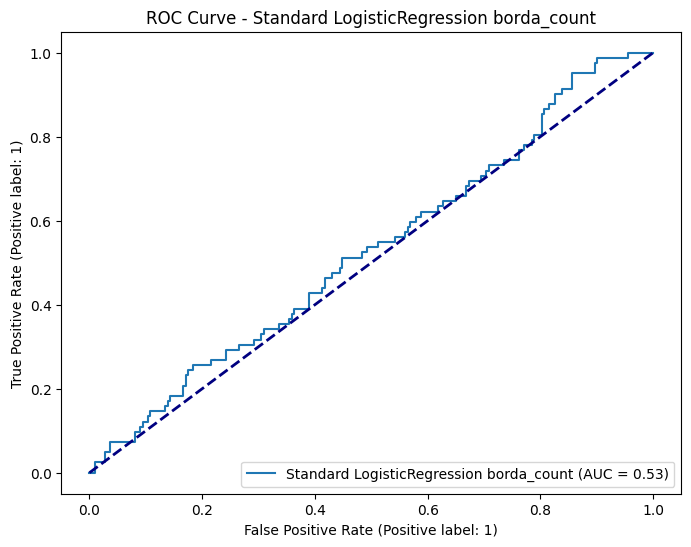

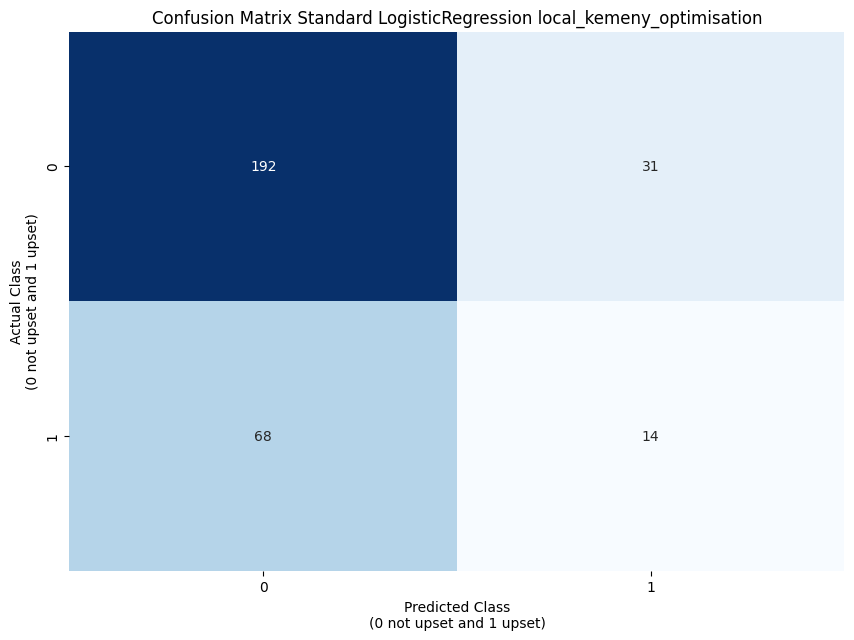

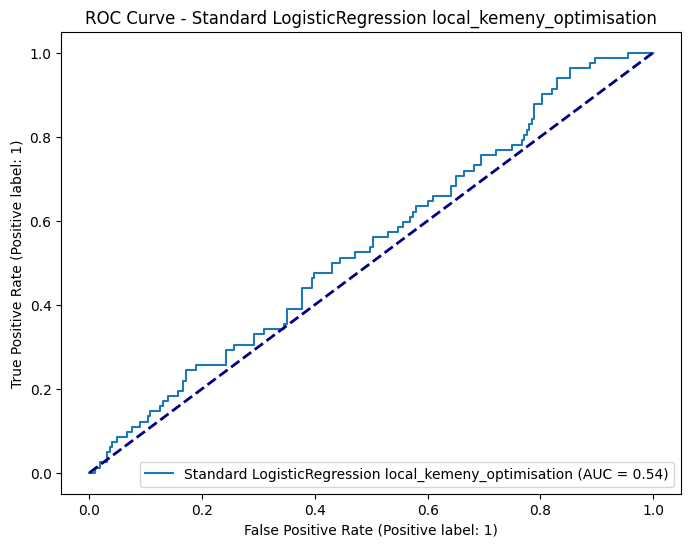

In [ ]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")
fold_results_df_slr.to_excel("fold_results_slr.xlsx")



Standard LogisticRegression with home advantage no_ranking
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.227
Fold 1 Train Accuracy: 0.791, test Accuracy: 0.689
Fold 1 Train Recall: 0.348, te

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   Standard LogisticRegression with home advantage no_ranking  \
0                                               0.772           
1                                               0.012           
2                                               0.662           
3                                               0.030           
4                                               0.308           
5                                               0.030           
6                                               0.148           
7                                               0.065           
8                                               0.468           
9                                               0.744           
10                                              0.662           
11                                            190.000           
12                                             33.000           
13                                             70.000           
14                                             12.000           
15                                              0.731           
16                                              0.852           
17                                              0.787           
18                                              0.267           
19                                              0.146           
20                                              0.189           
21                                              0.499           
22                                              0.499           
23                                              0.488           
24                                              0.606           
25                                              0.662           
26                                              0.626           
27                                              0.535           

   Standard LogisticRegression with home advantage round_3_position  \
0                                               0.767                 
1                               

Model Name Ranking  Fold  \
0   Standard LogisticRegression with home advantag...     1   
1   Standard LogisticRegression with home advantag...     2   
2   Standard LogisticRegression with home advantag...     3   
3   Standard LogisticRegression with home advantag...     4   
4   Standard LogisticRegression with home advantag...     5   
5   Standard LogisticRegression with home advantag...     1   
6   Standard LogisticRegression with home advantag...     2   
7   Standard LogisticRegression with home advantag...     3   
8   Standard LogisticRegression with home advantag...     4   
9   Standard LogisticRegression with home advantag...     5   
10  Standard LogisticRegression with home advantag...     1   
11  Standard LogisticRegression with home advantag...     2   
12  Standard LogisticRegression with home advantag...     3   
13  Standard LogisticRegression with home advantag...     4   
14  Standard LogisticRegression with home advantag...     5   
15  Standard LogisticRegression with home advantag...     1   
16  Standard LogisticRegression with home advantag...     2   
17  Standard LogisticRegression with home advantag...     3   
18  Standard LogisticRegression with home advantag...     4   
19  Standard LogisticRegression with home advantag...     5   
20  Standard LogisticRegression with home advantag...     1   
21  Standard LogisticRegression with home advantag...     2   
22  Standard LogisticRegression with home advantag...     3   
23  Standard LogisticRegression with home advantag...     4   
24  Standard LogisticRegression with home advantag...     5   
25  Standard LogisticRegression with home advantag...     1   
26  Standard LogisticRegression with home advantag...     2   
27  Standard LogisticRegression with home advantag...     3   
28  Standard LogisticRegression with home advantag...     4   
29  Standard LogisticRegression with home advantag...     5   
30  Standard LogisticRegression with home advantag...     1   
31  Standard LogisticRegression with home advantag...     2   
32  Standard LogisticRegression with home advantag...     3   
33  Standard LogisticRegression with home advantag...     4   
34  Standard LogisticRegression with home advantag...     5   
35  Standard LogisticRegression with home advantag...     1   
36  Standard LogisticRegression with home advantag...     2   
37  Standard LogisticRegression with home advantag...     3   
38  Standard LogisticRegression with home advantag...     4   
39  Standard LogisticRegression with home advantag...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 100.0, 'classifier__penalty'...   
1   {'classifier__C': 100.0, 'classifier__penalty'...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 100.0, 'classifier__penalty'...   
5   {'classifier__C': 10.0, 'classifier__penalty':...   
6   {'classifier__C': 1.0, 'classifier__penalty': ...   
7   {'classifier__C': 10.0, 'classifier__penalty':...   
8   {'classifier__C': 100.0, 'classifier__penalty'...   
9   {'classifier__C': 1000.0, 'classifier__penalty...   
10  {'classifier__C': 10.0, 'classifier__penalty':...   
11  {'classifier__C': 100.0, 'classifier__penalty'...   
12  {'classifier__C': 100.0, 'classifier__penalty'...   
13  {'classifier__C': 1000.0, 'classifier__penalty...   
14  {'classifier__C': 100.0, 'classifier__penalty'...   
15  {'classifier__C': 100.0, 'classifier__penalty'...   
16  {'classifier__C': 100.0, 'classifier__penalty'...   
17  {'classifier__C': 10.0, 'classifier__penalty':...   
18  {'classifier__C': 100.0, 'classifier__penalty'...   
19  {'classifier__C': 100.0, 'classifier__penalty'...   
20  {'classifier__C': 1000.0, 'classifier__penalty...   
21  {'classifier__C': 100.0, 'classifier__penalty'...   
22  {'classifier__C': 10.0, 'classifier__penalty':...   
23  {'classifier__C': 10.0, 'classifier__penalty':...   
24  {'classifier__C': 1000

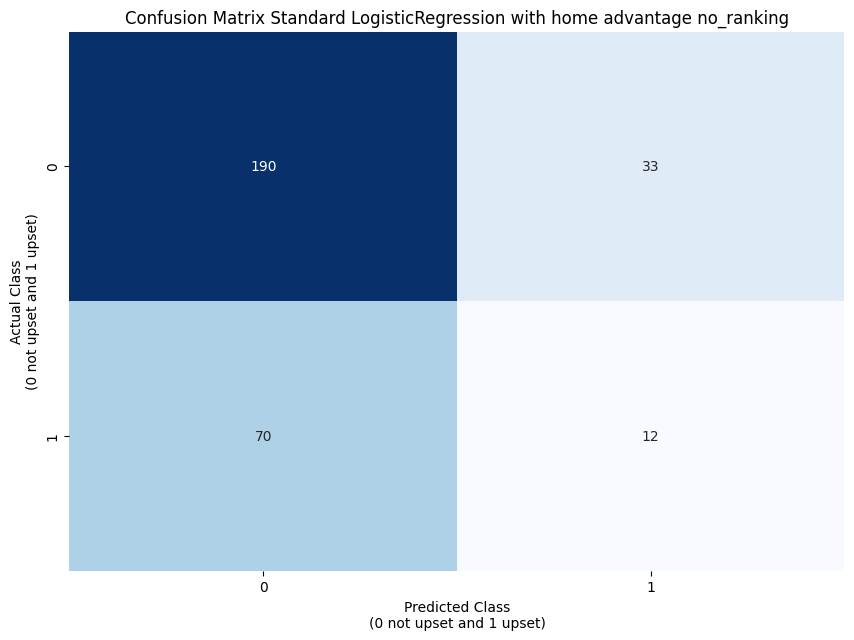

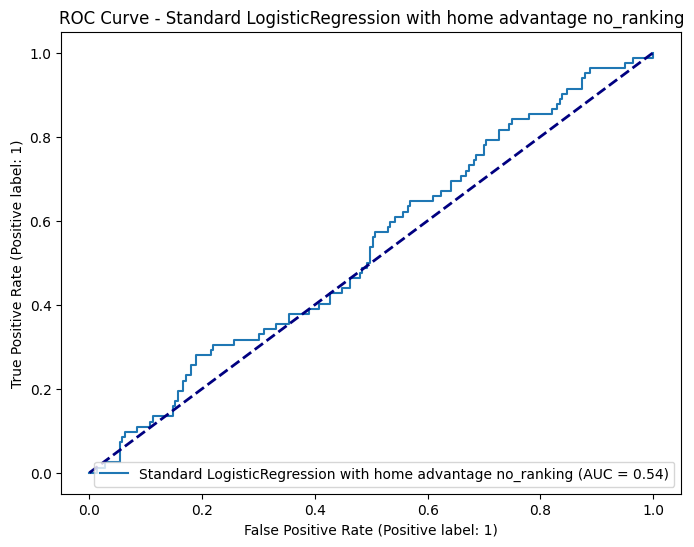

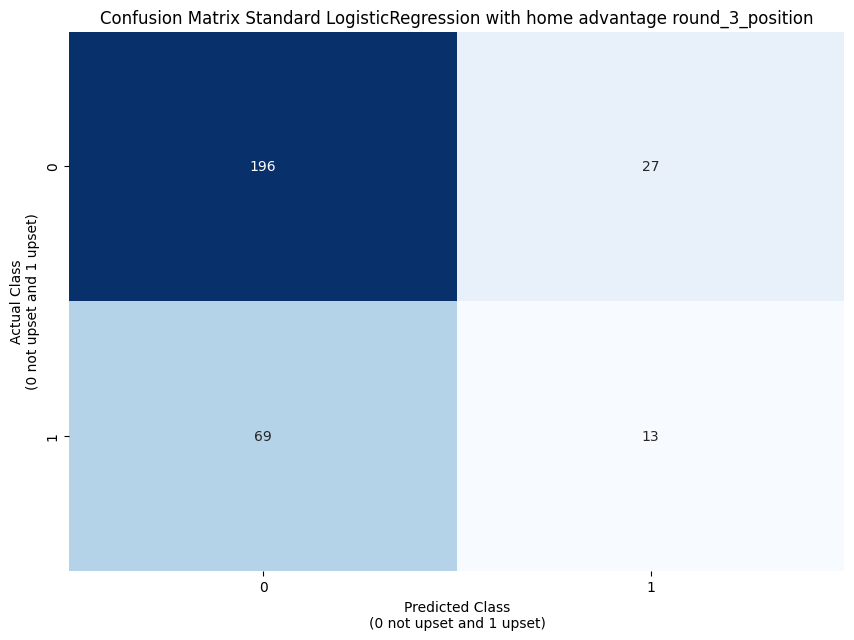

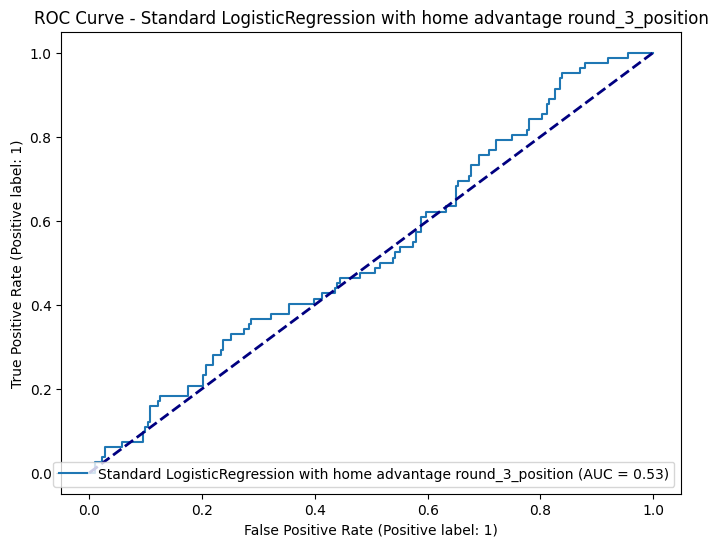

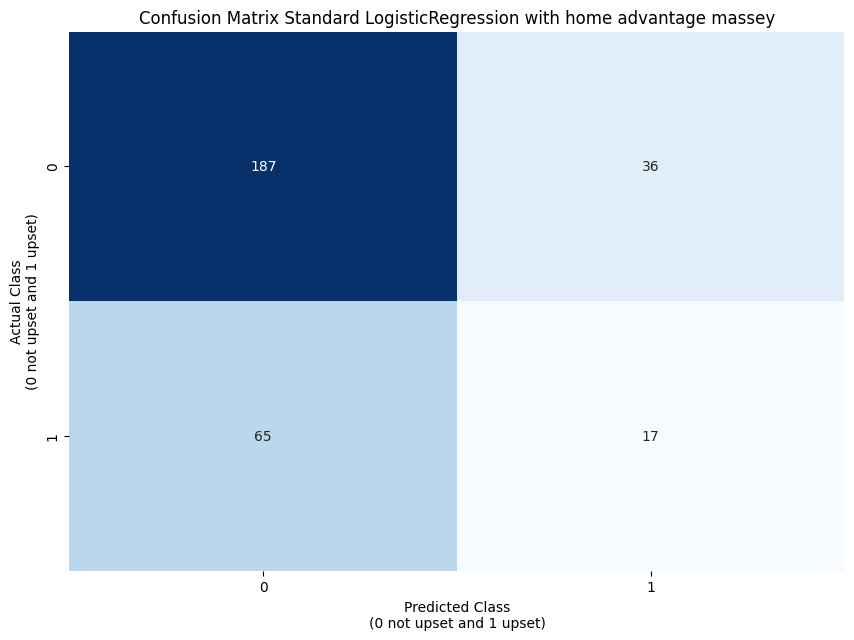

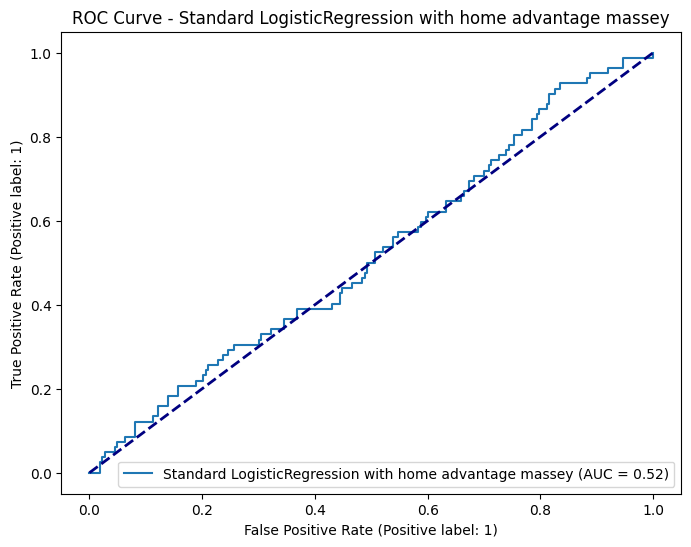

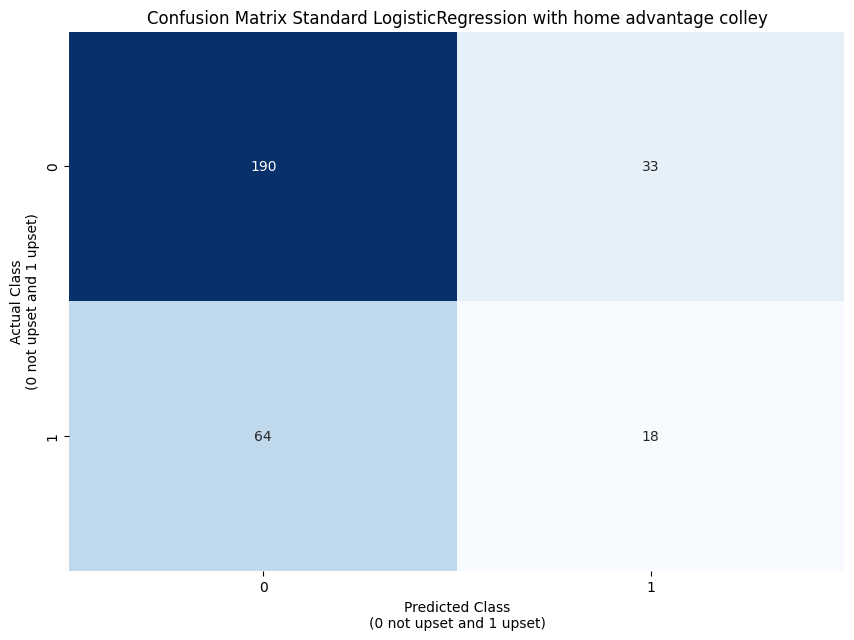

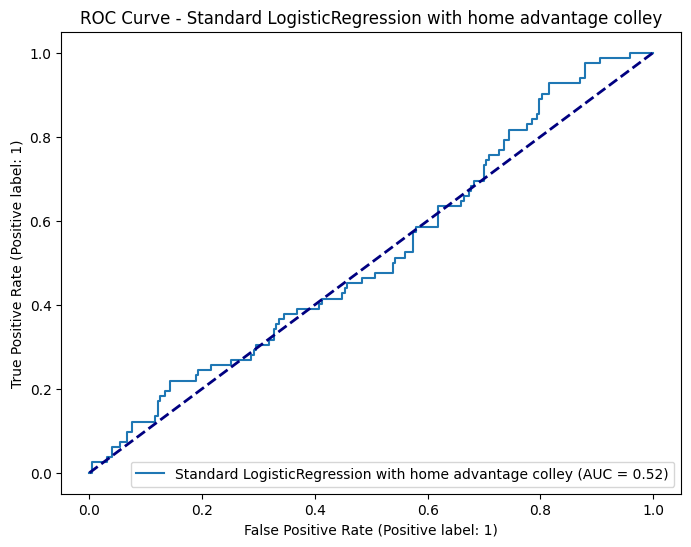

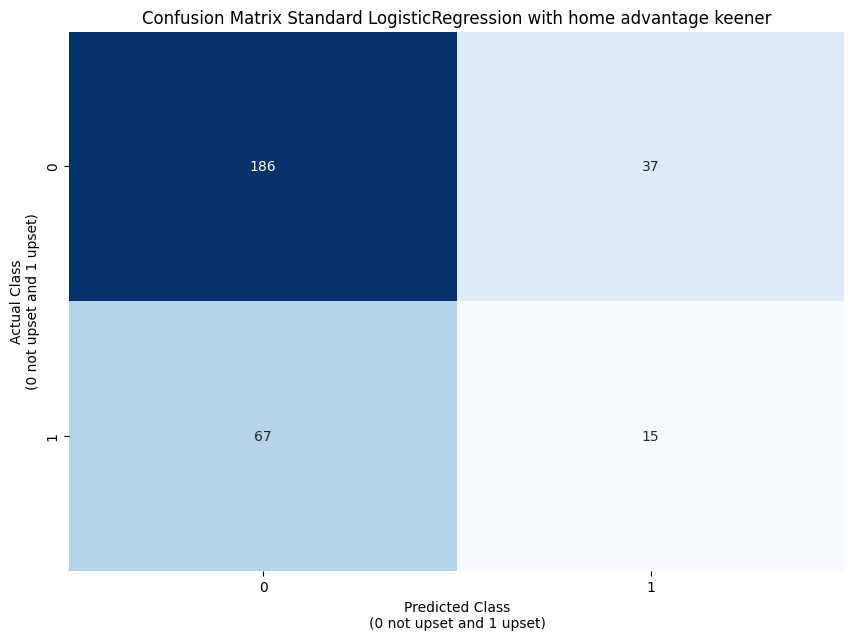

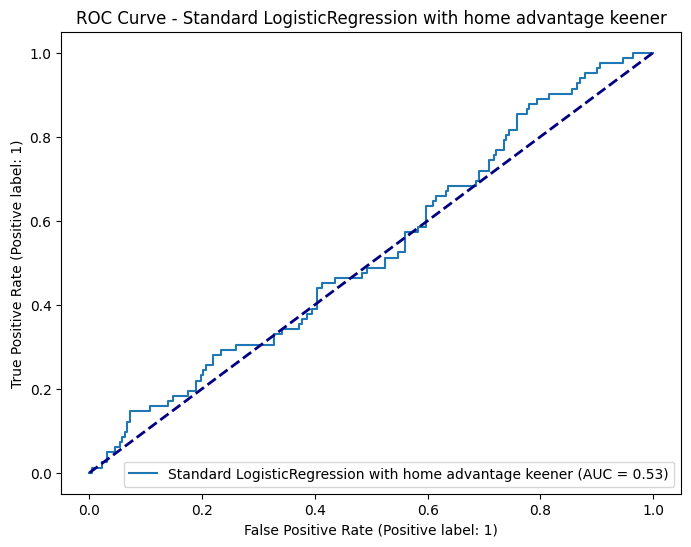

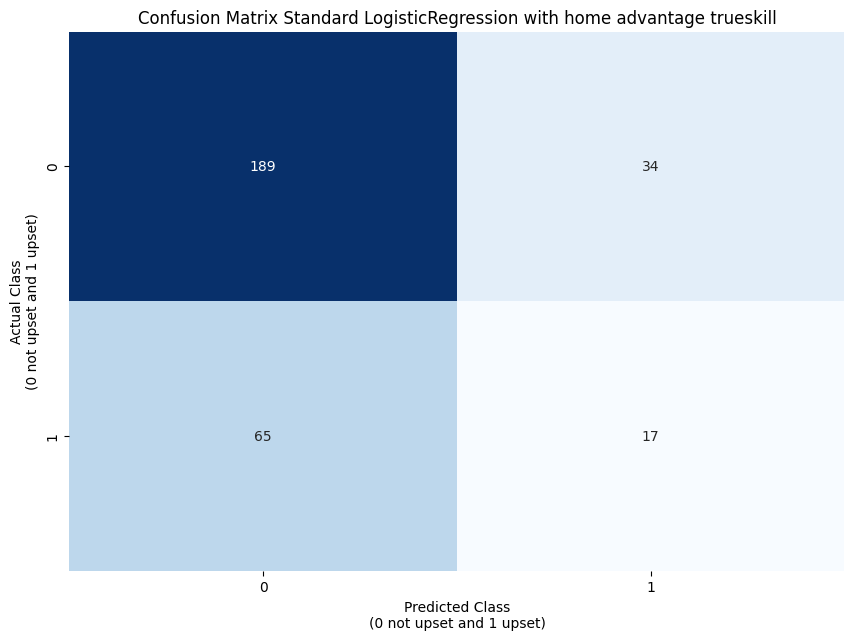

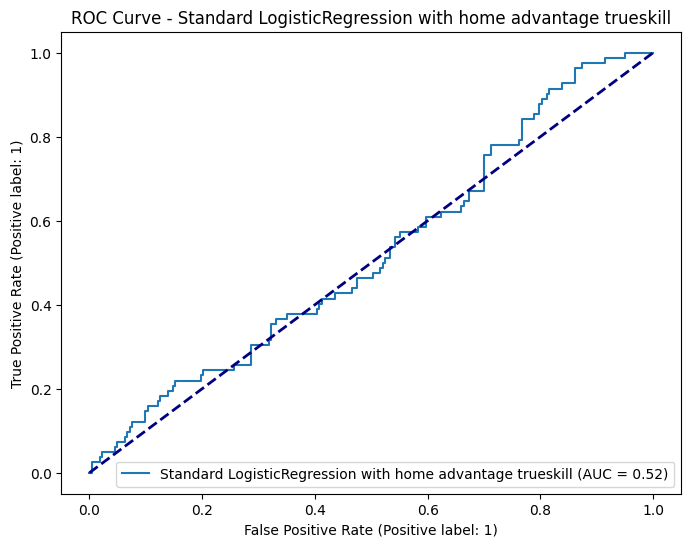

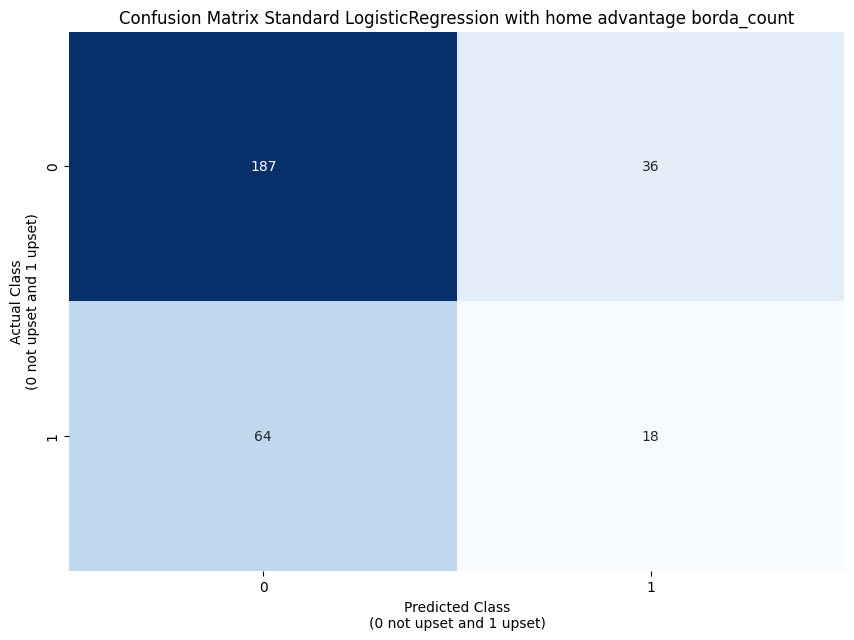

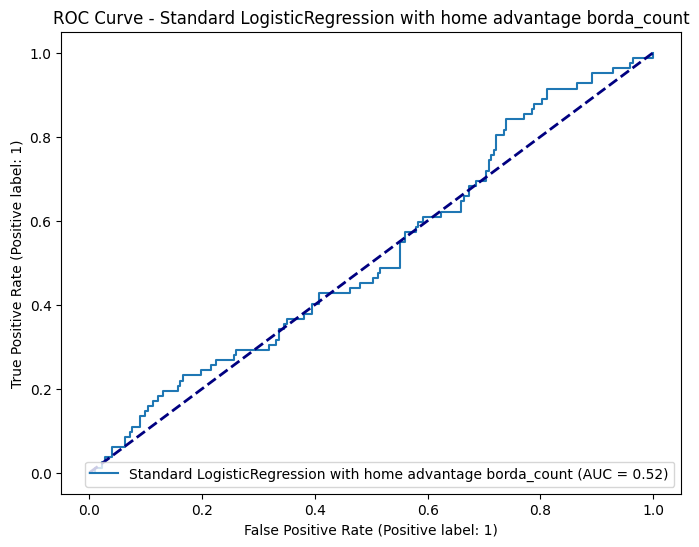

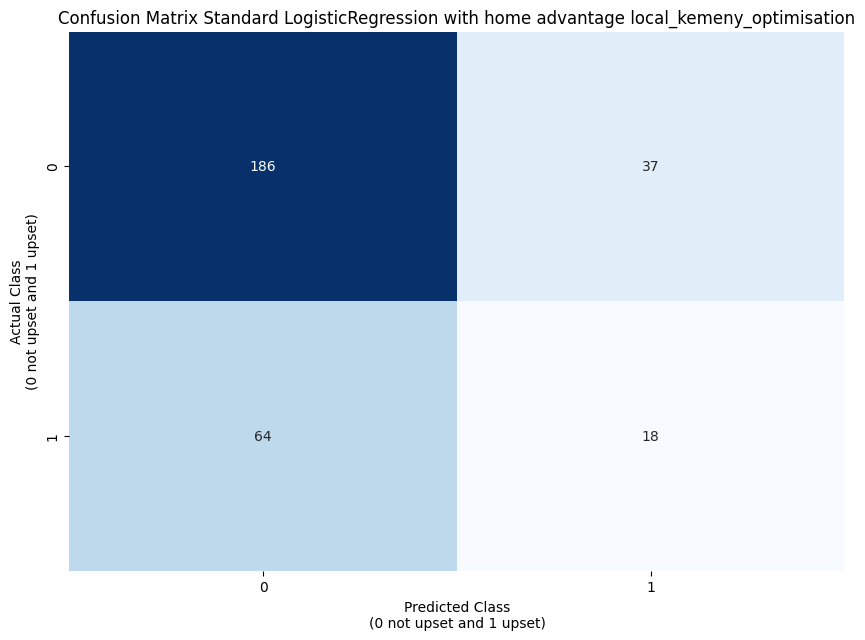

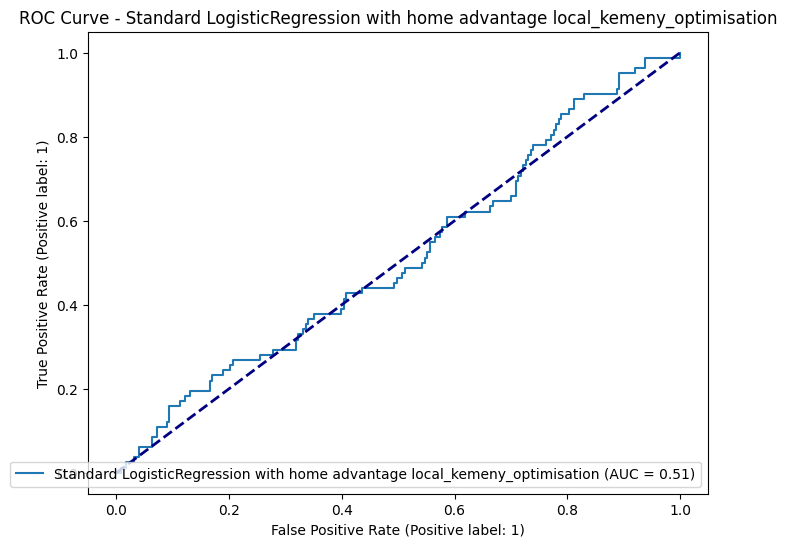

In [ ]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results.xlsx")
fold_results_df_slrh.to_excel("fold_results_slrh.xlsx")

Weighted LogisticRegression no_ranking
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.227
Fold 1 Train Accuracy: 0.766, test Accuracy: 0.721
Fold 1 Train Recall: 0.288, test Re

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   Weighted LogisticRegression no_ranking  \
0                                   0.767   
1                                   0.009   
2                                   0.692   
3                                   0.026   
4                                   0.293   
5                                   0.030   
6                                   0.185   
7                                   0.059   
8                                   0.470   
9                                   0.772   
10                                  0.692   
11                                196.000   
12                                 27.000   
13                                 67.000   
14                                 15.000   
15                                  0.745   
16                                  0.879   
17                                  0.807   
18                                  0.357   
19                                  0.183   
20                                  0.242   
21                                  0.551   
22                                  0.531   
23                                  0.524   
24                                  0.641   
25                                  0.692   
26                                  0.655   
27                                  0.546   

   Weighted LogisticRegression round_3_position  \
0                                         0.776   
1                                         0.010   
2                                         0.689   
3                                         0.027   
4                                         0.323   
5                                         0.017   
6                                         0.172   
7                                         0.050   
8                                         0.469   
9                                         0.695   
10                                        0.689   
11                                      196.000   
12                                       27.000   
13                                      

Model Name Ranking  Fold  \
0              Weighted LogisticRegression no_ranking     1   
1              Weighted LogisticRegression no_ranking     2   
2              Weighted LogisticRegression no_ranking     3   
3              Weighted LogisticRegression no_ranking     4   
4              Weighted LogisticRegression no_ranking     5   
5        Weighted LogisticRegression round_3_position     1   
6        Weighted LogisticRegression round_3_position     2   
7        Weighted LogisticRegression round_3_position     3   
8        Weighted LogisticRegression round_3_position     4   
9        Weighted LogisticRegression round_3_position     5   
10                 Weighted LogisticRegression massey     1   
11                 Weighted LogisticRegression massey     2   
12                 Weighted LogisticRegression massey     3   
13                 Weighted LogisticRegression massey     4   
14                 Weighted LogisticRegression massey     5   
15                 Weighted LogisticRegression colley     1   
16                 Weighted LogisticRegression colley     2   
17                 Weighted LogisticRegression colley     3   
18                 Weighted LogisticRegression colley     4   
19                 Weighted LogisticRegression colley     5   
20                 Weighted LogisticRegression keener     1   
21                 Weighted LogisticRegression keener     2   
22                 Weighted LogisticRegression keener     3   
23                 Weighted LogisticRegression keener     4   
24                 Weighted LogisticRegression keener     5   
25              Weighted LogisticRegression trueskill     1   
26              Weighted LogisticRegression trueskill     2   
27              Weighted LogisticRegression trueskill     3   
28              Weighted LogisticRegression trueskill     4   
29              Weighted LogisticRegression trueskill     5   
30            Weighted LogisticRegression borda_count     1   
31            Weighted LogisticRegression borda_count     2   
32            Weighted LogisticRegression borda_count     3   
33            Weighted LogisticRegression borda_count     4   
34            Weighted LogisticRegression borda_count     5   
35  Weighted LogisticRegression local_kemeny_optim...     1   
36  Weighted LogisticRegression local_kemeny_optim...     2   
37  Weighted LogisticRegression local_kemeny_optim...     3   
38  Weighted LogisticRegression local_kemeny_optim...     4   
39  Weighted LogisticRegression local_kemeny_optim...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 10.0, 'classifier__penalty':...   
1   {'classifier__C': 10.0, 'classifier__penalty':...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 0.09999999999999999, 'classi...   
4   {'classifier__C': 10.0, 'classifier__penalty':...   
5   {'classifier__C': 10.0, 'classifier__penalty':...   
6   {'classifier__C': 0.09999999999999999, 'classi...   
7   {'classifier__C': 1.0, 'classifier__penalty': ...   
8   {'classifier__C': 0.09999999999999999, 'classi...   
9   {'classifier__C': 10.0, 'classifier__penalty':...   
10  {'classifier__C': 1.0, 'classifier__penalty': ...   
11  {'classifier__C': 1.0, 'classifier__penalty': ...   
12  {'classifier__C': 1.0, 'classifier__penalty': ...   
13  {'classifier__C': 1.0, 'classifier__penalty': ...   
14  {'classifier__C': 10.0, 'classifier__penalty':...   
15  {'classifier__C': 1.0, 'classifier__penalty': ...   
16  {'classifier__C': 1.0, 'classifier__penalty': ...   
17  {'classifier__C': 1.0, 'classifier__penalty': ...   
18  {'classifier__C': 1.0, 'classifier__penalty': ...   
19  {'classifier__C': 10.0, 'classifier__penalty':...   
20  {'classifier__C': 10.0, 'classifier__penalty':...   
21  {'classifier__C': 1.0, 'classifier__penalty': ...   
22  {'classifier__C': 100.0, 'classifier__penalty'...   
23  {'classifier__C': 0.09999999999999999, 'classi...   
24  {'classifier__C': 10.0

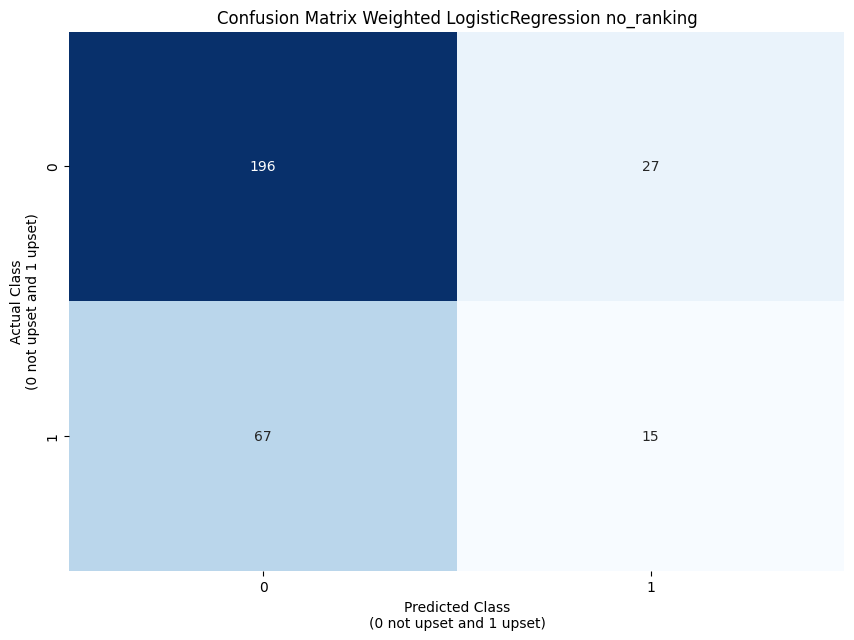

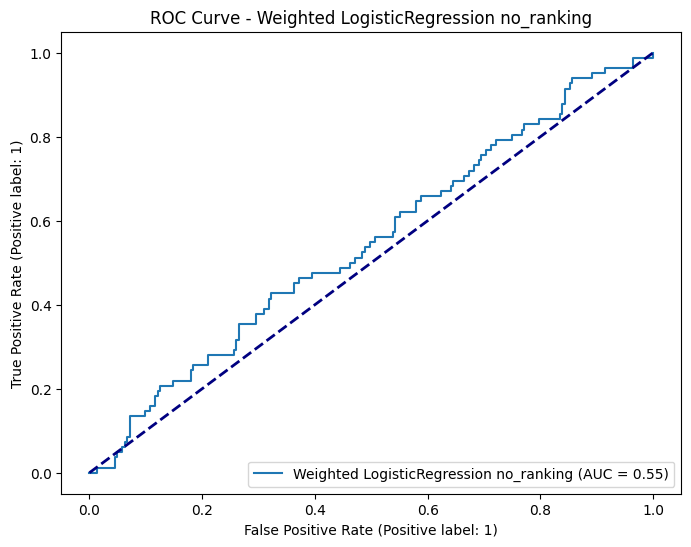

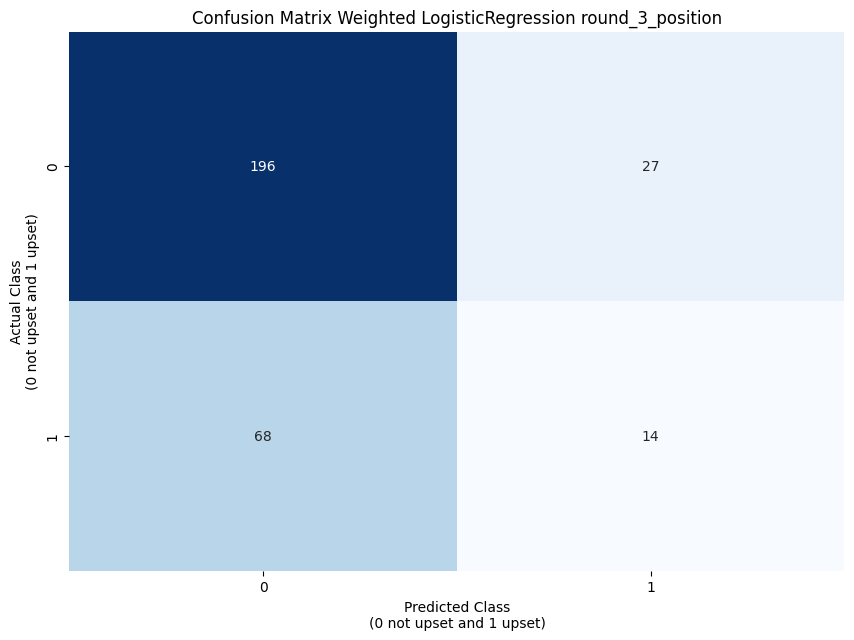

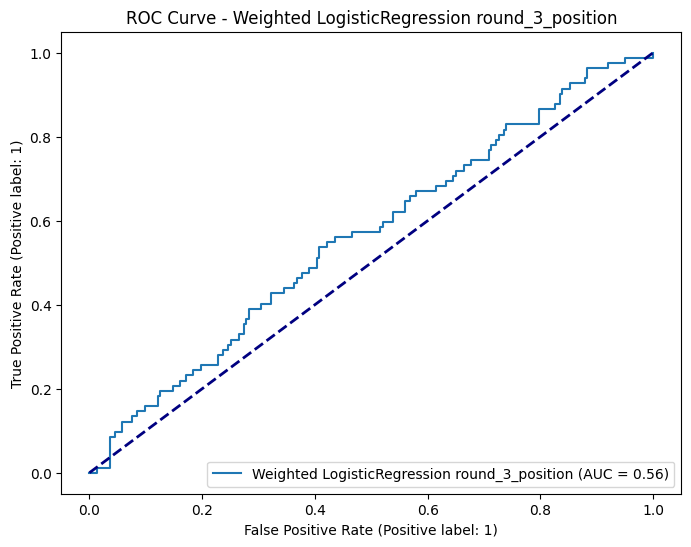

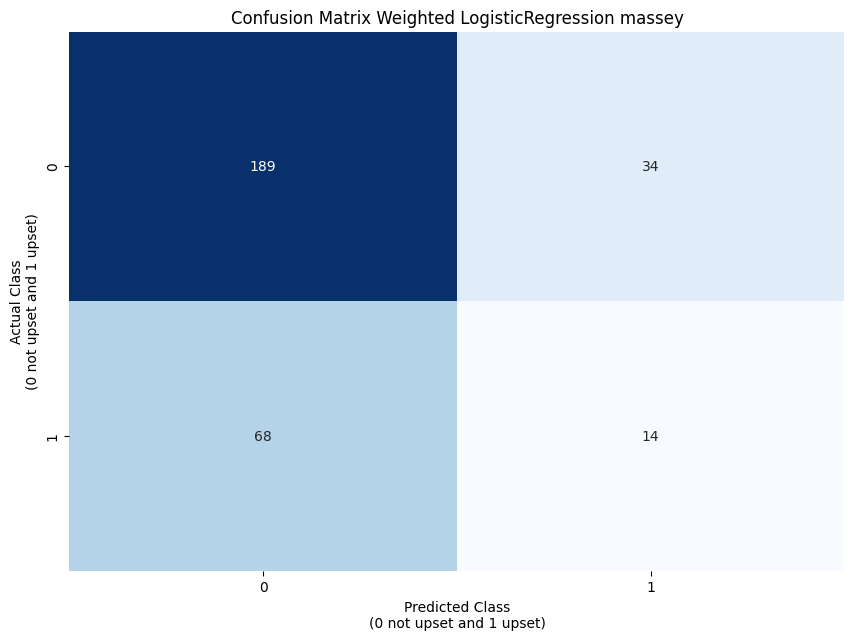

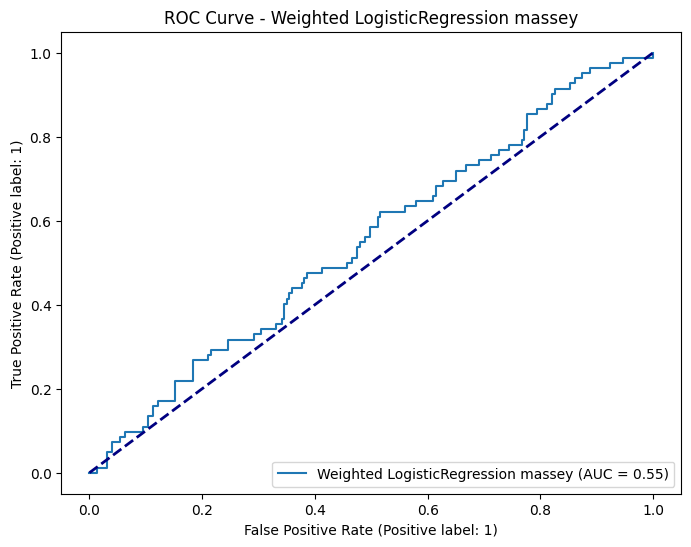

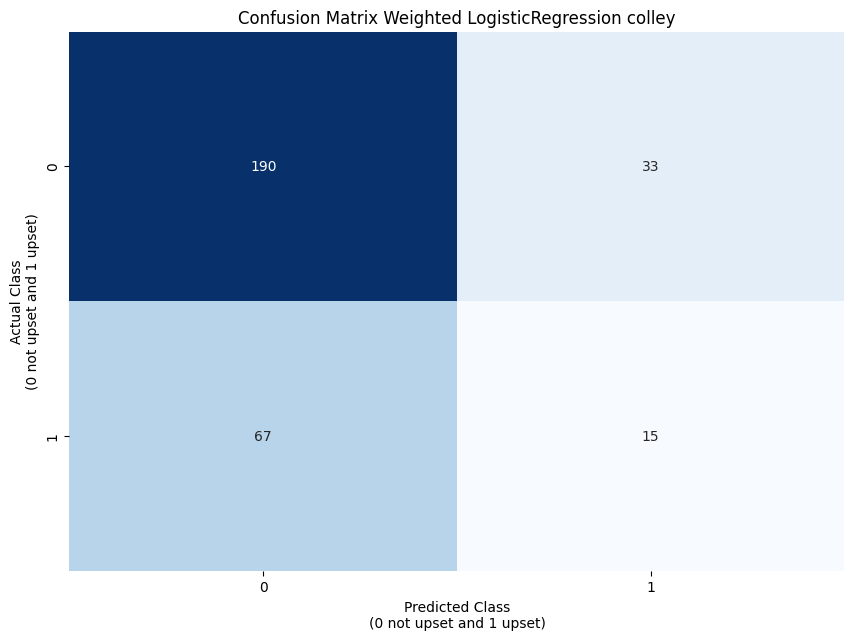

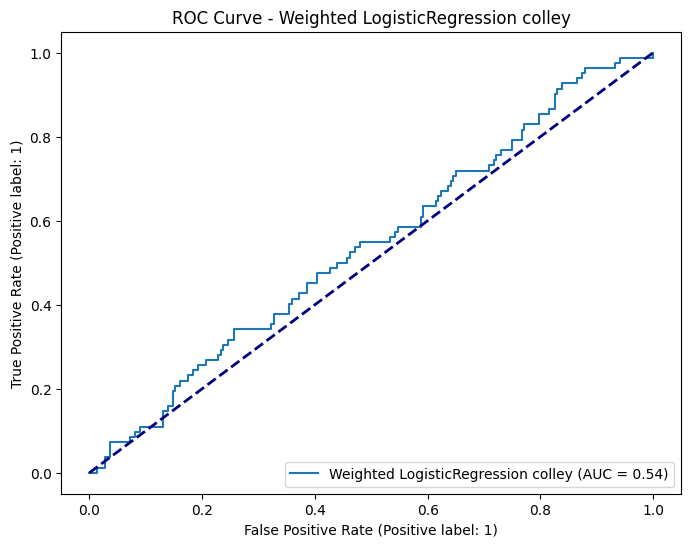

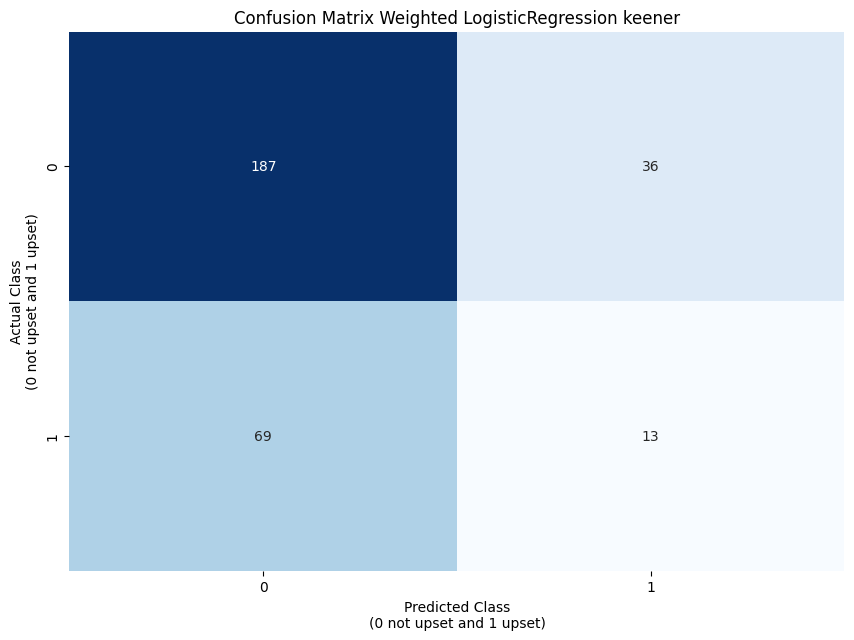

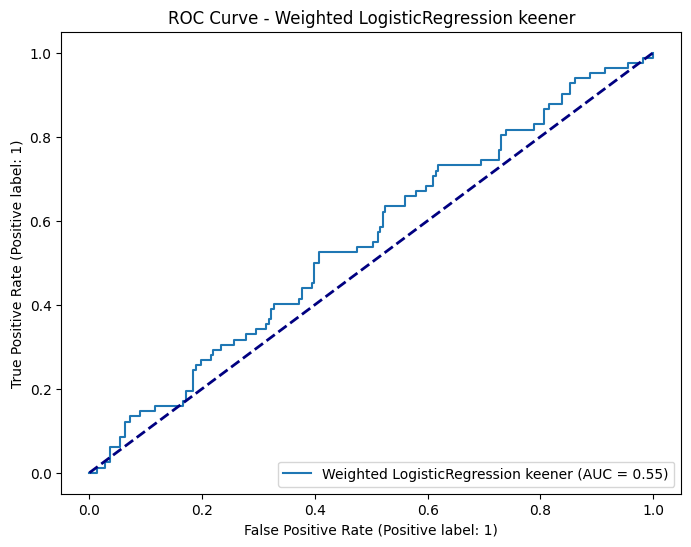

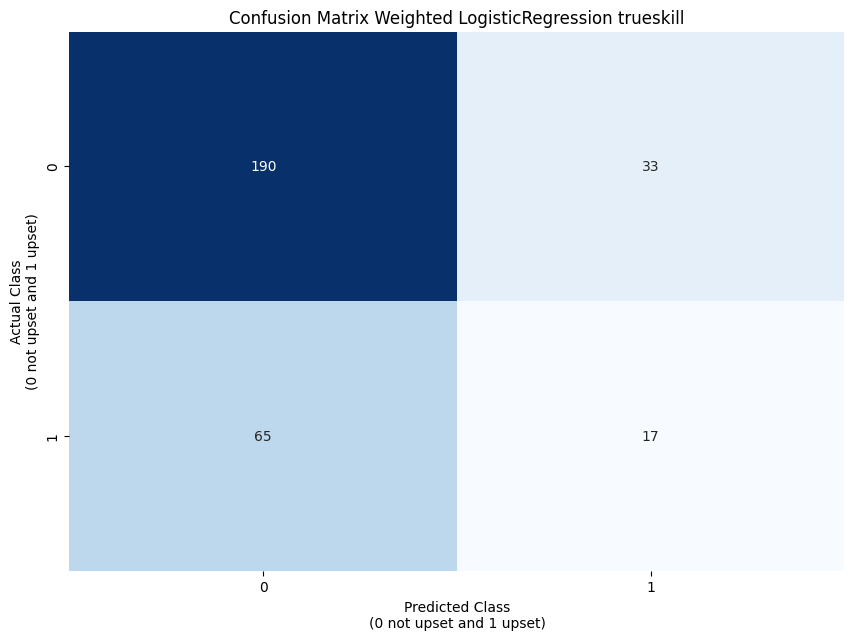

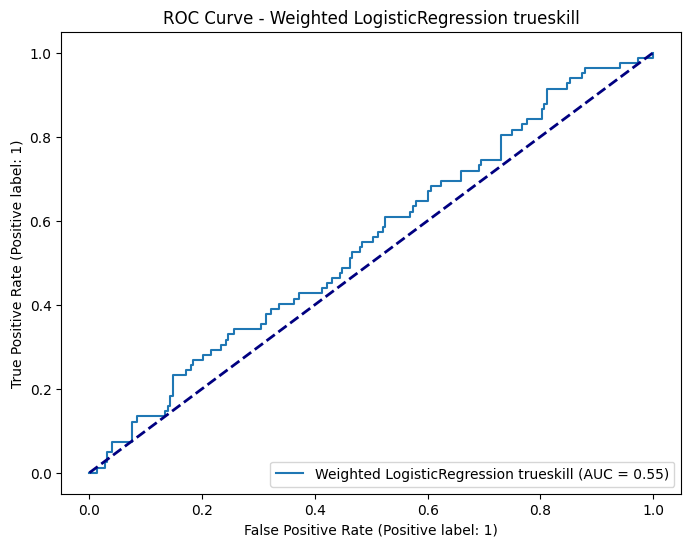

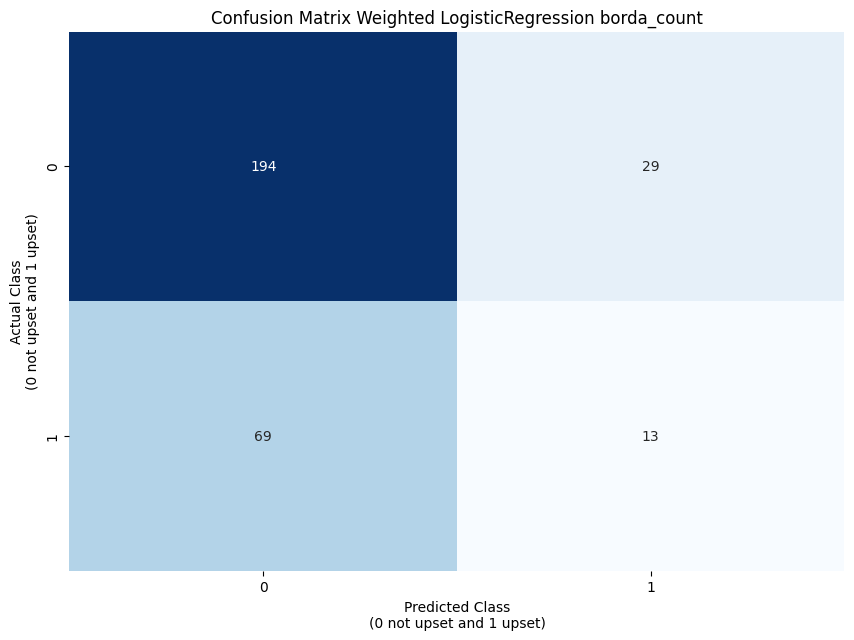

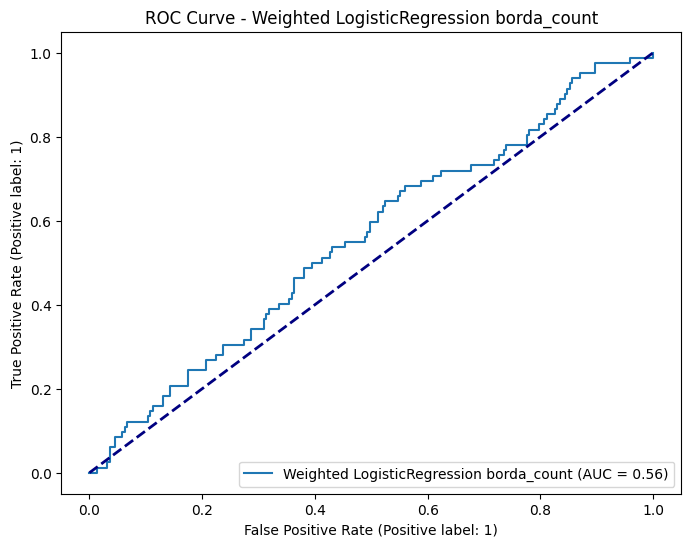

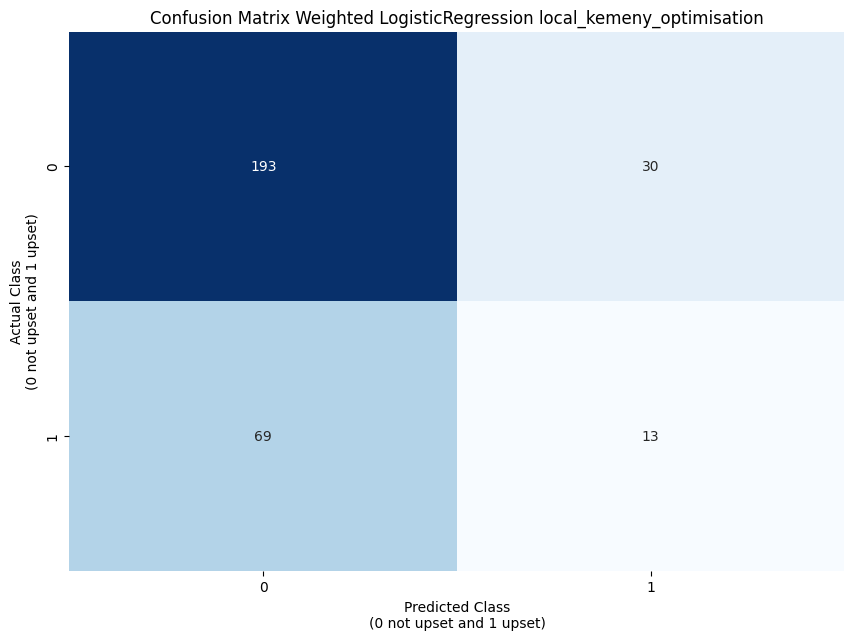

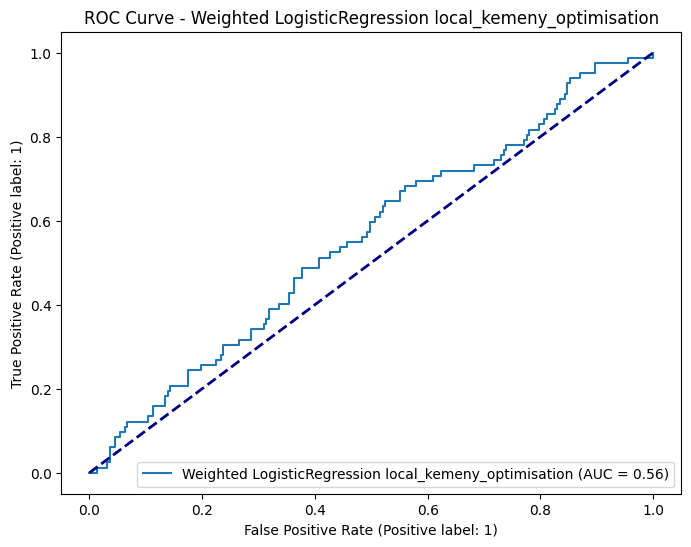

In [ ]:
0# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
random_state = 47
weights = {0: 50, 1: 50} # intial value before recalauclating
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr.xlsx")

Weighted LogisticRegression with home advantage no_ranking
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.227
Fold 1 Train Accuracy: 0.783, test Accuracy: 0.6

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   Weighted LogisticRegression with home advantage no_ranking  \
0                                               0.771           
1                                               0.009           
2                                               0.672           
3                                               0.029           
4                                               0.308           
5                                               0.035           
6                                               0.148           
7                                               0.065           
8                                               0.469           
9                                               0.735           
10                                              0.672           
11                                            193.000           
12                                             30.000           
13                                             70.000           
14                                             12.000           
15                                              0.734           
16                                              0.865           
17                                              0.794           
18                                              0.286           
19                                              0.146           
20                                              0.194           
21                                              0.510           
22                                              0.506           
23                                              0.494           
24                                              0.613           
25                                              0.672           
26                                              0.633           
27                                              0.530           

   Weighted LogisticRegression with home advantage round_3_position  \
0                                               0.776                 
1                               

Model Name Ranking  Fold  \
0   Weighted LogisticRegression with home advantag...     1   
1   Weighted LogisticRegression with home advantag...     2   
2   Weighted LogisticRegression with home advantag...     3   
3   Weighted LogisticRegression with home advantag...     4   
4   Weighted LogisticRegression with home advantag...     5   
5   Weighted LogisticRegression with home advantag...     1   
6   Weighted LogisticRegression with home advantag...     2   
7   Weighted LogisticRegression with home advantag...     3   
8   Weighted LogisticRegression with home advantag...     4   
9   Weighted LogisticRegression with home advantag...     5   
10  Weighted LogisticRegression with home advantag...     1   
11  Weighted LogisticRegression with home advantag...     2   
12  Weighted LogisticRegression with home advantag...     3   
13  Weighted LogisticRegression with home advantag...     4   
14  Weighted LogisticRegression with home advantag...     5   
15  Weighted LogisticRegression with home advantag...     1   
16  Weighted LogisticRegression with home advantag...     2   
17  Weighted LogisticRegression with home advantag...     3   
18  Weighted LogisticRegression with home advantag...     4   
19  Weighted LogisticRegression with home advantag...     5   
20  Weighted LogisticRegression with home advantag...     1   
21  Weighted LogisticRegression with home advantag...     2   
22  Weighted LogisticRegression with home advantag...     3   
23  Weighted LogisticRegression with home advantag...     4   
24  Weighted LogisticRegression with home advantag...     5   
25  Weighted LogisticRegression with home advantag...     1   
26  Weighted LogisticRegression with home advantag...     2   
27  Weighted LogisticRegression with home advantag...     3   
28  Weighted LogisticRegression with home advantag...     4   
29  Weighted LogisticRegression with home advantag...     5   
30  Weighted LogisticRegression with home advantag...     1   
31  Weighted LogisticRegression with home advantag...     2   
32  Weighted LogisticRegression with home advantag...     3   
33  Weighted LogisticRegression with home advantag...     4   
34  Weighted LogisticRegression with home advantag...     5   
35  Weighted LogisticRegression with home advantag...     1   
36  Weighted LogisticRegression with home advantag...     2   
37  Weighted LogisticRegression with home advantag...     3   
38  Weighted LogisticRegression with home advantag...     4   
39  Weighted LogisticRegression with home advantag...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 1.0, 'classifier__penalty': ...   
1   {'classifier__C': 10.0, 'classifier__penalty':...   
2   {'classifier__C': 1.0, 'classifier__penalty': ...   
3   {'classifier__C': 0.09999999999999999, 'classi...   
4   {'classifier__C': 10.0, 'classifier__penalty':...   
5   {'classifier__C': 1.0, 'classifier__penalty': ...   
6   {'classifier__C': 0.09999999999999999, 'classi...   
7   {'classifier__C': 1.0, 'classifier__penalty': ...   
8   {'classifier__C': 1.0, 'classifier__penalty': ...   
9   {'classifier__C': 10.0, 'classifier__penalty':...   
10  {'classifier__C': 1.0, 'classifier__penalty': ...   
11  {'classifier__C': 1.0, 'classifier__penalty': ...   
12  {'classifier__C': 100.0, 'classifier__penalty'...   
13  {'classifier__C': 10.0, 'classifier__penalty':...   
14  {'classifier__C': 1.0, 'classifier__penalty': ...   
15  {'classifier__C': 1.0, 'classifier__penalty': ...   
16  {'classifier__C': 1.0, 'classifier__penalty': ...   
17  {'classifier__C': 1.0, 'classifier__penalty': ...   
18  {'classifier__C': 1.0, 'classifier__penalty': ...   
19  {'classifier__C': 1000.0, 'classifier__penalty...   
20  {'classifier__C': 10.0, 'classifier__penalty':...   
21  {'classifier__C': 1.0, 'classifier__penalty': ...   
22  {'classifier__C': 10.0, 'classifier__penalty':...   
23  {'classifier__C': 0.09999999999999999, 'classi...   
24  {'classifier__C': 100.

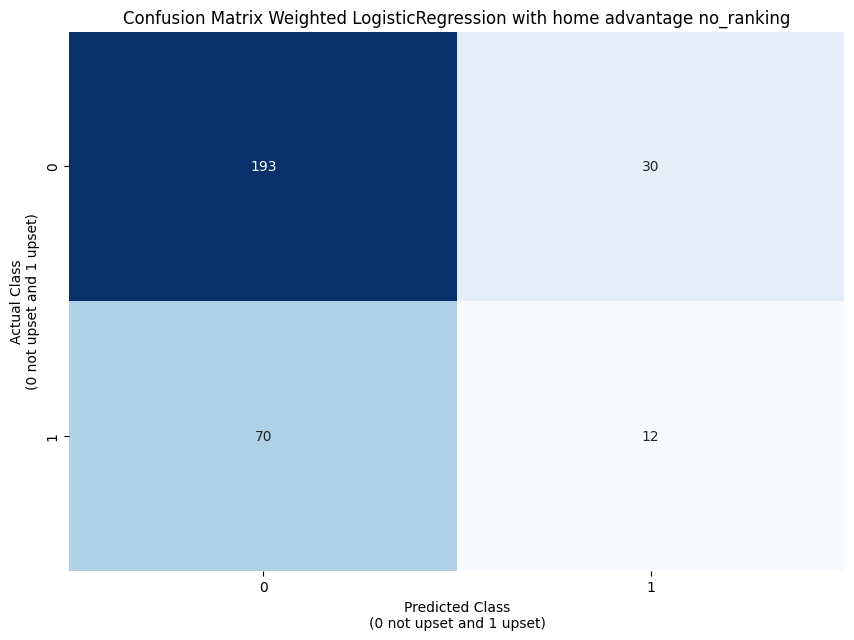

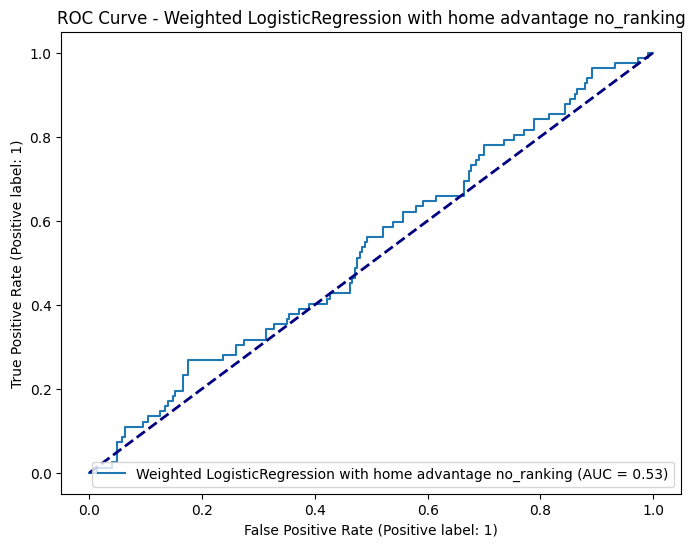

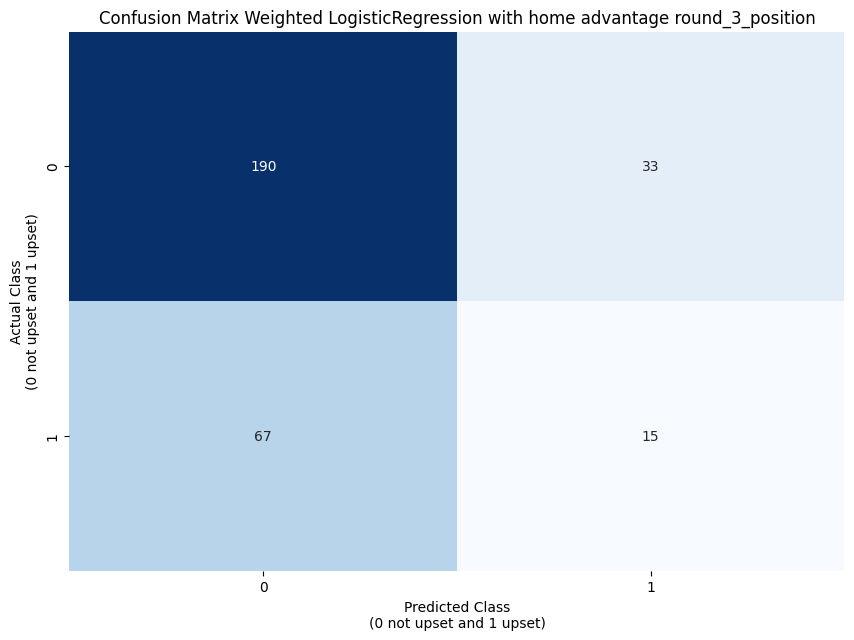

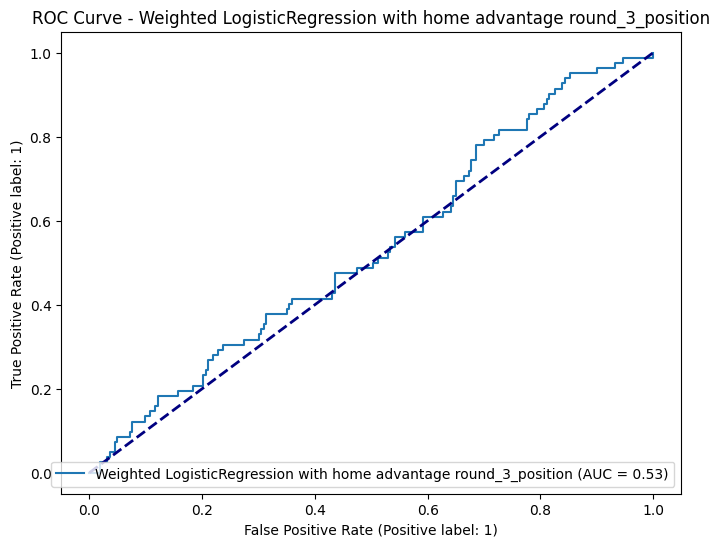

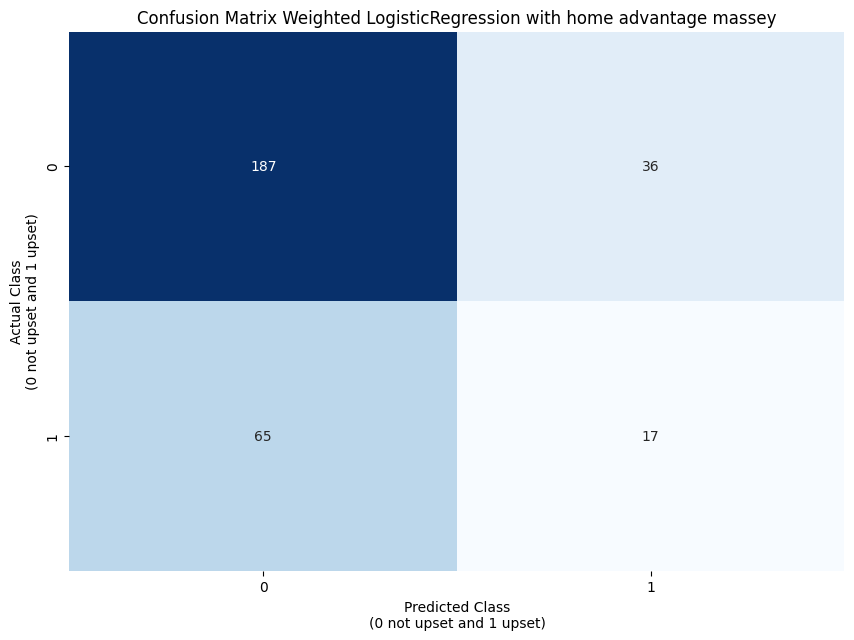

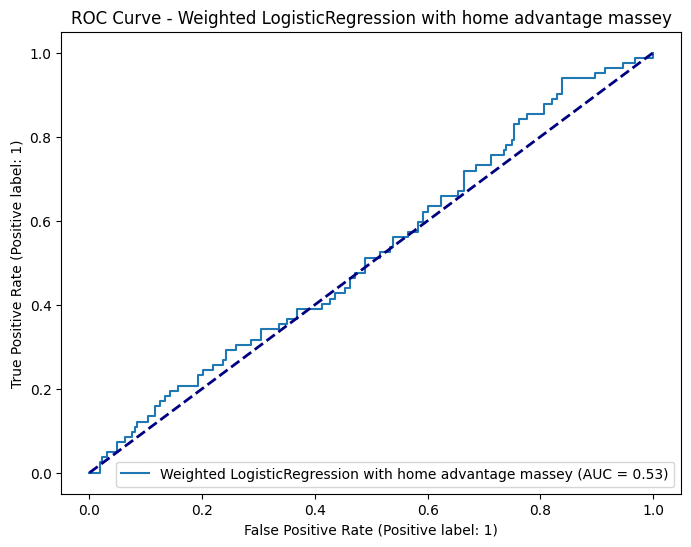

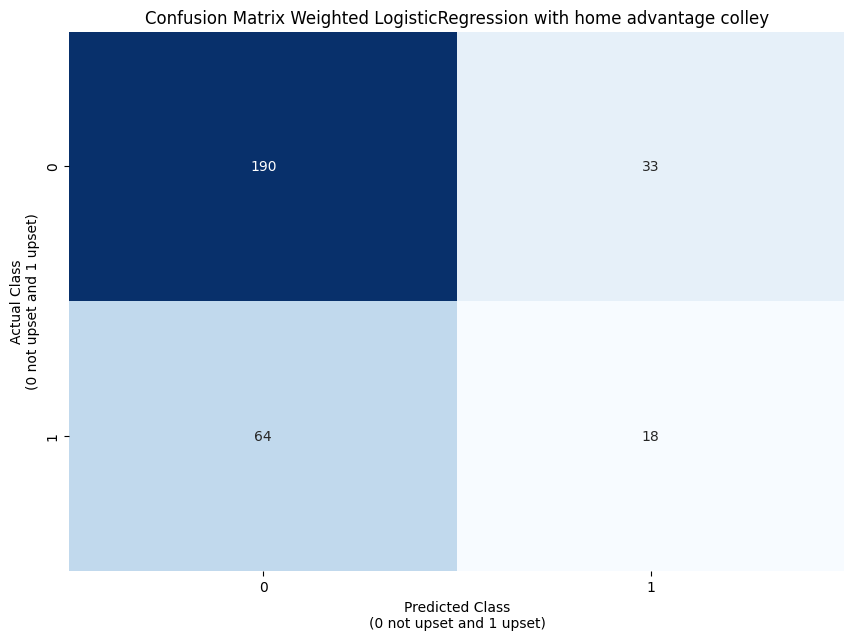

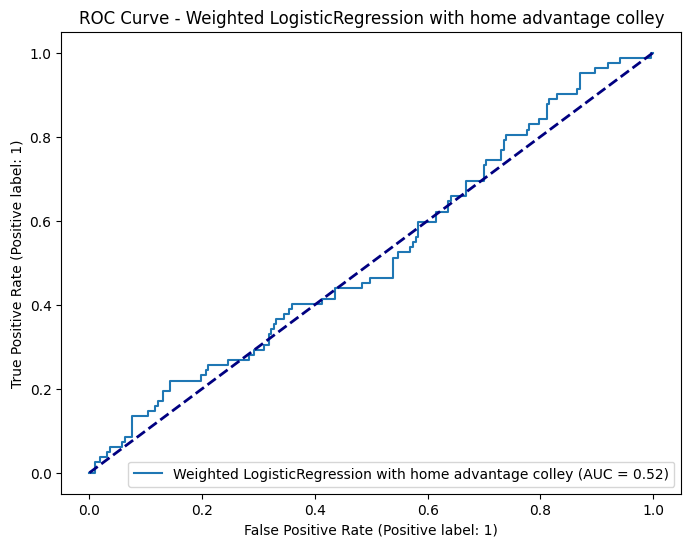

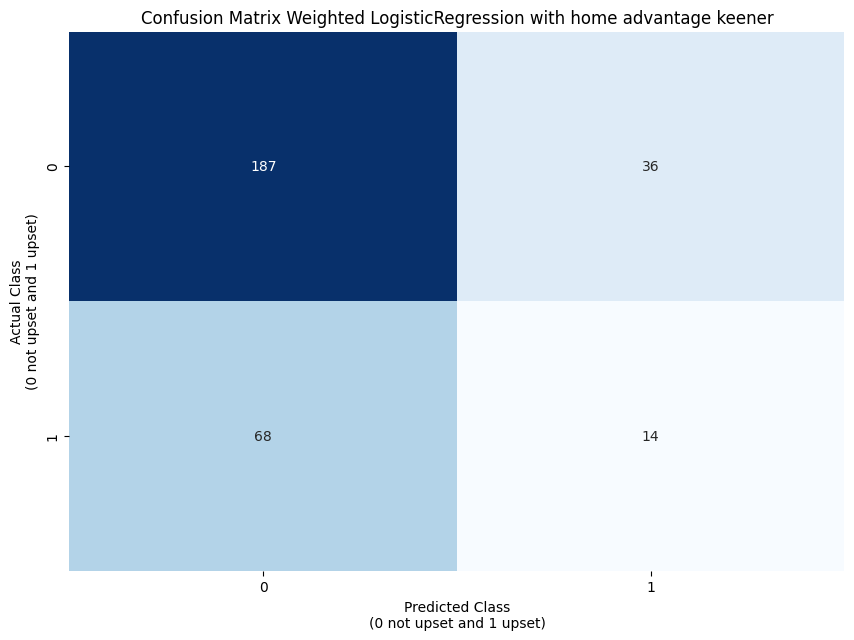

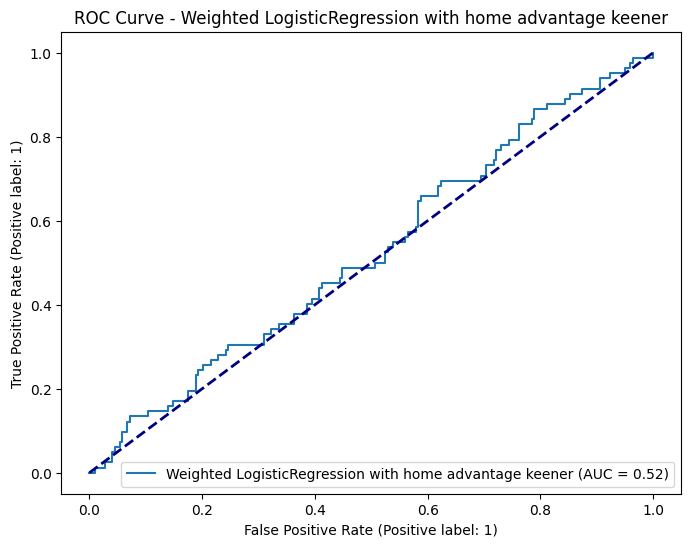

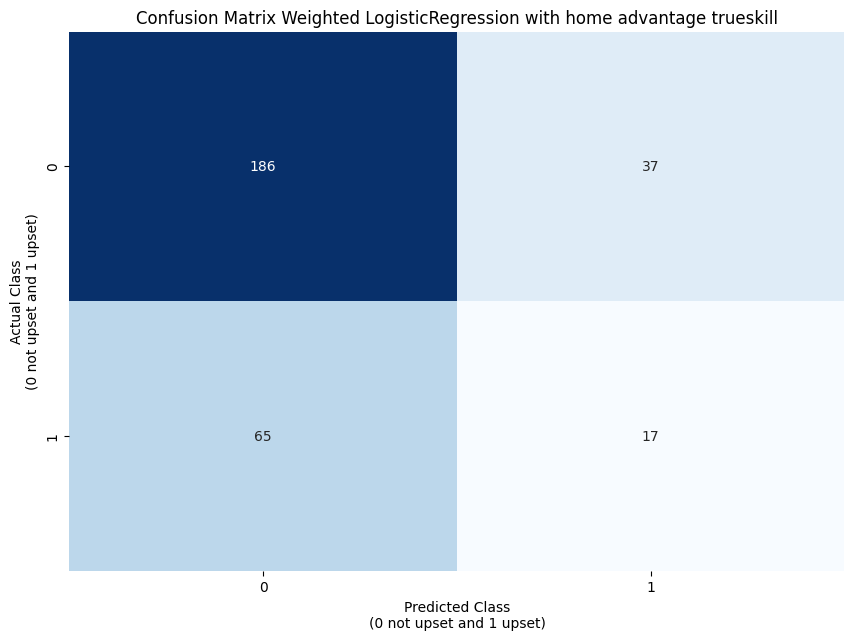

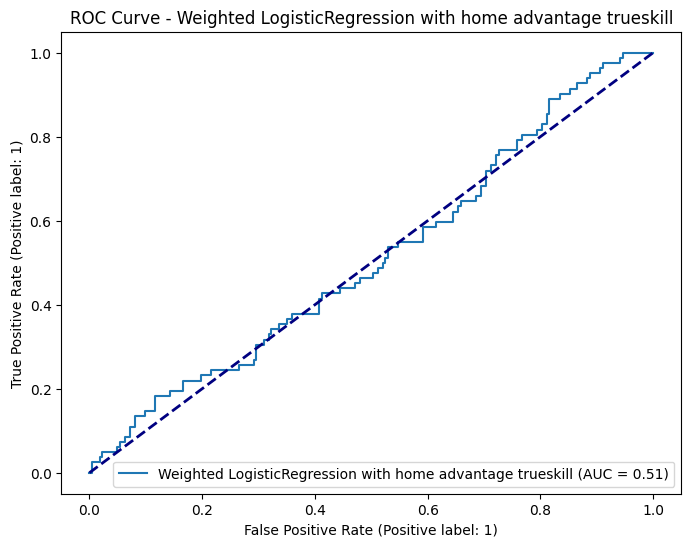

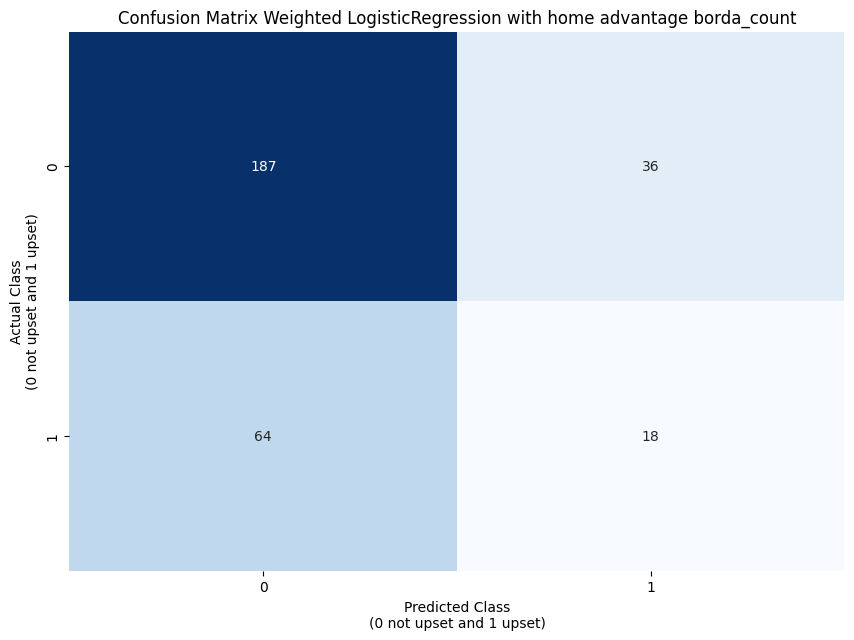

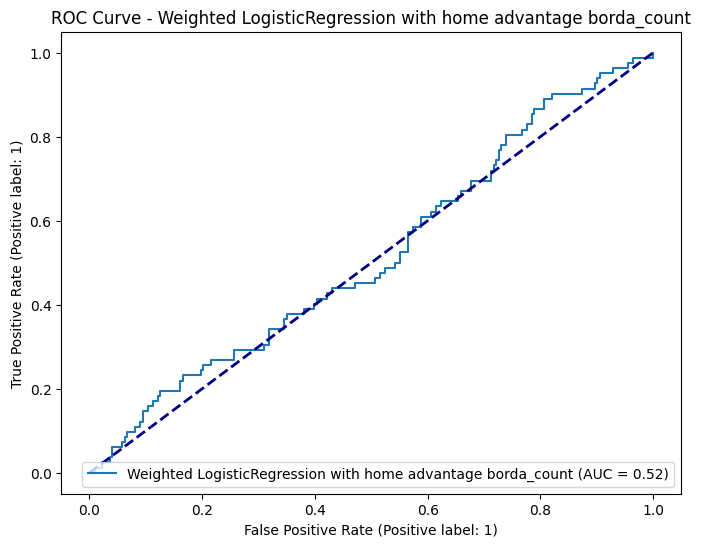

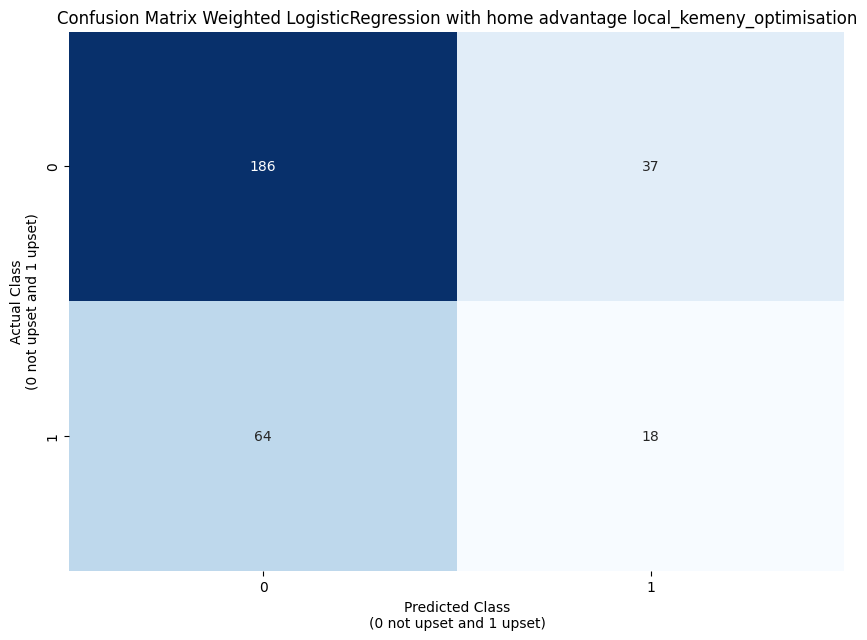

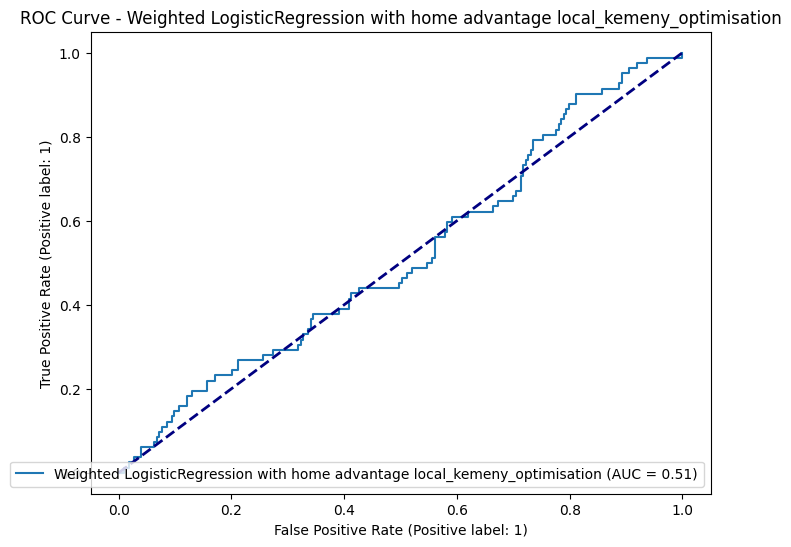

In [ ]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
random_state = 47
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

MLP Classifier Neural Network no_ranking
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 1 Train Accuracy

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   MLP Classifier Neural Network no_ranking  \
0                                     0.789   
1                                     0.088   
2                                     0.662   
3                                     0.070   
4                                     0.401   
5                                     0.356   
6                                     0.149   
7                                     0.161   
8                                     0.428   
9                                     0.890   
10                                    0.662   
11                                  190.000   
12                                   33.000   
13                                   70.000   
14                                   12.000   
15                                    0.731   
16                                    0.852   
17                                    0.787   
18                                    0.267   
19                                    0.146   
20                                    0.189   
21                                    0.499   
22                                    0.499   
23                                    0.488   
24                                    0.606   
25                                    0.662   
26                                    0.626   
27                                    0.488   

   MLP Classifier Neural Network round_3_position  \
0                                           0.898   
1                                           0.098   
2                                           0.685   
3                                           0.028   
4                                           0.708   
5                                           0.379   
6                                           0.271   
7                                           0.212   
8                                           0.252   
9                                           1.355   
10                                          0.685   
11                                        187.000   
12     

Model Name Ranking  Fold  \
0            MLP Classifier Neural Network no_ranking     1   
1            MLP Classifier Neural Network no_ranking     2   
2            MLP Classifier Neural Network no_ranking     3   
3            MLP Classifier Neural Network no_ranking     4   
4            MLP Classifier Neural Network no_ranking     5   
5      MLP Classifier Neural Network round_3_position     1   
6      MLP Classifier Neural Network round_3_position     2   
7      MLP Classifier Neural Network round_3_position     3   
8      MLP Classifier Neural Network round_3_position     4   
9      MLP Classifier Neural Network round_3_position     5   
10               MLP Classifier Neural Network massey     1   
11               MLP Classifier Neural Network massey     2   
12               MLP Classifier Neural Network massey     3   
13               MLP Classifier Neural Network massey     4   
14               MLP Classifier Neural Network massey     5   
15               MLP Classifier Neural Network colley     1   
16               MLP Classifier Neural Network colley     2   
17               MLP Classifier Neural Network colley     3   
18               MLP Classifier Neural Network colley     4   
19               MLP Classifier Neural Network colley     5   
20               MLP Classifier Neural Network keener     1   
21               MLP Classifier Neural Network keener     2   
22               MLP Classifier Neural Network keener     3   
23               MLP Classifier Neural Network keener     4   
24               MLP Classifier Neural Network keener     5   
25            MLP Classifier Neural Network trueskill     1   
26            MLP Classifier Neural Network trueskill     2   
27            MLP Classifier Neural Network trueskill     3   
28            MLP Classifier Neural Network trueskill     4   
29            MLP Classifier Neural Network trueskill     5   
30          MLP Classifier Neural Network borda_count     1   
31          MLP Classifier Neural Network borda_count     2   
32          MLP Classifier Neural Network borda_count     3   
33          MLP Classifier Neural Network borda_count     4   
34          MLP Classifier Neural Network borda_count     5   
35  MLP Classifier Neural Network local_kemeny_opt...     1   
36  MLP Classifier Neural Network local_kemeny_opt...     2   
37  MLP Classifier Neural Network local_kemeny_opt...     3   
38  MLP Classifier Neural Network local_kemeny_opt...     4   
39  MLP Classifier Neural Network local_kemeny_opt...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__activation': 'tanh', 'classifier...   
1   {'classifier__activation': 'logistic', 'classi...   
2   {'classifier__activation': 'relu', 'classifier...   
3   {'classifier__activation': 'relu', 'classifier...   
4   {'classifier__activation': 'relu', 'classifier...   
5   {'classifier__activation': 'logistic', 'classi...   
6   {'classifier__activation': 'logistic', 'classi...   
7   {'classifier__activation': 'logistic', 'classi...   
8   {'classifier__activation': 'relu', 'classifier...   
9   {'classifier__activation': 'relu', 'classifier...   
10  {'classifier__activation': 'tanh', 'classifier...   
11  {'classifier__activation': 'logistic', 'classi...   
12  {'classifier__activation': 'relu', 'classifier...   
13  {'classifier__activation': 'logistic', 'classi...   
14  {'classifier__activation': 'relu', 'classifier...   
15  {'classifier__activation': 'relu', 'classifier...   
16  {'classifier__activation': 'relu', 'classifier...   
17  {'classifier__activation': 'relu', 'classifier...   
18  {'classifier__activation': 'logistic', 'classi...   
19  {'classifier__activation': 'relu', 'classifier...   
20  {'classifier__activation': 'relu', 'classifier...   
21  {'classifier__activation': 'tanh', 'classifier...   
22  {'classifier__activation': 'relu', 'classifier...   
23  {'classifier__activation': 'logistic', 'classi...   
24  {'classifier__activati

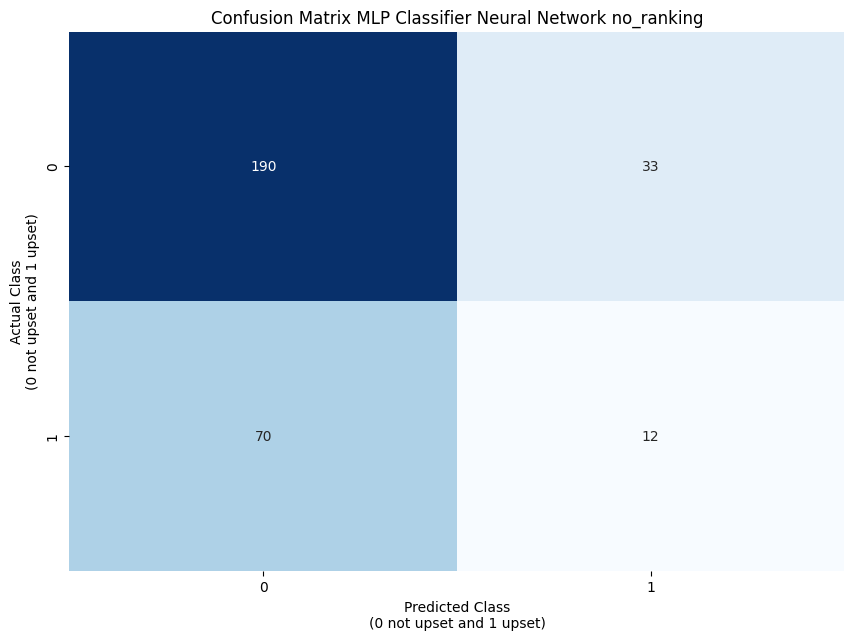

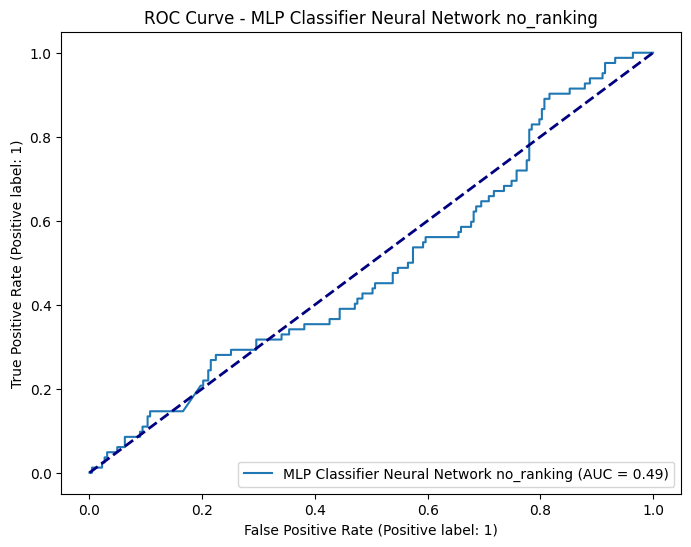

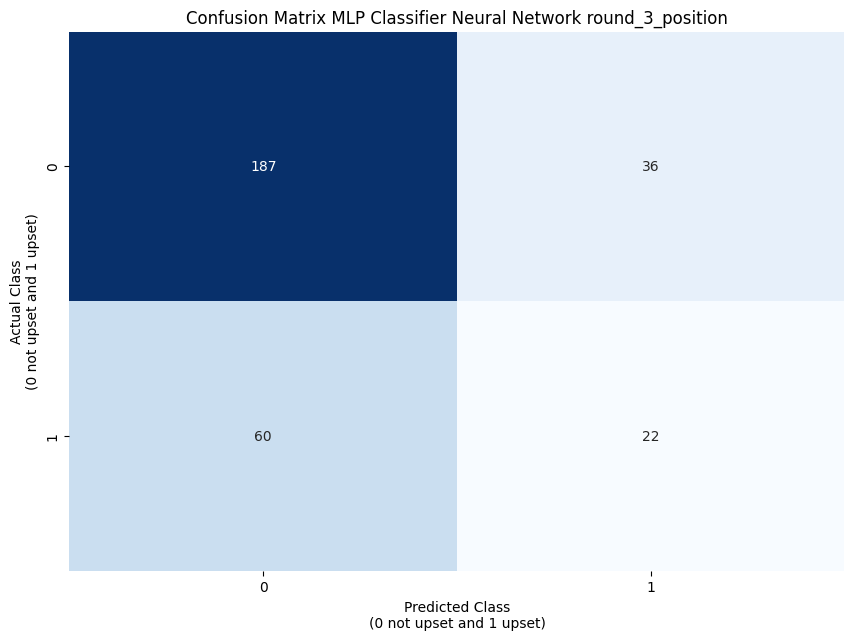

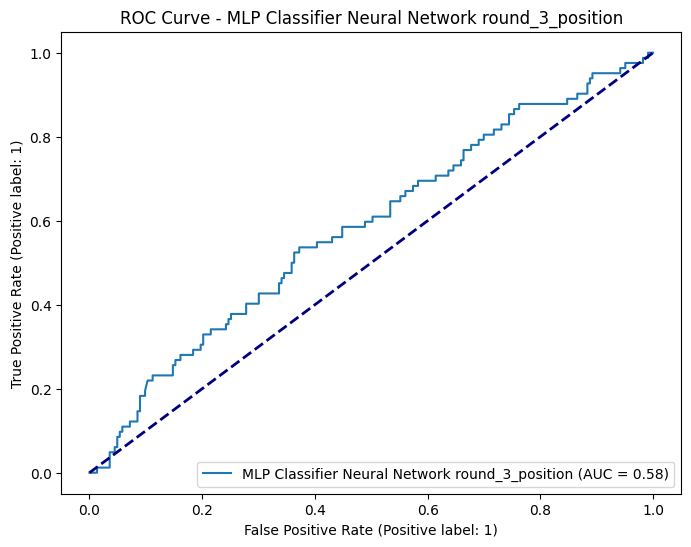

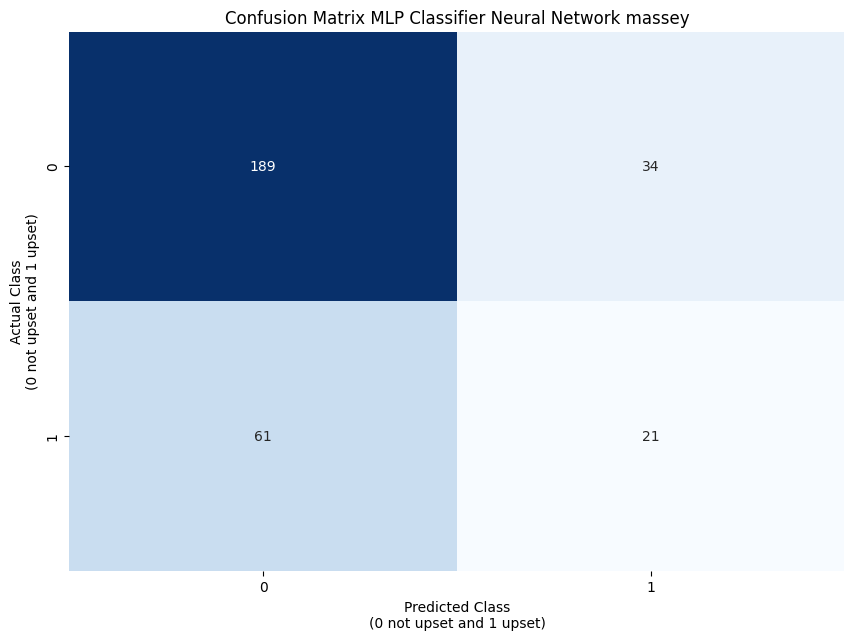

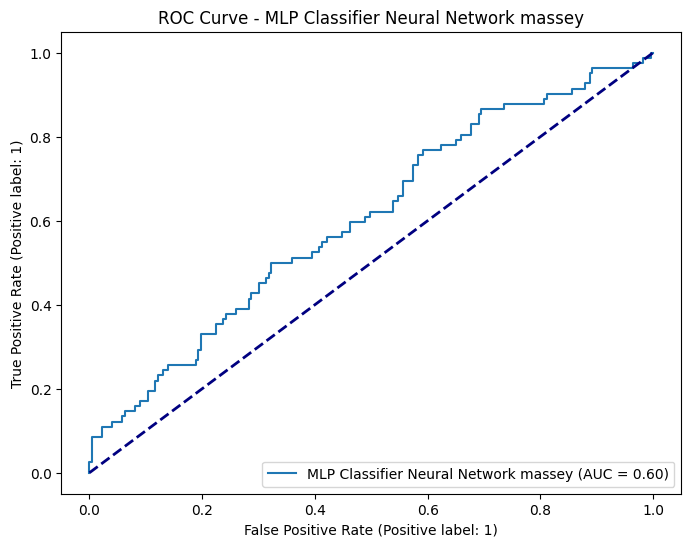

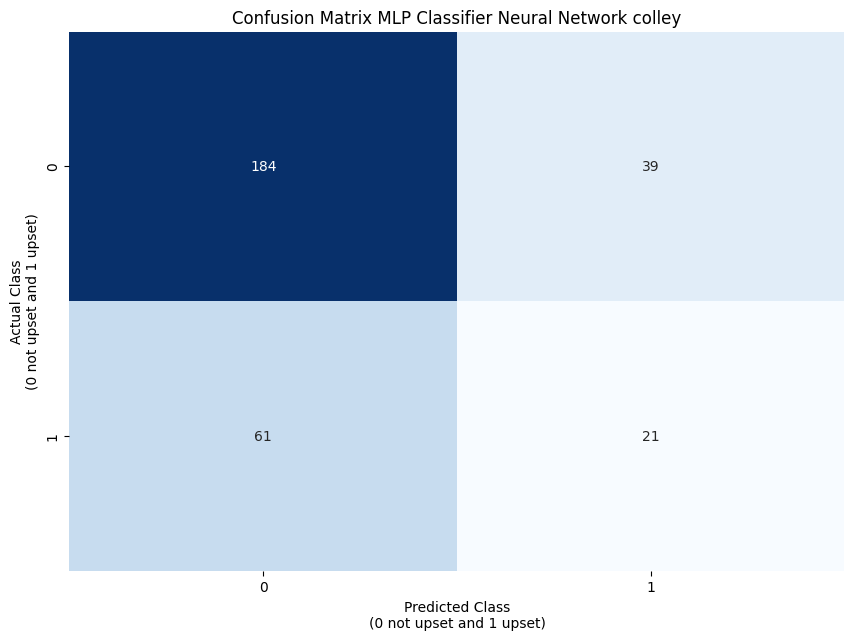

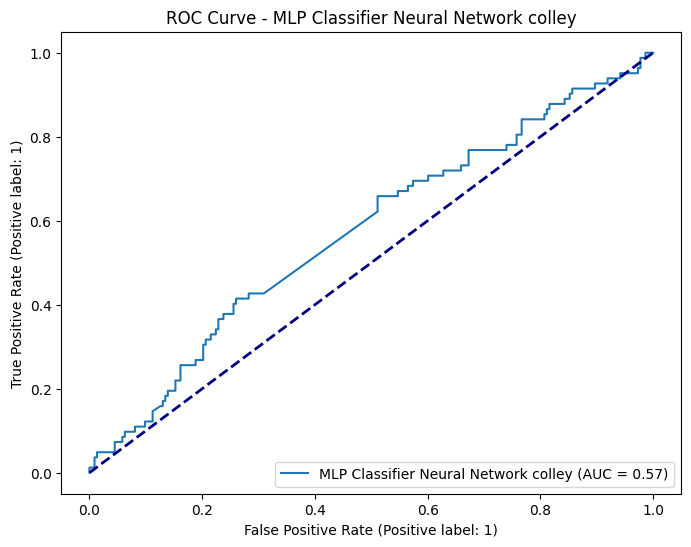

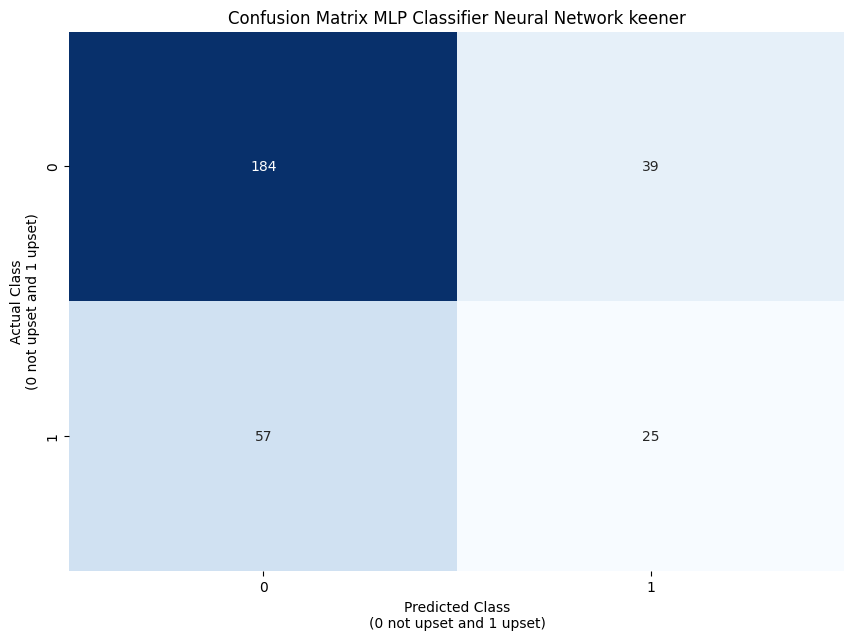

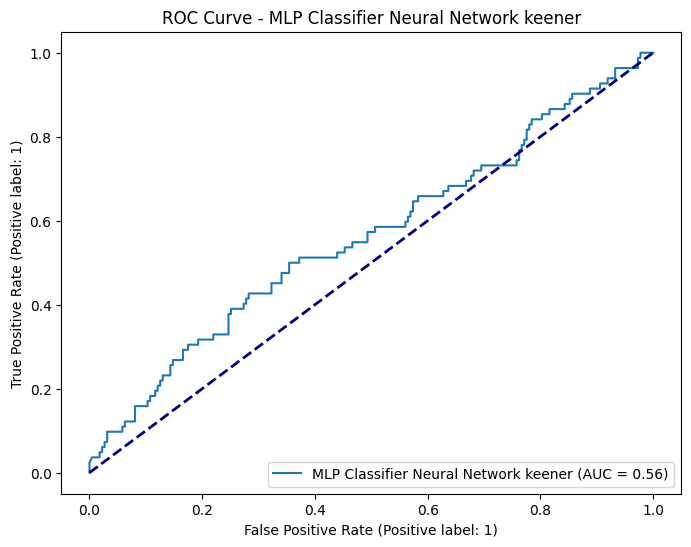

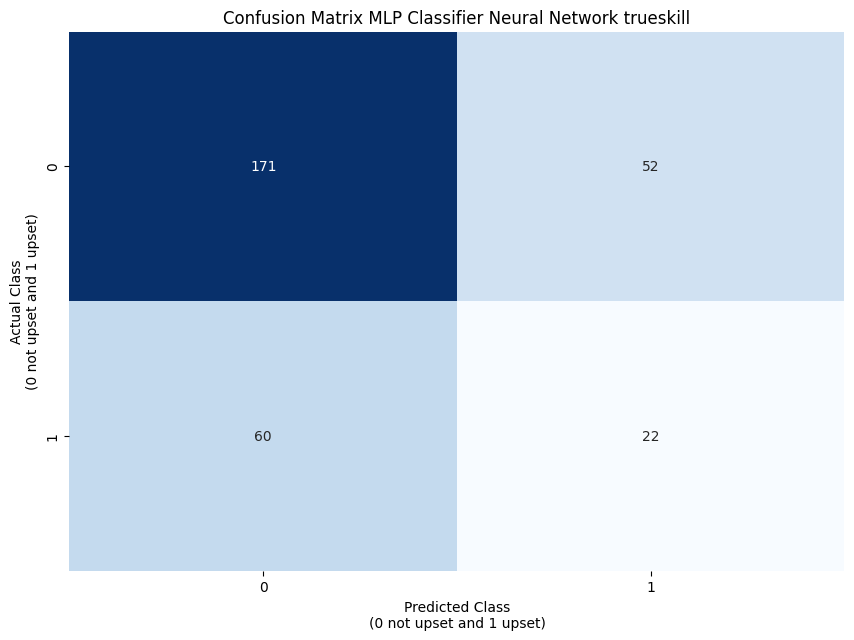

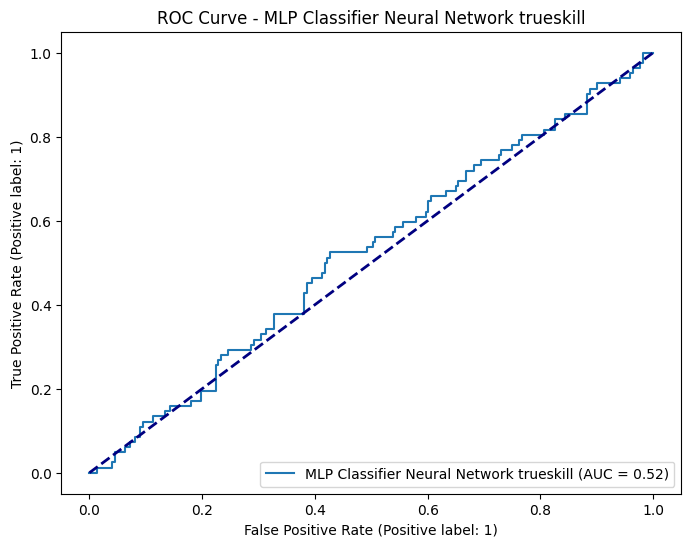

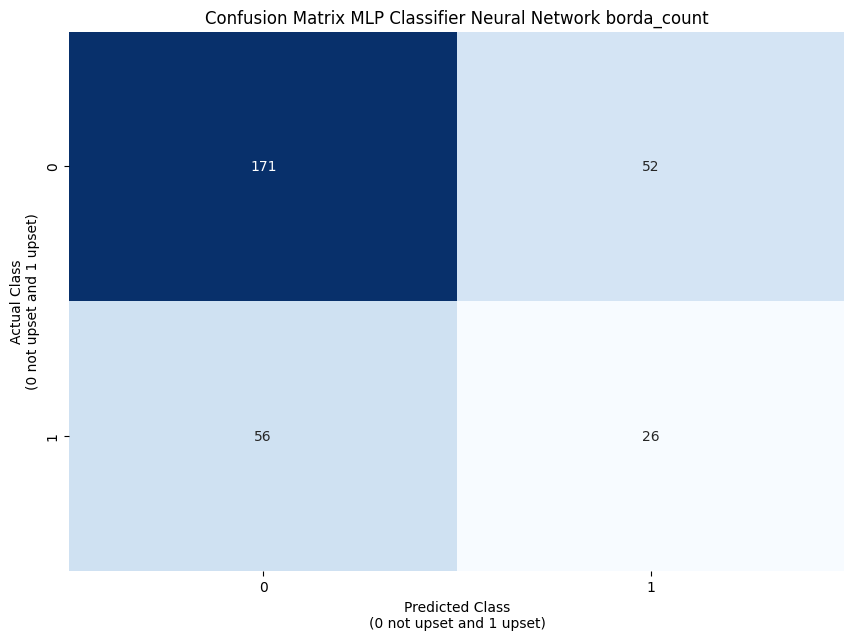

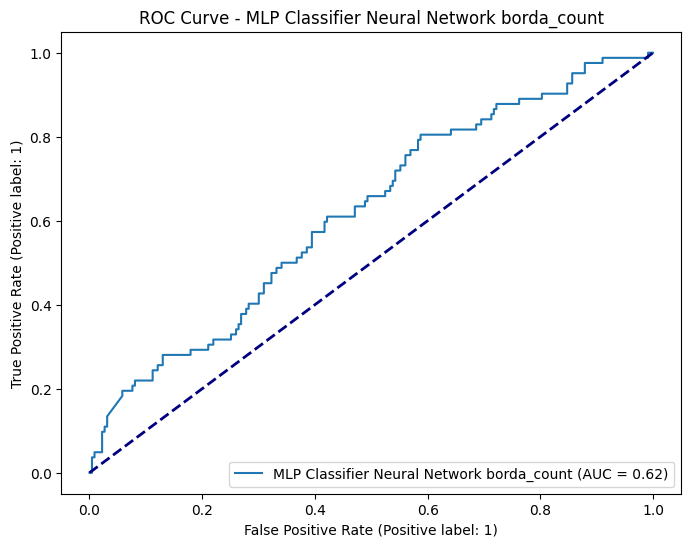

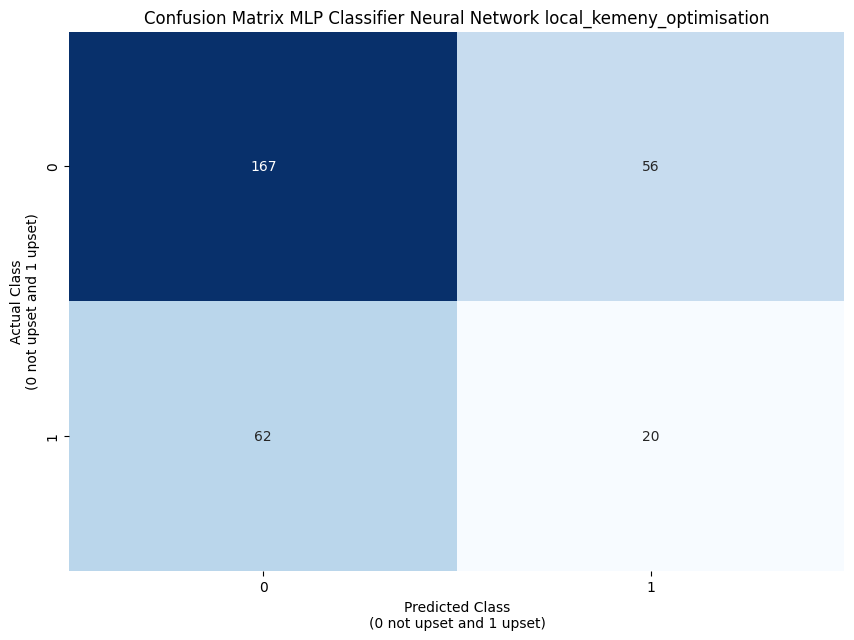

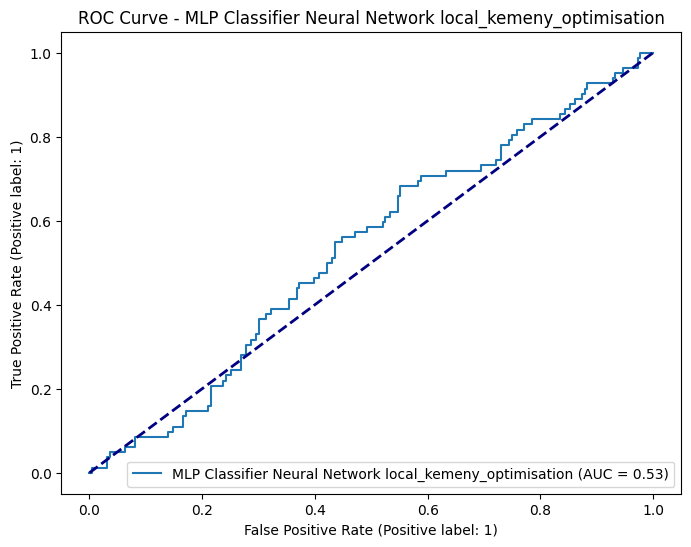

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

fold_results_df_nn = fold_results_df
display(fold_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
fold_results_df_nn.to_excel("fold_results_nn.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from Gr

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   MLP Classifier Neural Network with home advantage no_ranking  \
0                                               0.871             
1                                               0.120             
2                                               0.685             
3                                               0.060             
4                                               0.567             
5                                               0.466             
6                                               0.182             
7                                               0.176             
8                                               0.273             
9                                               1.639             
10                                              0.685             
11                                            194.000             
12                                             29.000             
13                                             67.000             
14                                             15.000             
15                                              0.743             
16                                              0.870             
17                                              0.802             
18                                              0.341             
19                                              0.183             
20                                              0.238             
21                                              0.542             
22                                              0.526             
23                                              0.520             
24                                              0.635             
25                                              0.685             
26                                              0.650             
27                                              0.533             

   MLP Classifier Neural Network with home advantage round_3_position  \
0                                          

Model Name Ranking  Fold  \
0   MLP Classifier Neural Network with home advant...     1   
1   MLP Classifier Neural Network with home advant...     2   
2   MLP Classifier Neural Network with home advant...     3   
3   MLP Classifier Neural Network with home advant...     4   
4   MLP Classifier Neural Network with home advant...     5   
5   MLP Classifier Neural Network with home advant...     1   
6   MLP Classifier Neural Network with home advant...     2   
7   MLP Classifier Neural Network with home advant...     3   
8   MLP Classifier Neural Network with home advant...     4   
9   MLP Classifier Neural Network with home advant...     5   
10  MLP Classifier Neural Network with home advant...     1   
11  MLP Classifier Neural Network with home advant...     2   
12  MLP Classifier Neural Network with home advant...     3   
13  MLP Classifier Neural Network with home advant...     4   
14  MLP Classifier Neural Network with home advant...     5   
15  MLP Classifier Neural Network with home advant...     1   
16  MLP Classifier Neural Network with home advant...     2   
17  MLP Classifier Neural Network with home advant...     3   
18  MLP Classifier Neural Network with home advant...     4   
19  MLP Classifier Neural Network with home advant...     5   
20  MLP Classifier Neural Network with home advant...     1   
21  MLP Classifier Neural Network with home advant...     2   
22  MLP Classifier Neural Network with home advant...     3   
23  MLP Classifier Neural Network with home advant...     4   
24  MLP Classifier Neural Network with home advant...     5   
25  MLP Classifier Neural Network with home advant...     1   
26  MLP Classifier Neural Network with home advant...     2   
27  MLP Classifier Neural Network with home advant...     3   
28  MLP Classifier Neural Network with home advant...     4   
29  MLP Classifier Neural Network with home advant...     5   
30  MLP Classifier Neural Network with home advant...     1   
31  MLP Classifier Neural Network with home advant...     2   
32  MLP Classifier Neural Network with home advant...     3   
33  MLP Classifier Neural Network with home advant...     4   
34  MLP Classifier Neural Network with home advant...     5   
35  MLP Classifier Neural Network with home advant...     1   
36  MLP Classifier Neural Network with home advant...     2   
37  MLP Classifier Neural Network with home advant...     3   
38  MLP Classifier Neural Network with home advant...     4   
39  MLP Classifier Neural Network with home advant...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__activation': 'relu', 'classifier...   
1   {'classifier__activation': 'relu', 'classifier...   
2   {'classifier__activation': 'relu', 'classifier...   
3   {'classifier__activation': 'relu', 'classifier...   
4   {'classifier__activation': 'relu', 'classifier...   
5   {'classifier__activation': 'tanh', 'classifier...   
6   {'classifier__activation': 'relu', 'classifier...   
7   {'classifier__activation': 'relu', 'classifier...   
8   {'classifier__activation': 'relu', 'classifier...   
9   {'classifier__activation': 'relu', 'classifier...   
10  {'classifier__activation': 'relu', 'classifier...   
11  {'classifier__activation': 'relu', 'classifier...   
12  {'classifier__activation': 'relu', 'classifier...   
13  {'classifier__activation': 'relu', 'classifier...   
14  {'classifier__activation': 'relu', 'classifier...   
15  {'classifier__activation': 'logistic', 'classi...   
16  {'classifier__activation': 'relu', 'classifier...   
17  {'classifier__activation': 'tanh', 'classifier...   
18  {'classifier__activation': 'relu', 'classifier...   
19  {'classifier__activation': 'tanh', 'classifier...   
20  {'classifier__activation': 'relu', 'classifier...   
21  {'classifier__activation': 'relu', 'classifier...   
22  {'classifier__activation': 'tanh', 'classifier...   
23  {'classifier__activation': 'relu', 'classifier...   
24  {'classifier__activati

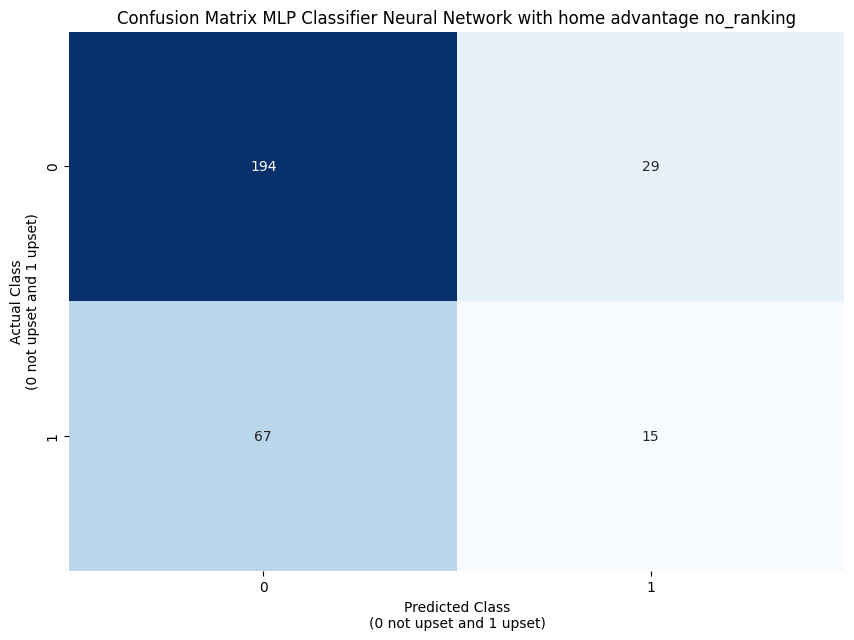

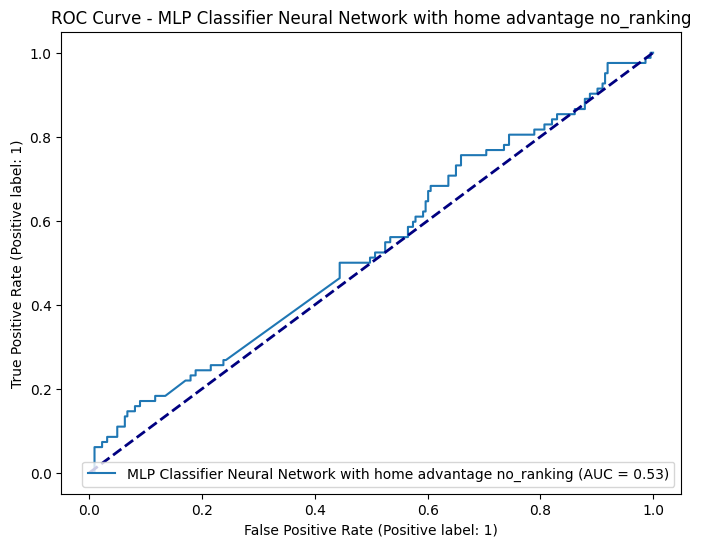

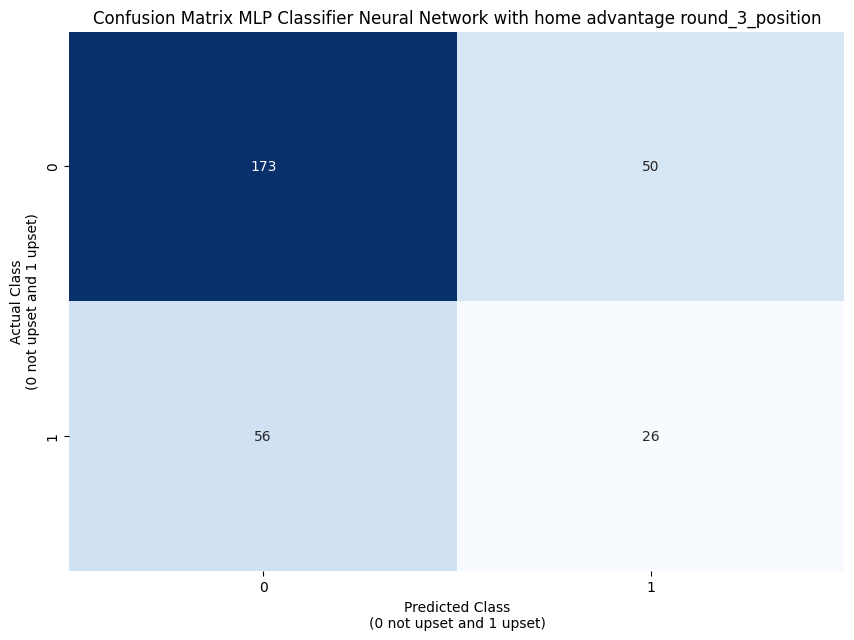

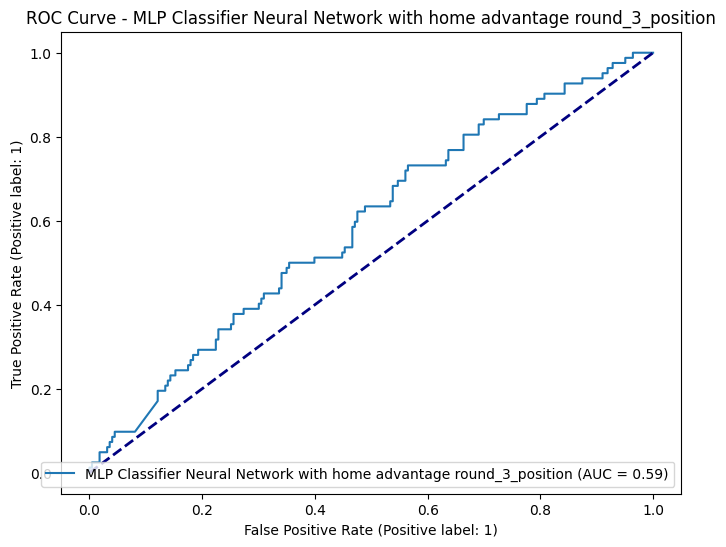

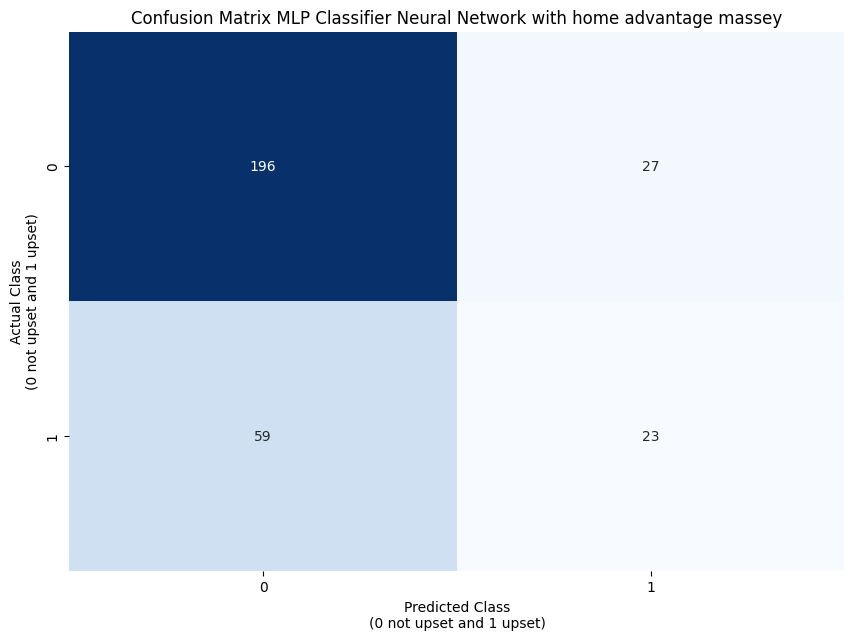

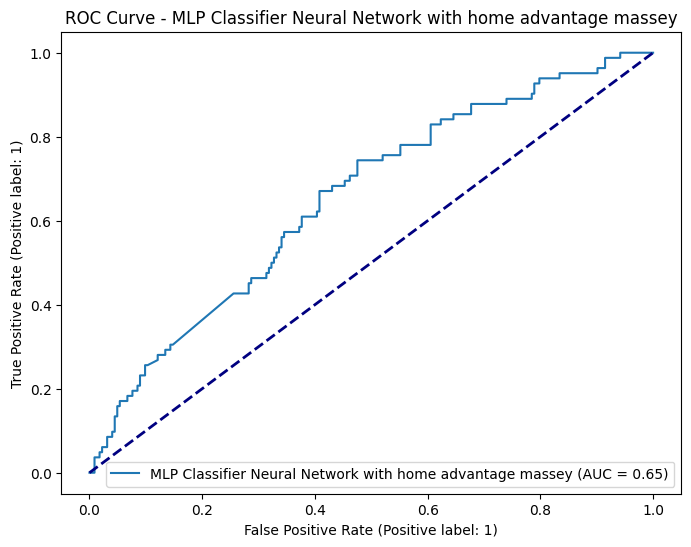

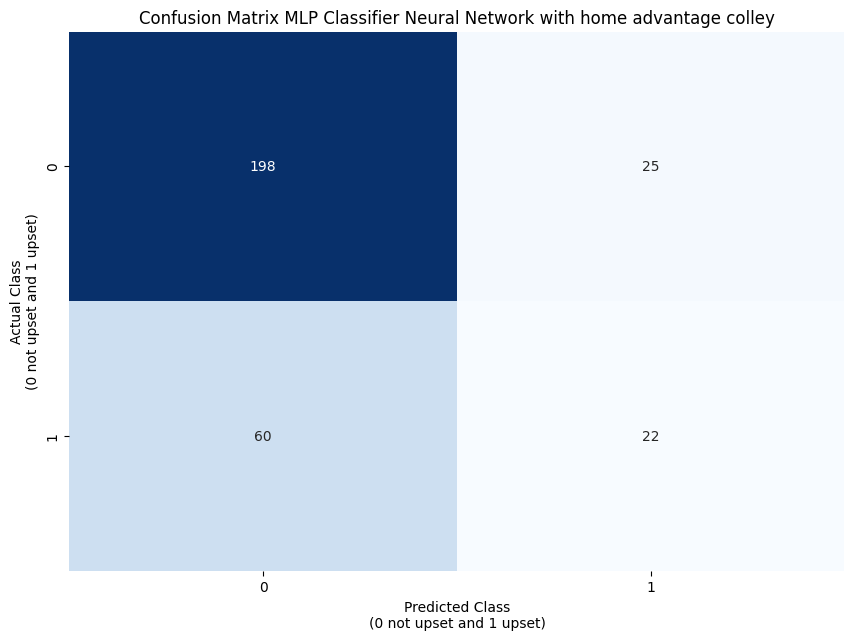

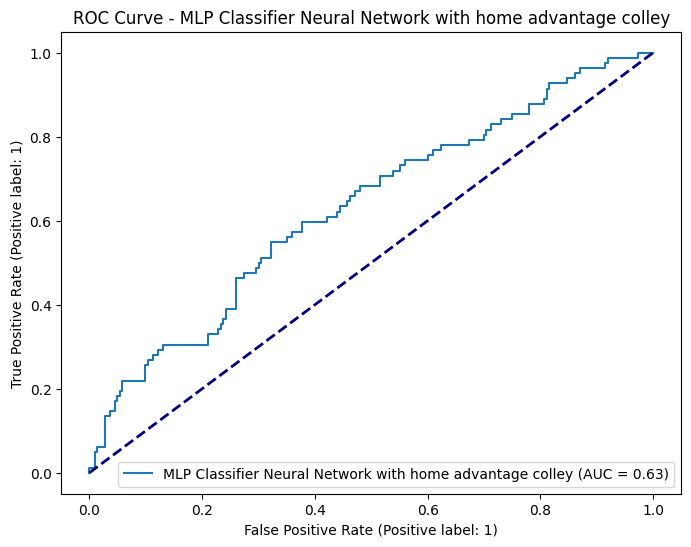

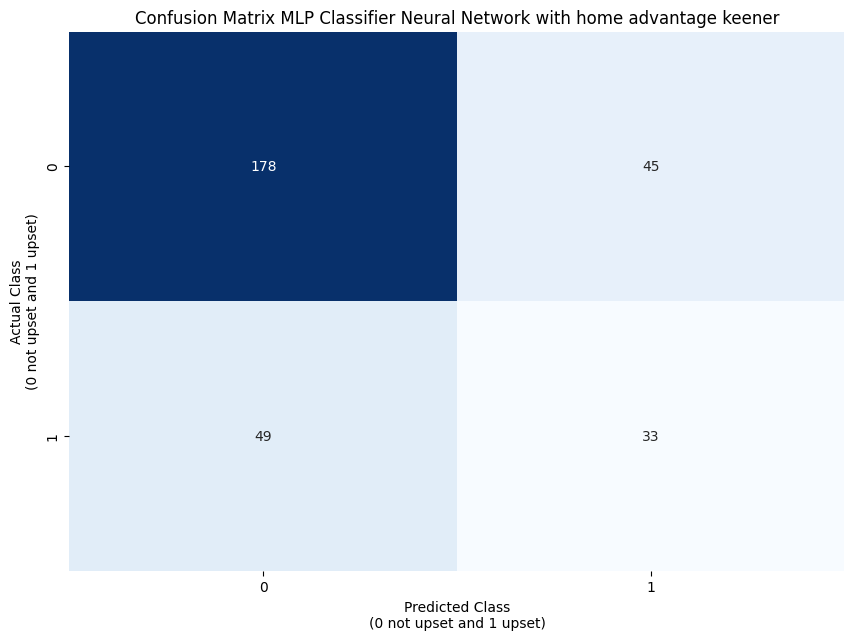

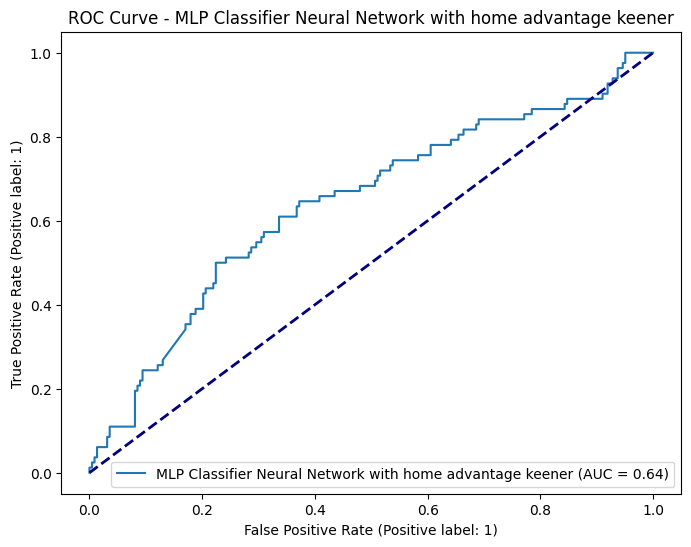

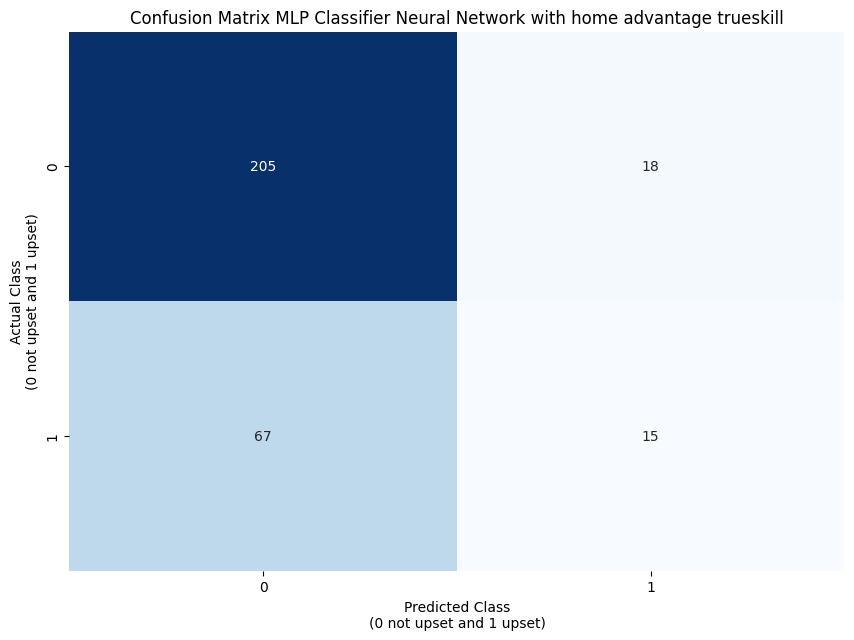

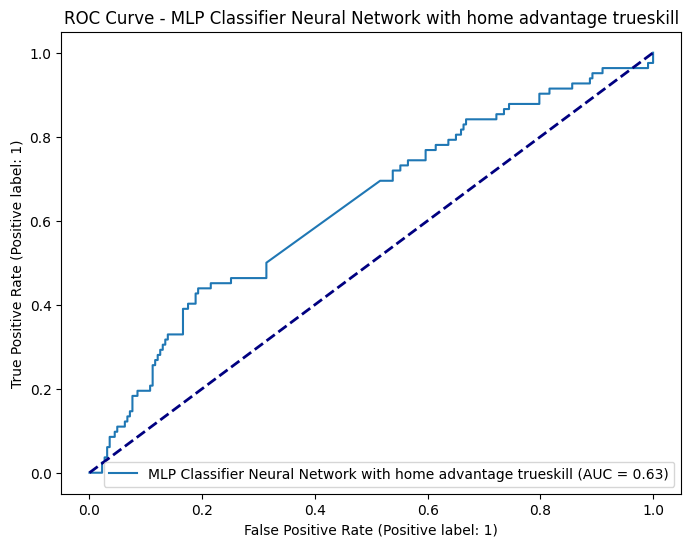

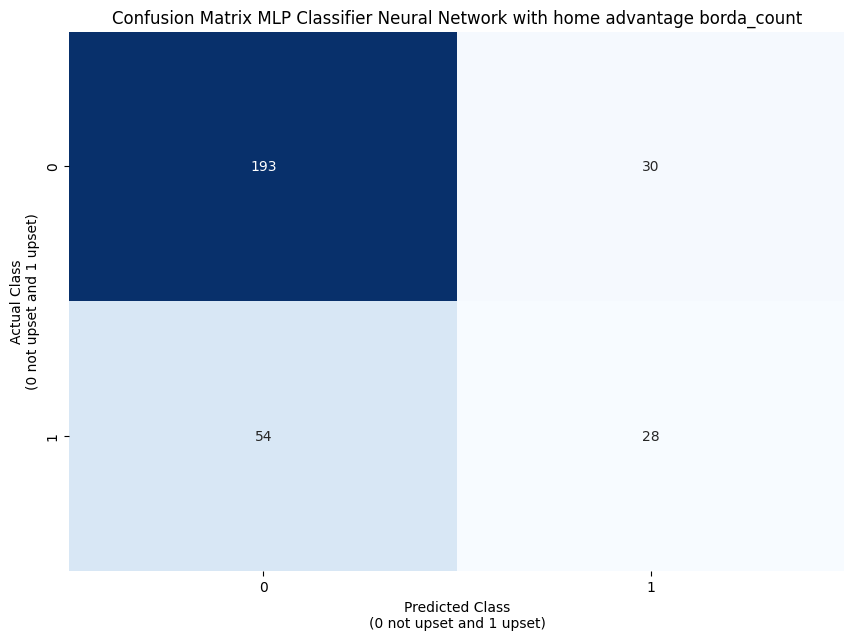

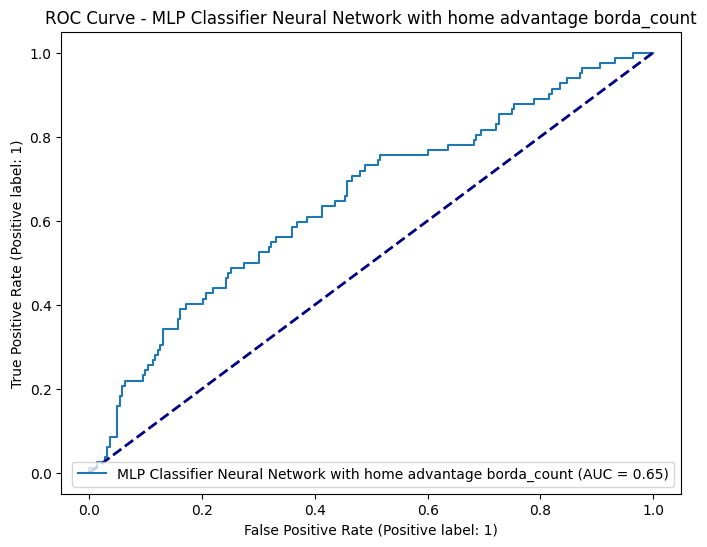

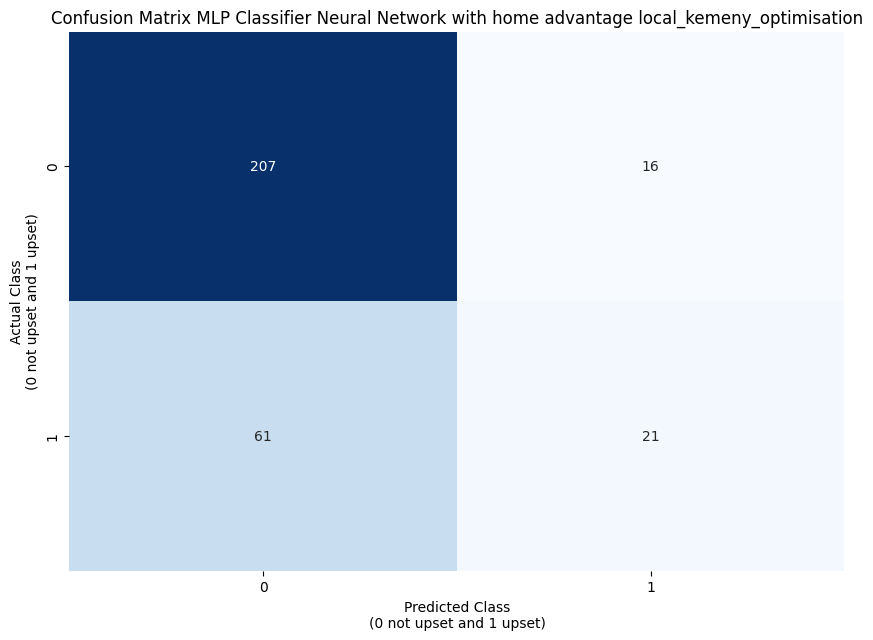

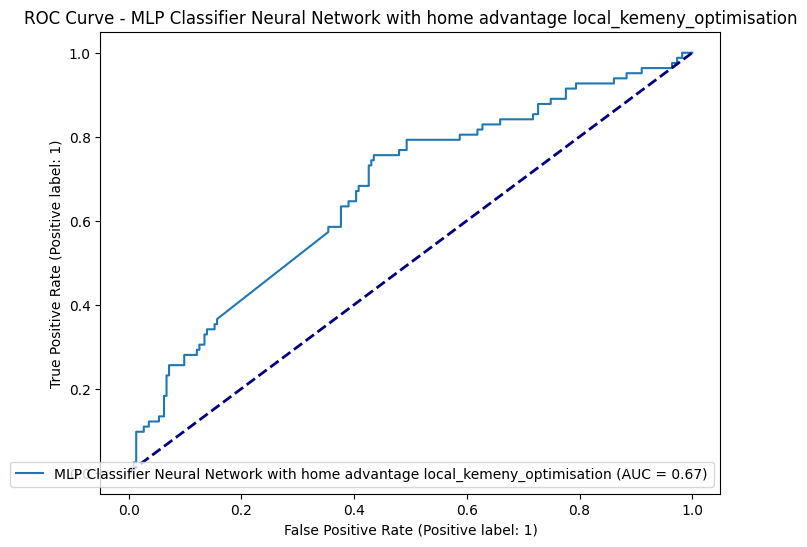

In [ ]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

Random Forest Classifier no_ranking
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.167
Fold 1 Train Accuracy: 1.000, test Accuracy: 0.738
Fold 1 Train Recall: 1.000

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   Random Forest Classifier no_ranking  \
0                                0.998   
1                                0.002   
2                                0.702   
3                                0.024   
4                                0.994   
5                                0.007   
6                                0.160   
7                                0.094   
8                                0.162   
9                                0.627   
10                               0.702   
11                             201.000   
12                              22.000   
13                              69.000   
14                              13.000   
15                               0.744   
16                               0.901   
17                               0.815   
18                               0.371   
19                               0.159   
20                               0.222   
21                               0.558   
22                               0.530   
23                               0.519   
24                               0.644   
25                               0.702   
26                               0.656   
27                               0.579   

   Random Forest Classifier round_3_position Random Forest Classifier massey  \
0                                      1.000                           0.986   
1                                      0.000                           0.022   
2                                      0.728                           0.721   
3                                      0.022                           0.015   
4                                      1.000                           0.948   
5                                      0.000                           0.082   
6                                      0.173                           0.161   
7                                      0.085                           0.103   
8                                      0.162                           0.193   
9                                      0.

Model Name Ranking  Fold  \
0                 Random Forest Classifier no_ranking     1   
1                 Random Forest Classifier no_ranking     2   
2                 Random Forest Classifier no_ranking     3   
3                 Random Forest Classifier no_ranking     4   
4                 Random Forest Classifier no_ranking     5   
5           Random Forest Classifier round_3_position     1   
6           Random Forest Classifier round_3_position     2   
7           Random Forest Classifier round_3_position     3   
8           Random Forest Classifier round_3_position     4   
9           Random Forest Classifier round_3_position     5   
10                    Random Forest Classifier massey     1   
11                    Random Forest Classifier massey     2   
12                    Random Forest Classifier massey     3   
13                    Random Forest Classifier massey     4   
14                    Random Forest Classifier massey     5   
15                    Random Forest Classifier colley     1   
16                    Random Forest Classifier colley     2   
17                    Random Forest Classifier colley     3   
18                    Random Forest Classifier colley     4   
19                    Random Forest Classifier colley     5   
20                    Random Forest Classifier keener     1   
21                    Random Forest Classifier keener     2   
22                    Random Forest Classifier keener     3   
23                    Random Forest Classifier keener     4   
24                    Random Forest Classifier keener     5   
25                 Random Forest Classifier trueskill     1   
26                 Random Forest Classifier trueskill     2   
27                 Random Forest Classifier trueskill     3   
28                 Random Forest Classifier trueskill     4   
29                 Random Forest Classifier trueskill     5   
30               Random Forest Classifier borda_count     1   
31               Random Forest Classifier borda_count     2   
32               Random Forest Classifier borda_count     3   
33               Random Forest Classifier borda_count     4   
34               Random Forest Classifier borda_count     5   
35  Random Forest Classifier local_kemeny_optimisa...     1   
36  Random Forest Classifier local_kemeny_optimisa...     2   
37  Random Forest Classifier local_kemeny_optimisa...     3   
38  Random Forest Classifier local_kemeny_optimisa...     4   
39  Random Forest Classifier local_kemeny_optimisa...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__max_features': None, 'classifier...   
1   {'classifier__max_features': None, 'classifier...   
2   {'classifier__max_features': None, 'classifier...   
3   {'classifier__max_features': None, 'classifier...   
4   {'classifier__max_features': None, 'classifier...   
5   {'classifier__max_features': None, 'classifier...   
6   {'classifier__max_features': None, 'classifier...   
7   {'classifier__max_features': None, 'classifier...   
8   {'classifier__max_features': None, 'classifier...   
9   {'classifier__max_features': None, 'classifier...   
10  {'classifier__max_features': None, 'classifier...   
11  {'classifier__max_features': None, 'classifier...   
12  {'classifier__max_features': None, 'classifier...   
13  {'classifier__max_features': None, 'classifier...   
14  {'classifier__max_features': None, 'classifier...   
15  {'classifier__max_features': None, 'classifier...   
16  {'classifier__max_features': None, 'classifier...   
17  {'classifier__max_features': None, 'classifier...   
18  {'classifier__max_features': None, 'classifier...   
19  {'classifier__max_features': None, 'classifier...   
20  {'classifier__max_features': None, 'classifier...   
21  {'classifier__max_features': None, 'classifier...   
22  {'classifier__max_features': None, 'classifier...   
23  {'classifier__max_features': None, 'classifier...   
24  {'classifier__max_feat

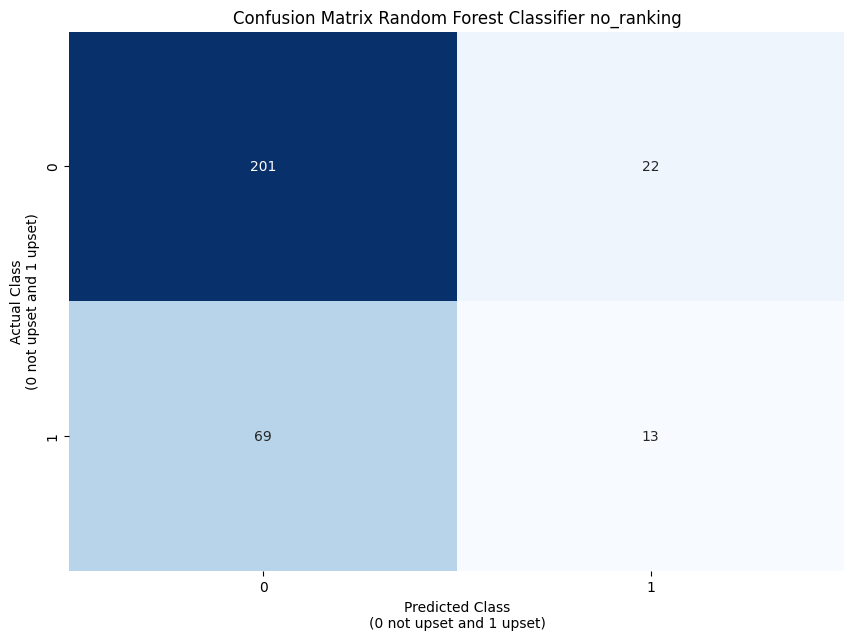

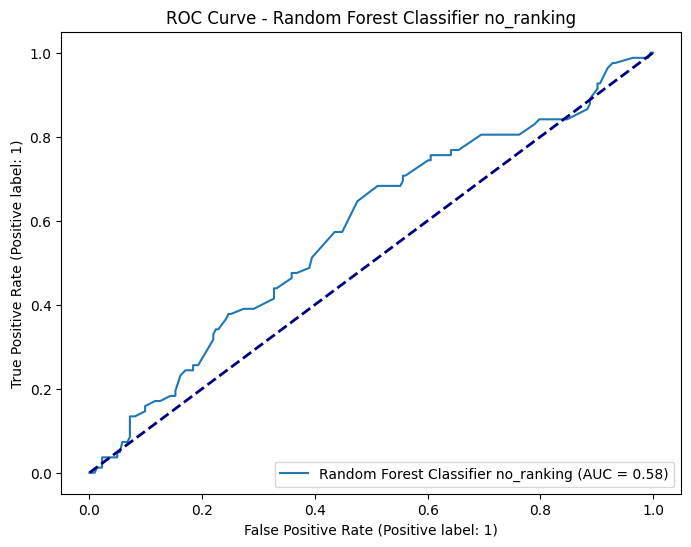

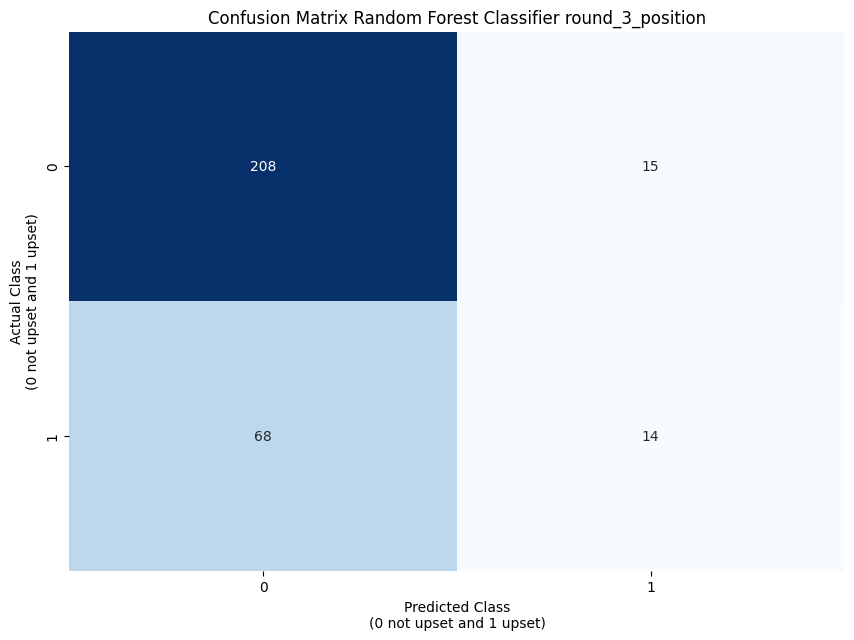

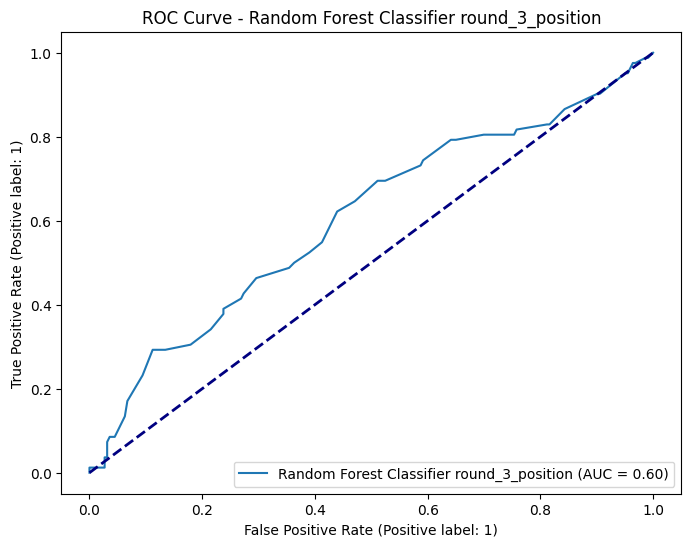

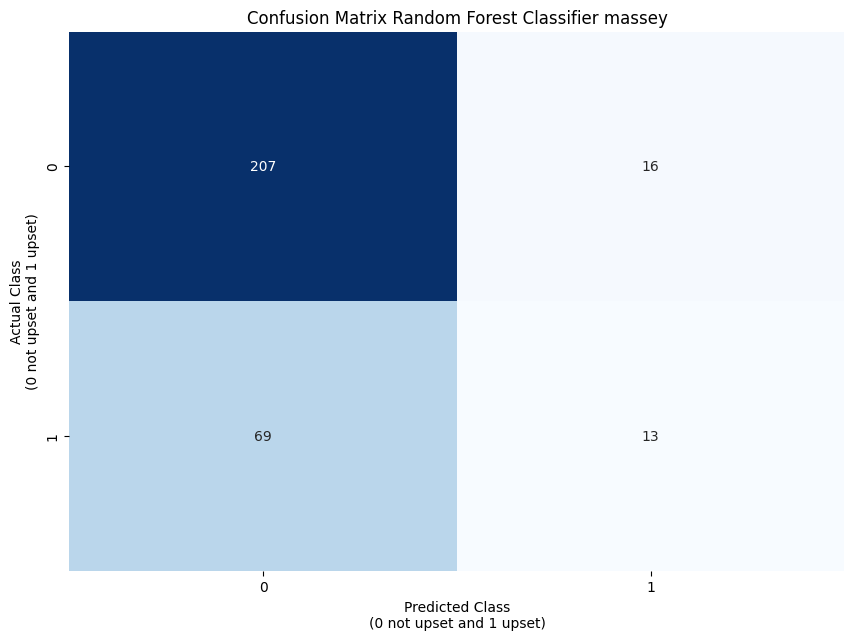

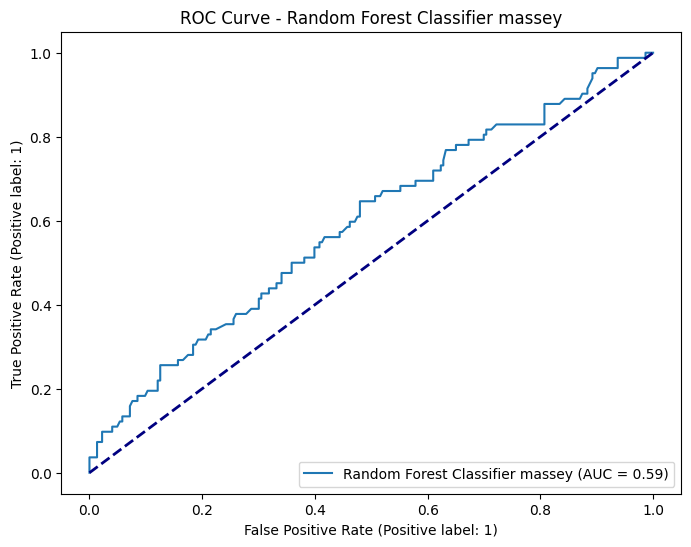

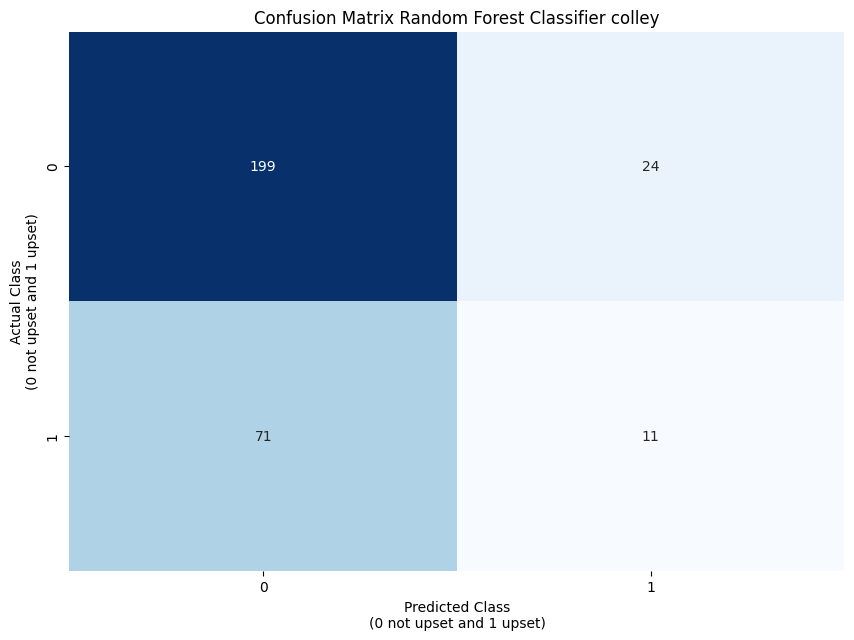

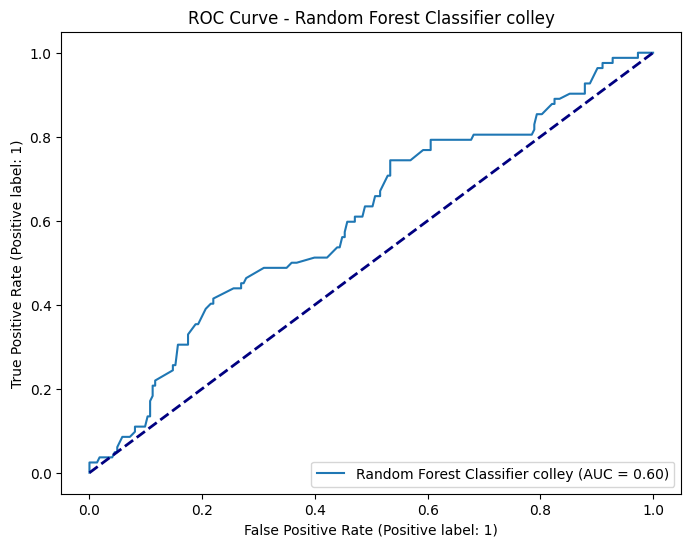

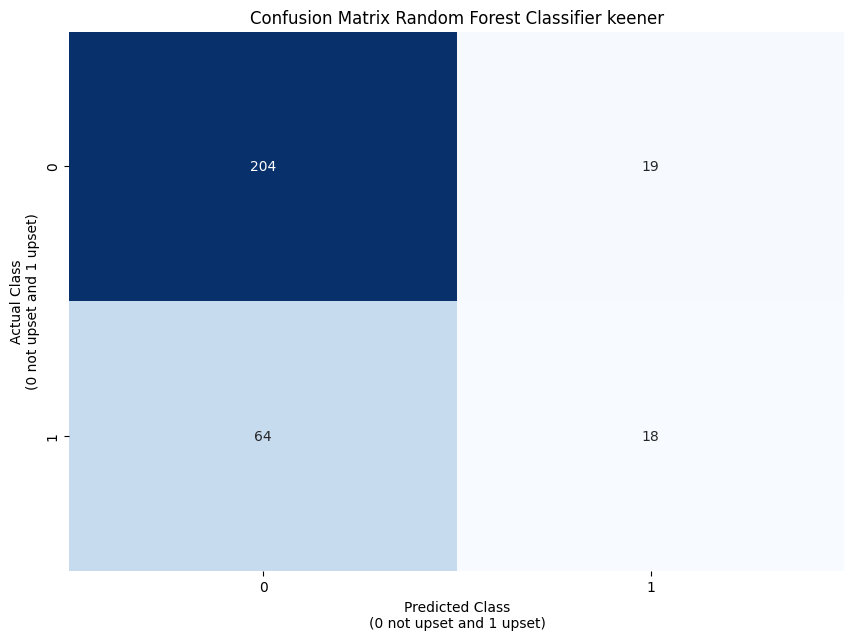

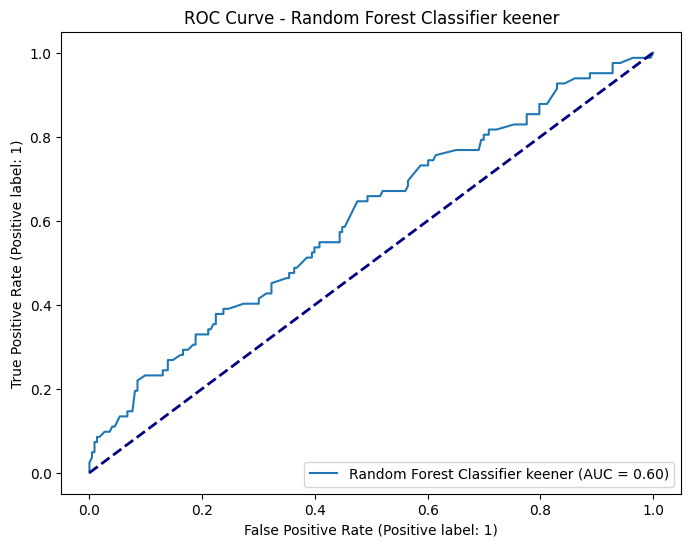

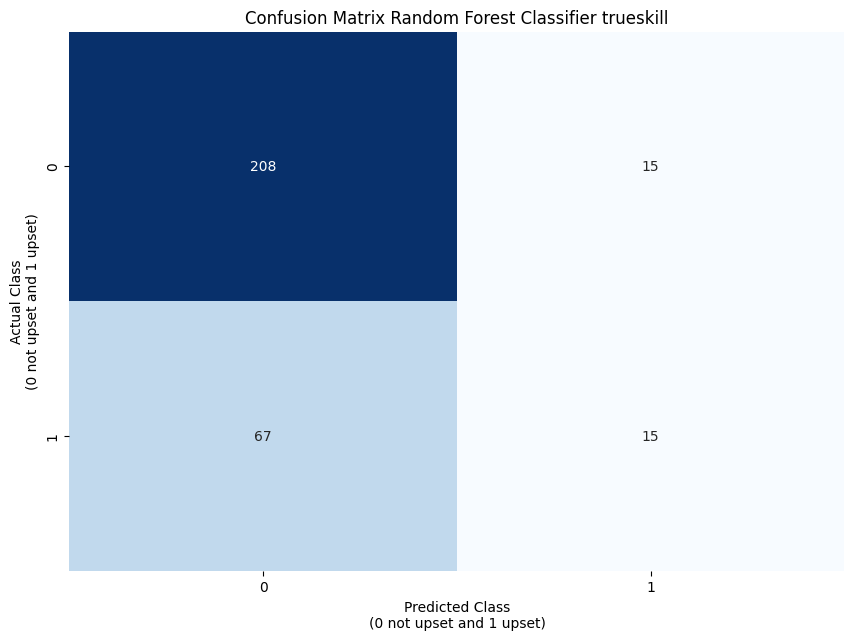

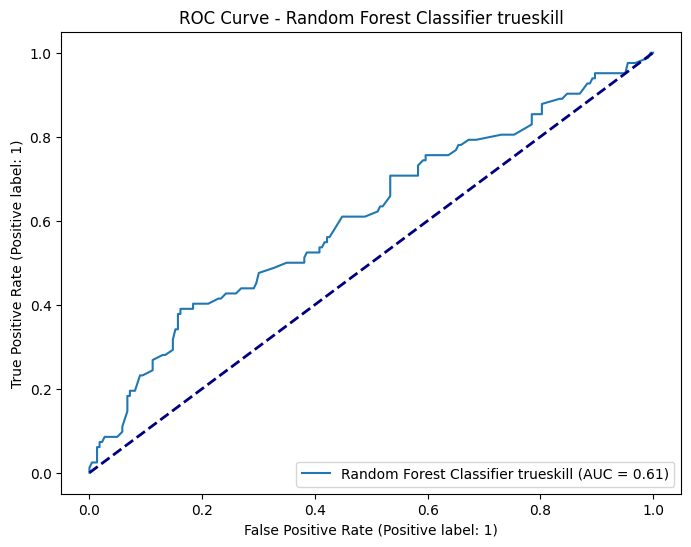

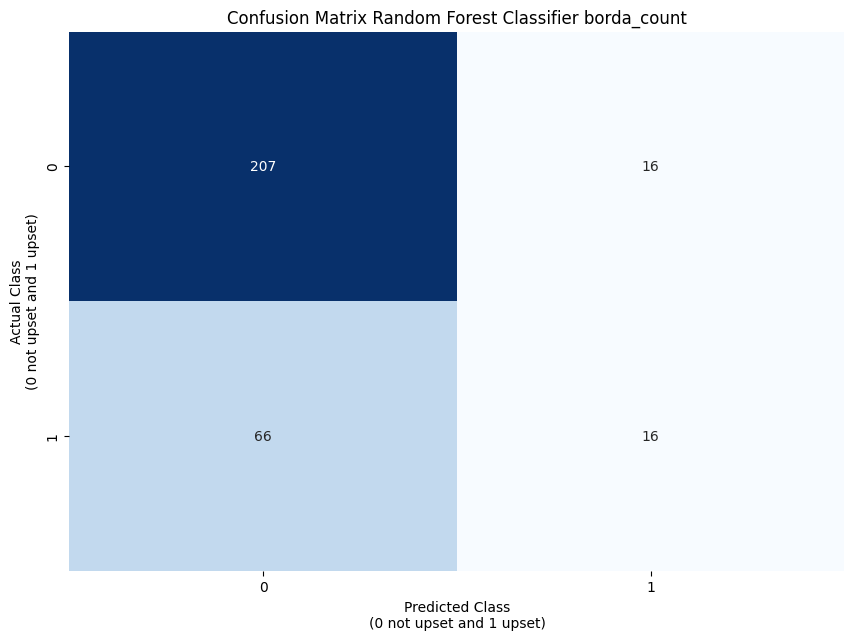

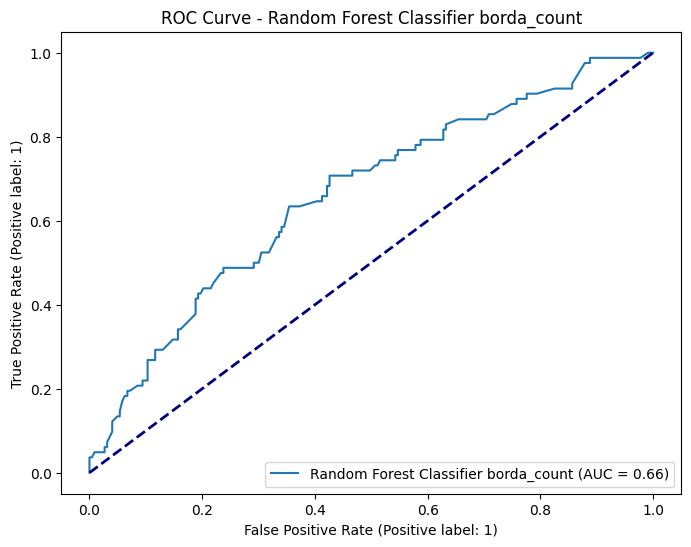

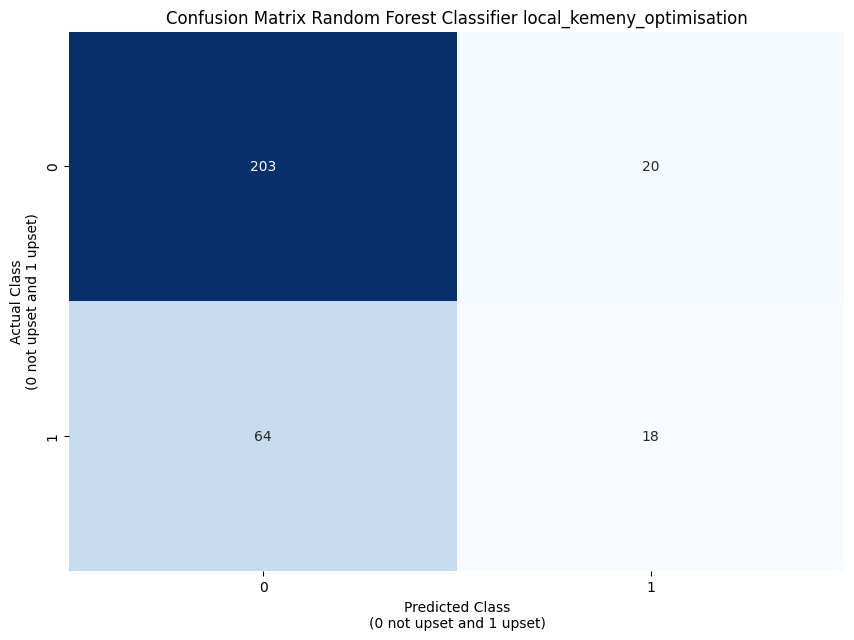

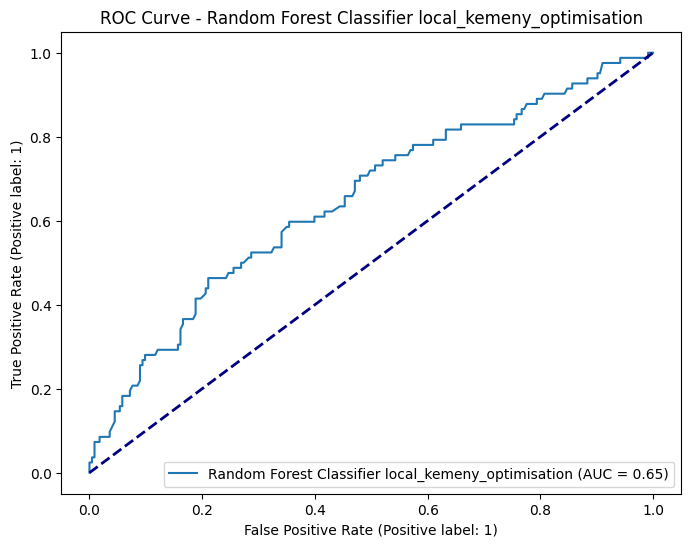

In [ ]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


Random Forest Classifier with home advantage no_ranking
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.288
Fold 1 Train Accuracy: 0.988, test Accu

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   Random Forest Classifier with home advantage no_ranking  \
0                                               0.998        
1                                               0.005        
2                                               0.689        
3                                               0.037        
4                                               0.991        
5                                               0.018        
6                                               0.147        
7                                               0.122        
8                                               0.163        
9                                               0.576        
10                                              0.689        
11                                            198.000        
12                                             25.000        
13                                             70.000        
14                                             12.000        
15                                              0.739        
16                                              0.888        
17                                              0.807        
18                                              0.324        
19                                              0.146        
20                                              0.202        
21                                              0.532        
22                                              0.517        
23                                              0.504        
24                                              0.627        
25                                              0.689        
26                                              0.644        
27                                              0.637        

   Random Forest Classifier with home advantage round_3_position  \
0                                               0.993              
1                                               0.009              
2                                               0.715    

Model Name Ranking  Fold  \
0   Random Forest Classifier with home advantage n...     1   
1   Random Forest Classifier with home advantage n...     2   
2   Random Forest Classifier with home advantage n...     3   
3   Random Forest Classifier with home advantage n...     4   
4   Random Forest Classifier with home advantage n...     5   
5   Random Forest Classifier with home advantage r...     1   
6   Random Forest Classifier with home advantage r...     2   
7   Random Forest Classifier with home advantage r...     3   
8   Random Forest Classifier with home advantage r...     4   
9   Random Forest Classifier with home advantage r...     5   
10  Random Forest Classifier with home advantage m...     1   
11  Random Forest Classifier with home advantage m...     2   
12  Random Forest Classifier with home advantage m...     3   
13  Random Forest Classifier with home advantage m...     4   
14  Random Forest Classifier with home advantage m...     5   
15  Random Forest Classifier with home advantage c...     1   
16  Random Forest Classifier with home advantage c...     2   
17  Random Forest Classifier with home advantage c...     3   
18  Random Forest Classifier with home advantage c...     4   
19  Random Forest Classifier with home advantage c...     5   
20  Random Forest Classifier with home advantage k...     1   
21  Random Forest Classifier with home advantage k...     2   
22  Random Forest Classifier with home advantage k...     3   
23  Random Forest Classifier with home advantage k...     4   
24  Random Forest Classifier with home advantage k...     5   
25  Random Forest Classifier with home advantage t...     1   
26  Random Forest Classifier with home advantage t...     2   
27  Random Forest Classifier with home advantage t...     3   
28  Random Forest Classifier with home advantage t...     4   
29  Random Forest Classifier with home advantage t...     5   
30  Random Forest Classifier with home advantage b...     1   
31  Random Forest Classifier with home advantage b...     2   
32  Random Forest Classifier with home advantage b...     3   
33  Random Forest Classifier with home advantage b...     4   
34  Random Forest Classifier with home advantage b...     5   
35  Random Forest Classifier with home advantage l...     1   
36  Random Forest Classifier with home advantage l...     2   
37  Random Forest Classifier with home advantage l...     3   
38  Random Forest Classifier with home advantage l...     4   
39  Random Forest Classifier with home advantage l...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__max_features': None, 'classifier...   
1   {'classifier__max_features': None, 'classifier...   
2   {'classifier__max_features': 'sqrt', 'classifi...   
3   {'classifier__max_features': 'sqrt', 'classifi...   
4   {'classifier__max_features': 'sqrt', 'classifi...   
5   {'classifier__max_features': None, 'classifier...   
6   {'classifier__max_features': None, 'classifier...   
7   {'classifier__max_features': 'sqrt', 'classifi...   
8   {'classifier__max_features': None, 'classifier...   
9   {'classifier__max_features': 'sqrt', 'classifi...   
10  {'classifier__max_features': 'sqrt', 'classifi...   
11  {'classifier__max_features': None, 'classifier...   
12  {'classifier__max_features': 'sqrt', 'classifi...   
13  {'classifier__max_features': 'sqrt', 'classifi...   
14  {'classifier__max_features': 'sqrt', 'classifi...   
15  {'classifier__max_features': 'sqrt', 'classifi...   
16  {'classifier__max_features': 'sqrt', 'classifi...   
17  {'classifier__max_features': 'sqrt', 'classifi...   
18  {'classifier__max_features': 'sqrt', 'classifi...   
19  {'classifier__max_features': 'sqrt', 'classifi...   
20  {'classifier__max_features': 'sqrt', 'classifi...   
21  {'classifier__max_features': 'sqrt', 'classifi...   
22  {'classifier__max_features': 'sqrt', 'classifi...   
23  {'classifier__max_features': 'sqrt', 'classifi...   
24  {'classifier__max_feat

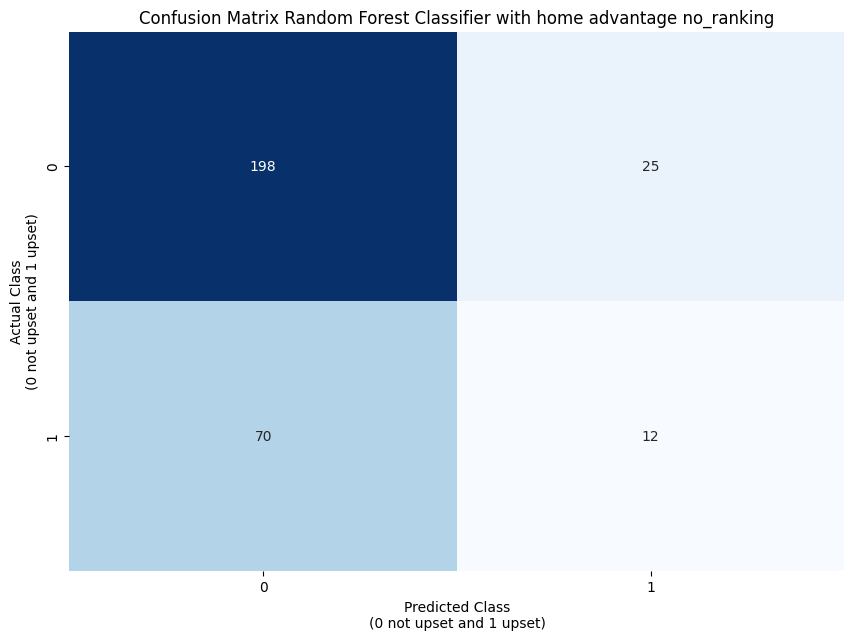

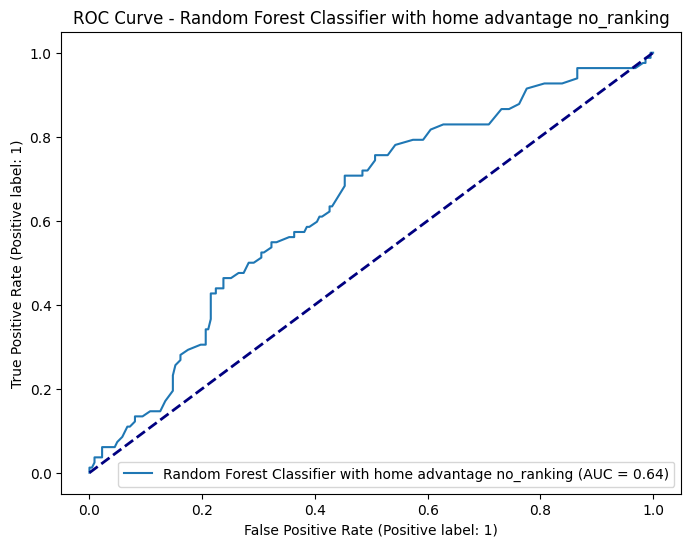

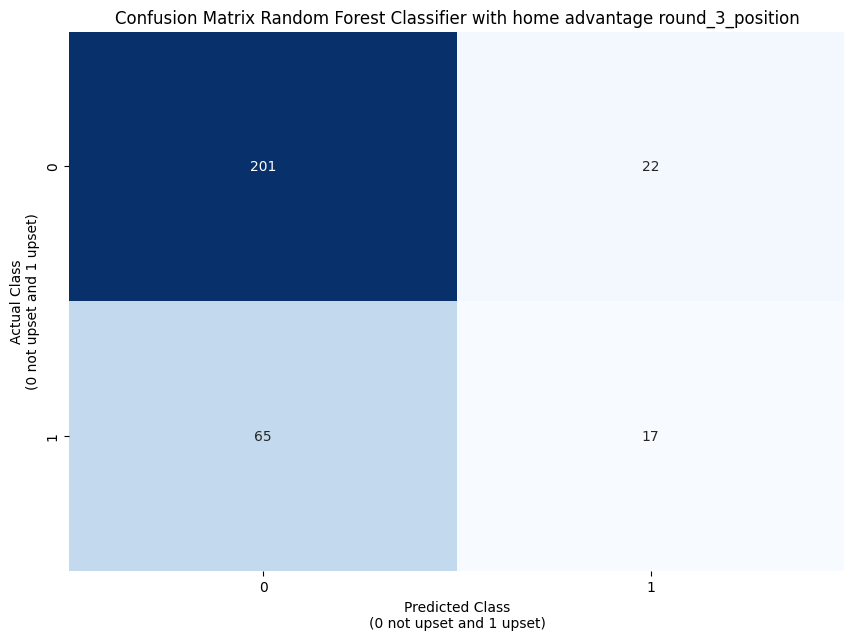

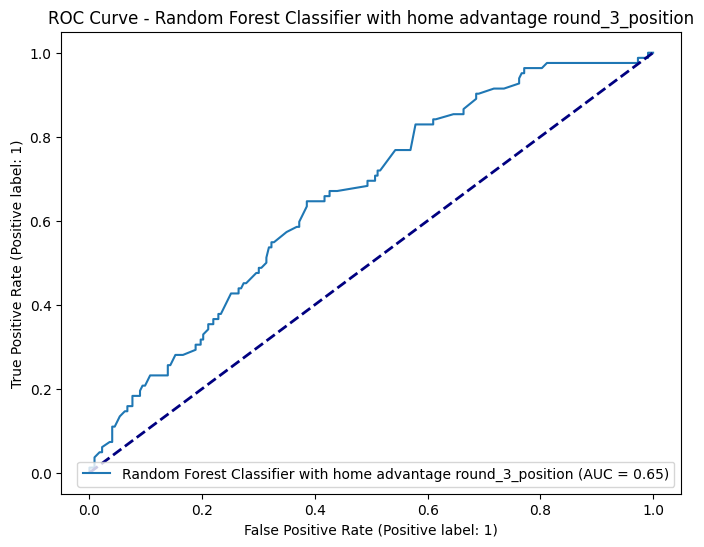

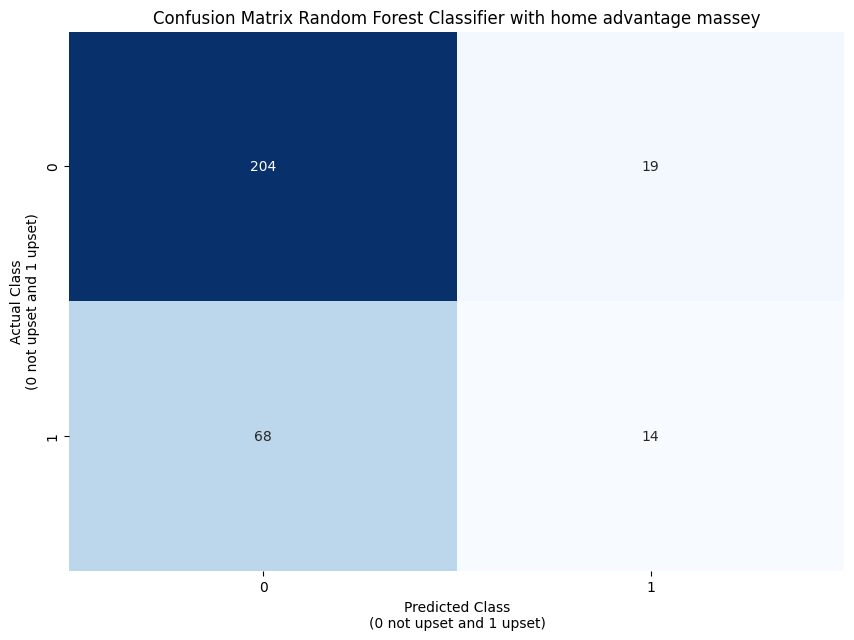

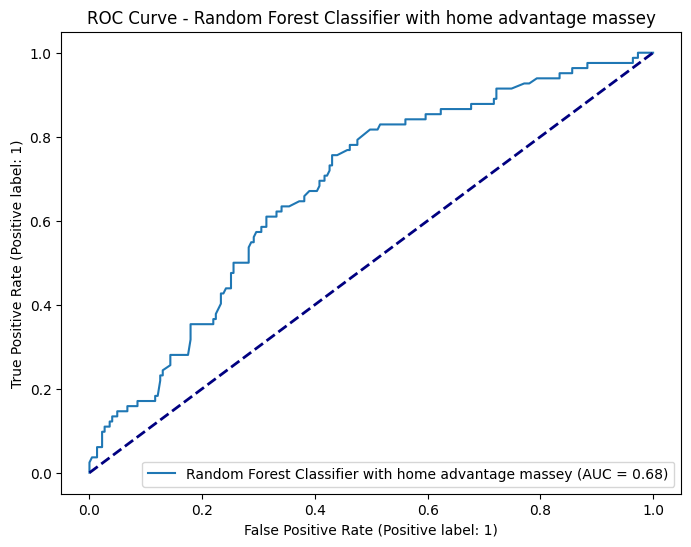

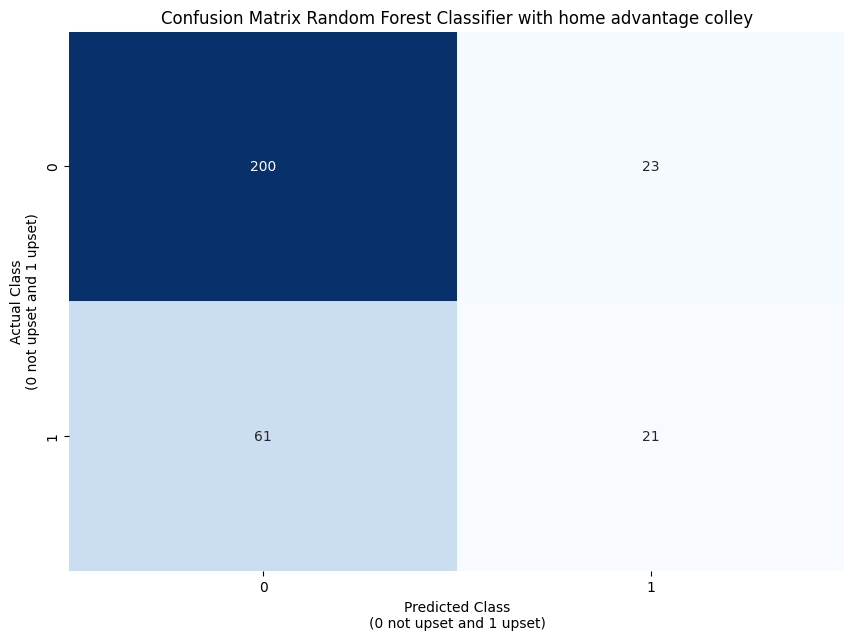

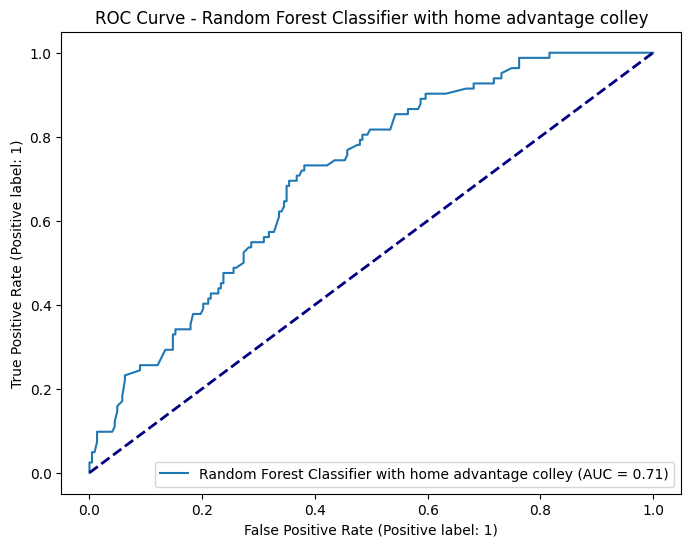

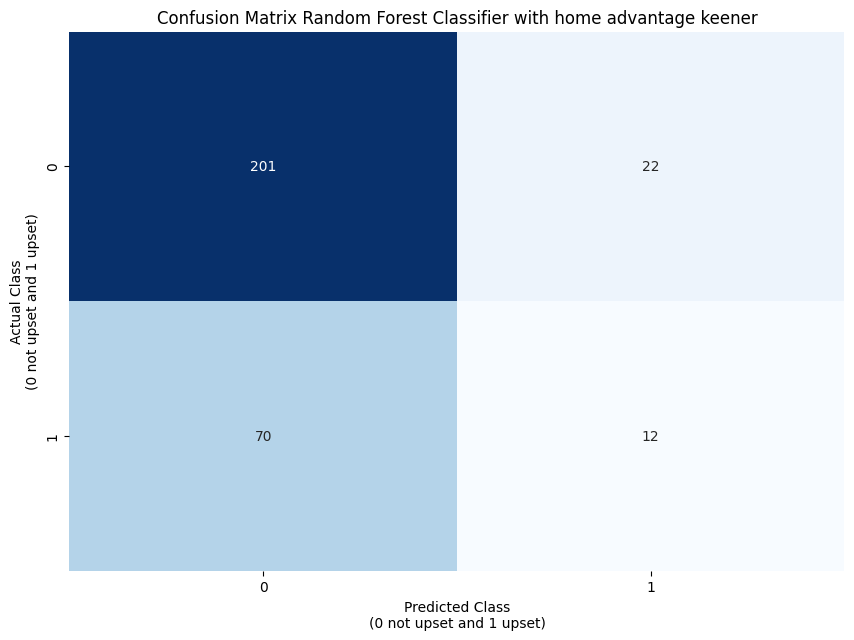

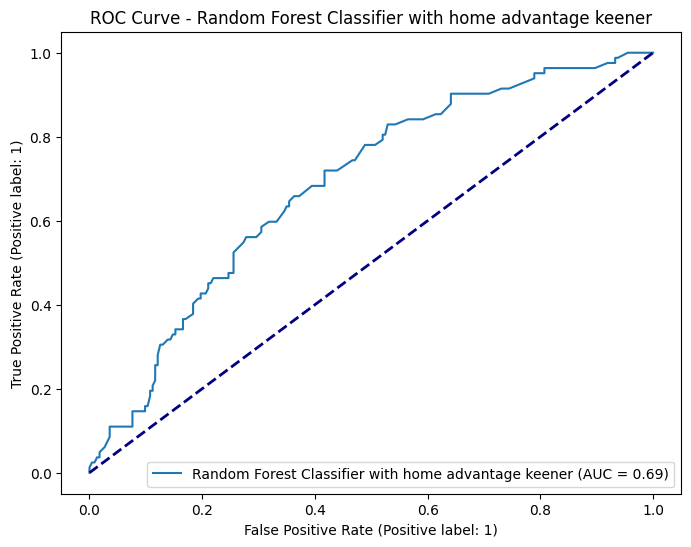

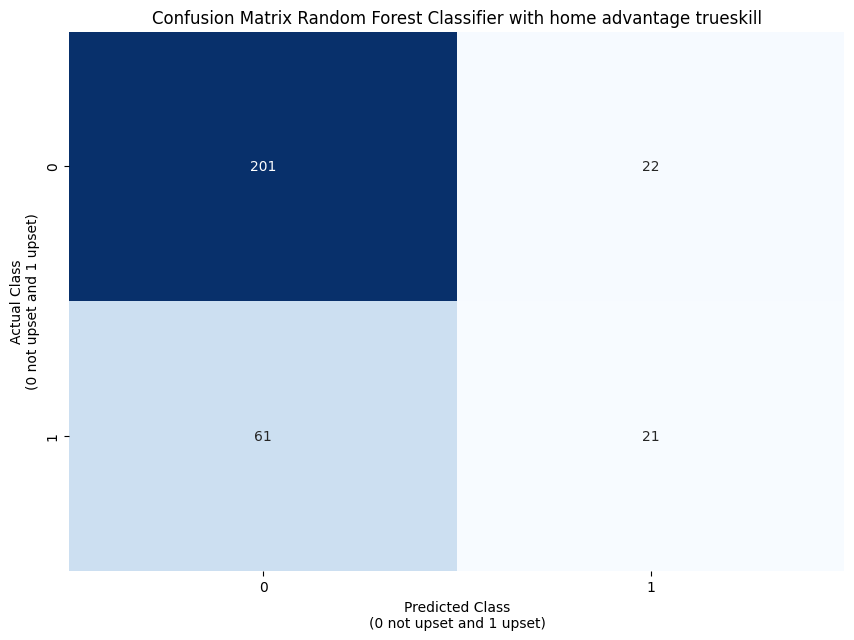

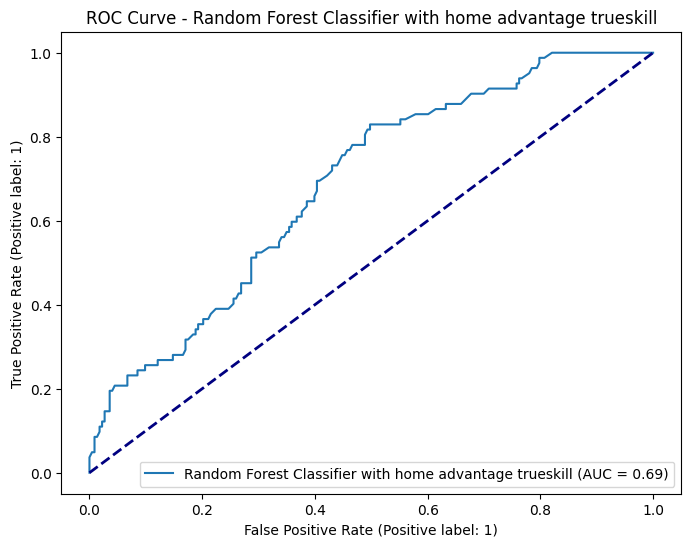

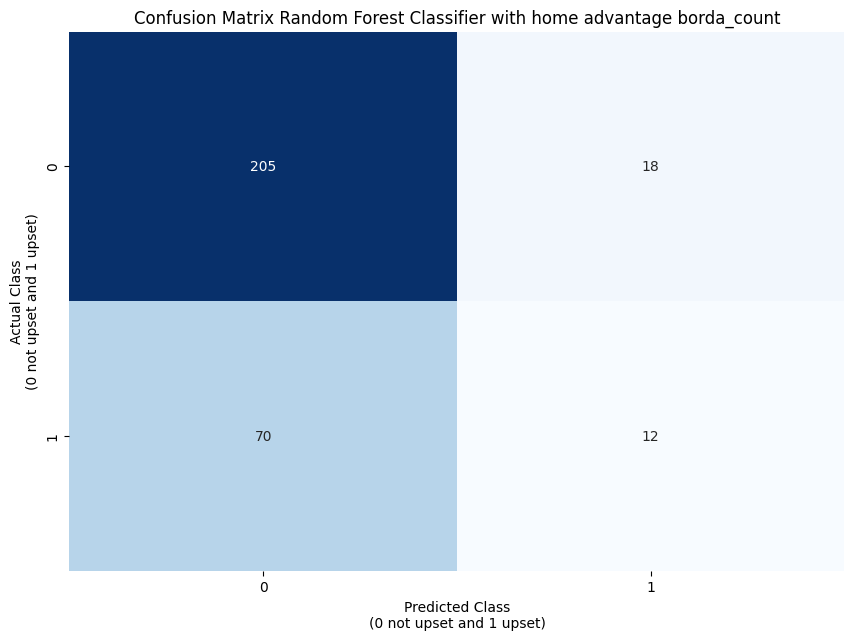

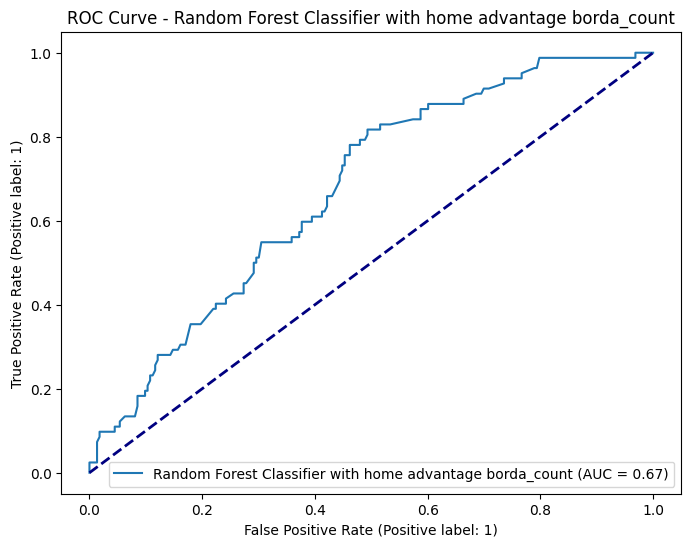

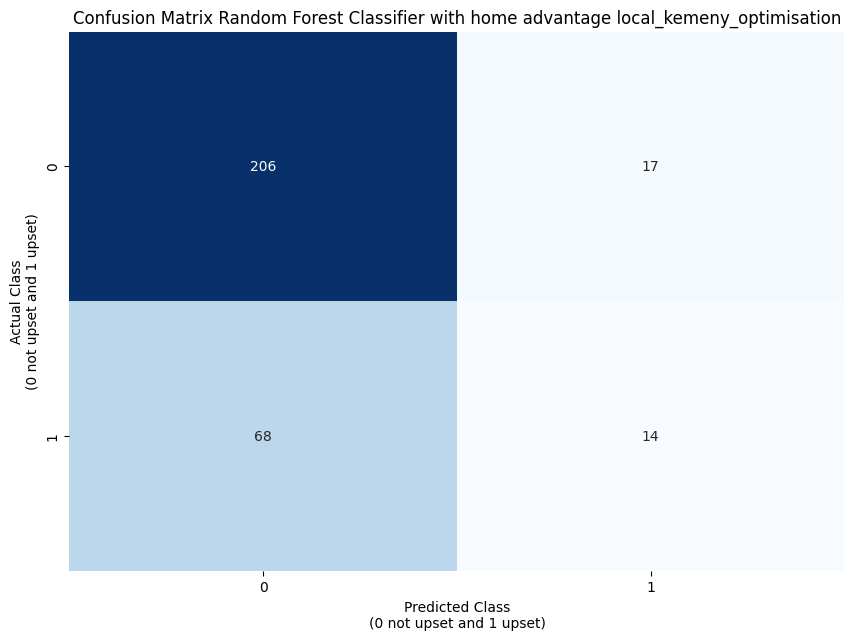

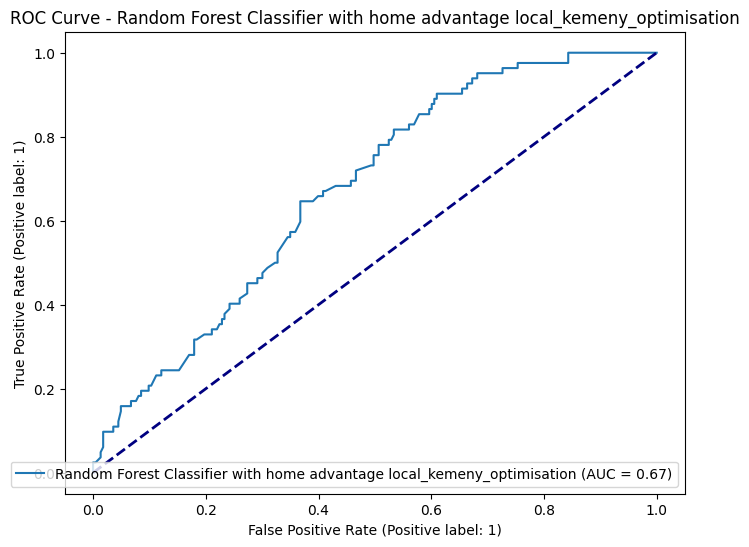

In [ ]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rfh = all_results_df
display(all_results_df_rfh)

fold_results_df_rfh = fold_results_df
display(fold_results_df_rfh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rfh.to_excel("all_rfh_results.xlsx")
fold_results_df_rfh.to_excel("fold_results_rfh.xlsx")

XG Boost no_ranking
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 0.8}
Best Estimator's Recall (from GridSearchCV): 0.167
Fold 1 Train Accuracy: 0.996, t

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   XG Boost no_ranking XG Boost round_3_position XG Boost massey  \
0                0.975                     0.937           0.989   
1                0.023                     0.100           0.011   
2                0.685                     0.689           0.682   
3                0.032                     0.049           0.042   
4                0.905                     0.766           0.963   
5                0.086                     0.370           0.035   
6                0.210                     0.149           0.210   
7                0.096                     0.141           0.136   
8                0.180                     0.219           0.135   
9                0.735                     0.671           0.680   
10               0.685                     0.689           0.682   
11             192.000                   198.000         191.000   
12              31.000                    25.000          32.000   
13              65.000                    70.000          65.000   
14              17.000                    12.000          17.000   
15               0.747                     0.739           0.746   
16               0.861                     0.888           0.857   
17               0.800                     0.807           0.797   
18               0.354                     0.324           0.347   
19               0.207                     0.146           0.207   
20               0.262                     0.202           0.260   
21               0.551                     0.532           0.547   
22               0.534                     0.517           0.532   
23               0.531                     0.504           0.529   
24               0.641                     0.627           0.639   
25               0.685                     0.689           0.682   
26               0.655                     0.644           0.653   
27               0.517                     0.567           0.600   

   XG Boost colley XG Boost keener XG Boost trueskill XG Boost borda_count  \
0        

Model Name Ranking  Fold  \
0                  XG Boost no_ranking     1   
1                  XG Boost no_ranking     2   
2                  XG Boost no_ranking     3   
3                  XG Boost no_ranking     4   
4                  XG Boost no_ranking     5   
5            XG Boost round_3_position     1   
6            XG Boost round_3_position     2   
7            XG Boost round_3_position     3   
8            XG Boost round_3_position     4   
9            XG Boost round_3_position     5   
10                     XG Boost massey     1   
11                     XG Boost massey     2   
12                     XG Boost massey     3   
13                     XG Boost massey     4   
14                     XG Boost massey     5   
15                     XG Boost colley     1   
16                     XG Boost colley     2   
17                     XG Boost colley     3   
18                     XG Boost colley     4   
19                     XG Boost colley     5   
20                     XG Boost keener     1   
21                     XG Boost keener     2   
22                     XG Boost keener     3   
23                     XG Boost keener     4   
24                     XG Boost keener     5   
25                  XG Boost trueskill     1   
26                  XG Boost trueskill     2   
27                  XG Boost trueskill     3   
28                  XG Boost trueskill     4   
29                  XG Boost trueskill     5   
30                XG Boost borda_count     1   
31                XG Boost borda_count     2   
32                XG Boost borda_count     3   
33                XG Boost borda_count     4   
34                XG Boost borda_count     5   
35  XG Boost local_kemeny_optimisation     1   
36  XG Boost local_kemeny_optimisation     2   
37  XG Boost local_kemeny_optimisation     3   
38  XG Boost local_kemeny_optimisation     4   
39  XG Boost local_kemeny_optimisation     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__colsample_bytree': 1.0, 'classif...   
1   {'classifier__colsample_bytree': 1.0, 'classif...   
2   {'classifier__colsample_bytree': 1.0, 'classif...   
3   {'classifier__colsample_bytree': 0.6, 'classif...   
4   {'classifier__colsample_bytree': 1.0, 'classif...   
5   {'classifier__colsample_bytree': 1.0, 'classif...   
6   {'classifier__colsample_bytree': 0.6, 'classif...   
7   {'classifier__colsample_bytree': 1.0, 'classif...   
8   {'classifier__colsample_bytree': 0.6, 'classif...   
9   {'classifier__colsample_bytree': 0.6, 'classif...   
10  {'classifier__colsample_bytree': 1.0, 'classif...   
11  {'classifier__colsample_bytree': 1.0, 'classif...   
12  {'classifier__colsample_bytree': 1.0, 'classif...   
13  {'classifier__colsample_bytree': 1.0, 'classif...   
14  {'classifier__colsample_bytree': 1.0, 'classif...   
15  {'classifier__colsample_bytree': 1.0, 'classif...   
16  {'classifier__colsample_bytree': 0.6, 'classif...   
17  {'classifier__colsample_bytree': 1.0, 'classif...   
18  {'classifier__colsample_bytree': 1.0, 'classif...   
19  {'classifier__colsample_bytree': 1.0, 'classif...   
20  {'classifier__colsample_bytree': 0.6, 'classif...   
21  {'classifier__colsample_bytree': 1.0, 'classif...   
22  {'classifier__colsample_bytree': 1.0, 'classif...   
23  {'classifier__colsample_bytree': 1.0, 'classif...   
24  {'classifier__colsample_bytree': 0.6, 'classif...   
25  {'classifier__colsample_bytree': 1.0, 'classif...   
26  {'classifier__colsample_bytree': 1.0, 'classif...   
27  {'classifier__colsample_bytree': 1.0, 'classif...   
28  {'classifier__colsample_bytree': 1.0, 'classif...   
29  {'classifier__colsample_bytree': 1.0, 'classif...   
30  {'classifier__colsample_bytree': 1.0, 'classif...   
31  {'classifier__colsample_bytree': 1.0, 'classif...   
32  {'classifier__colsample_bytree': 1.0, 'classif...   
33  {'classifier__colsample_bytree': 1.0, 'classif...   
34  {'classifier__colsample_bytree': 1.0, 'classif...   

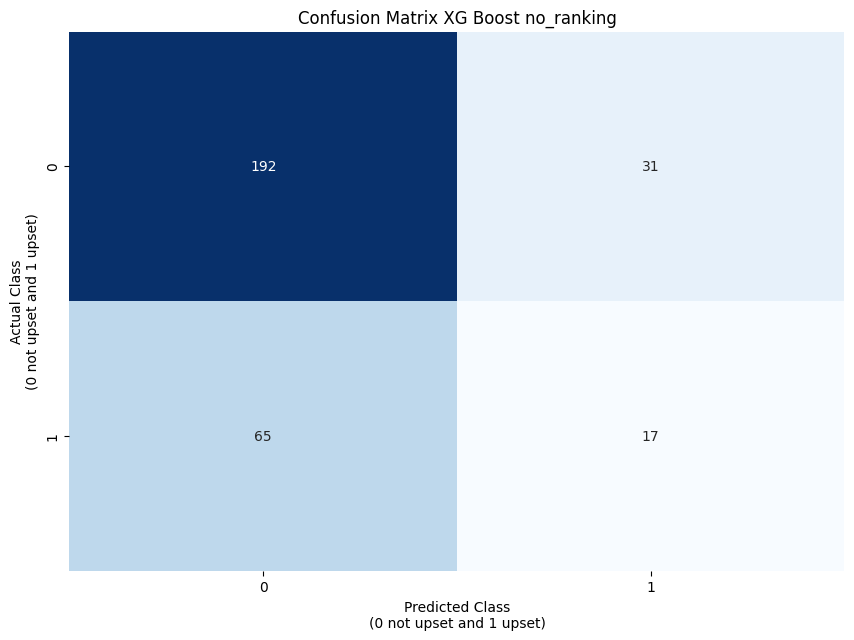

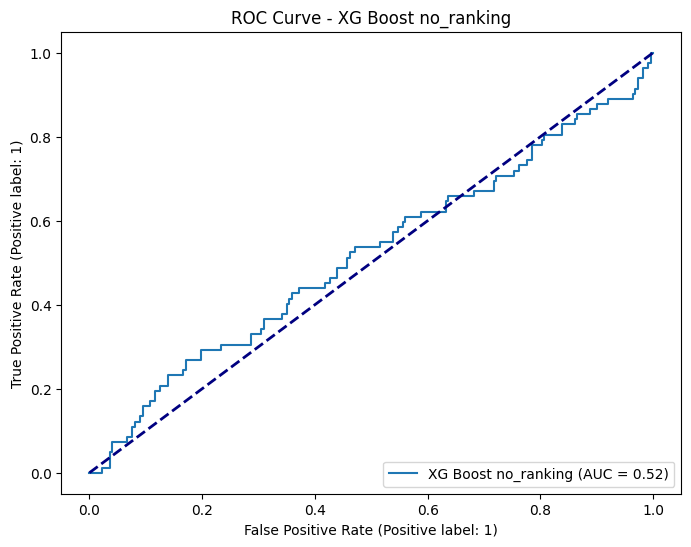

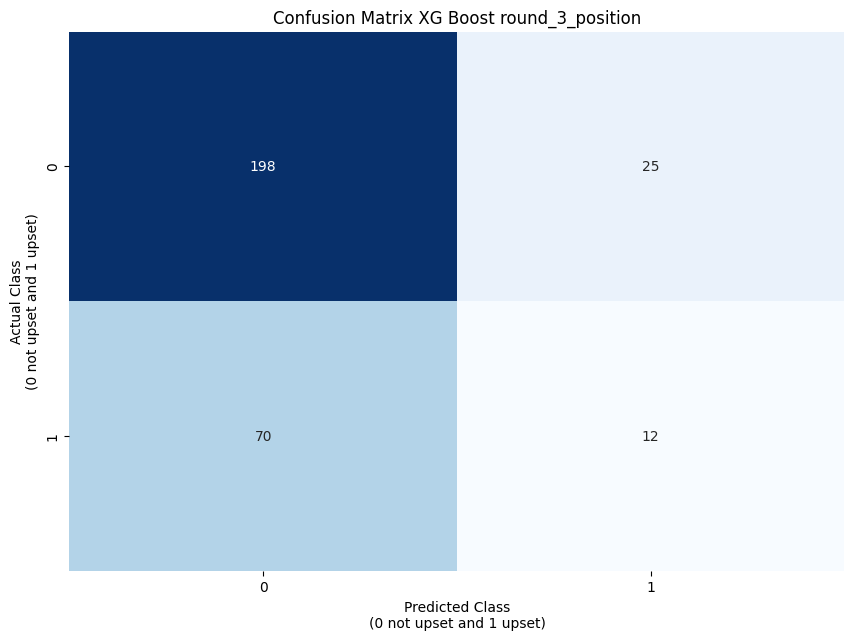

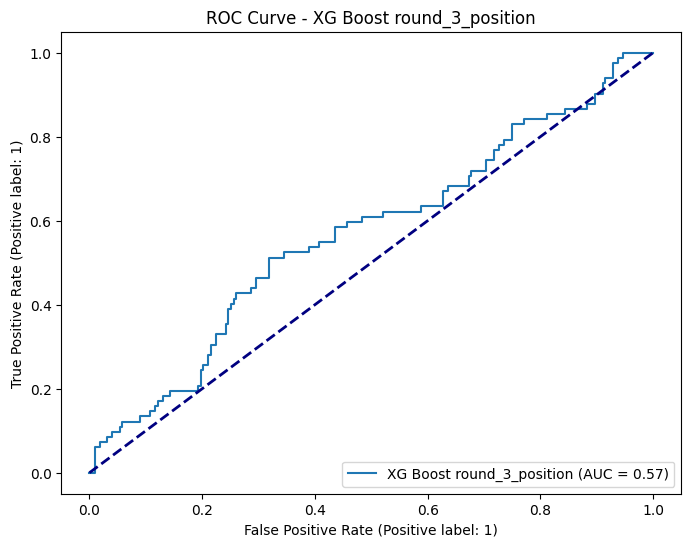

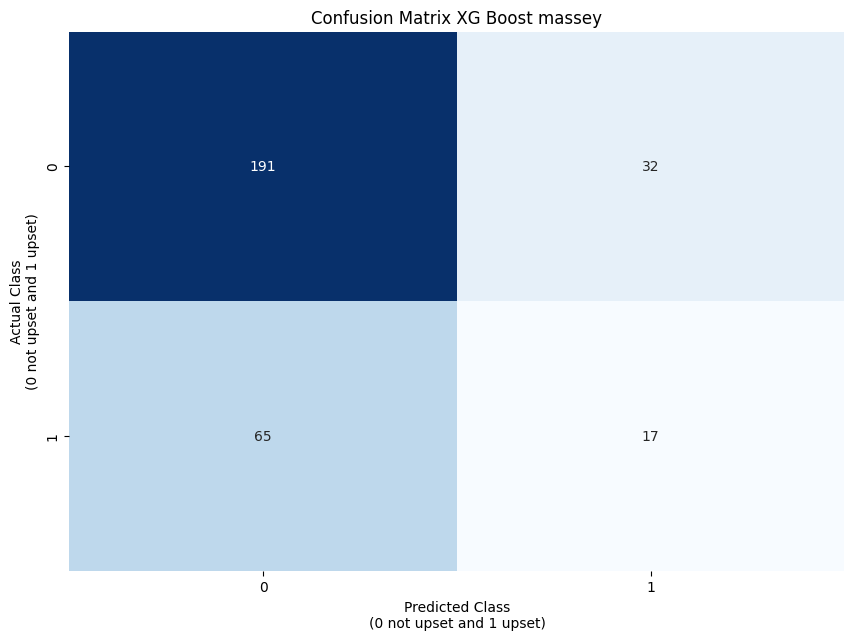

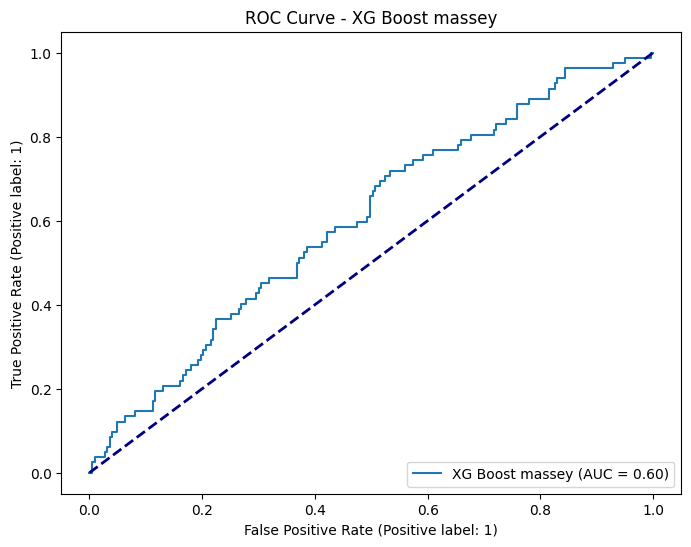

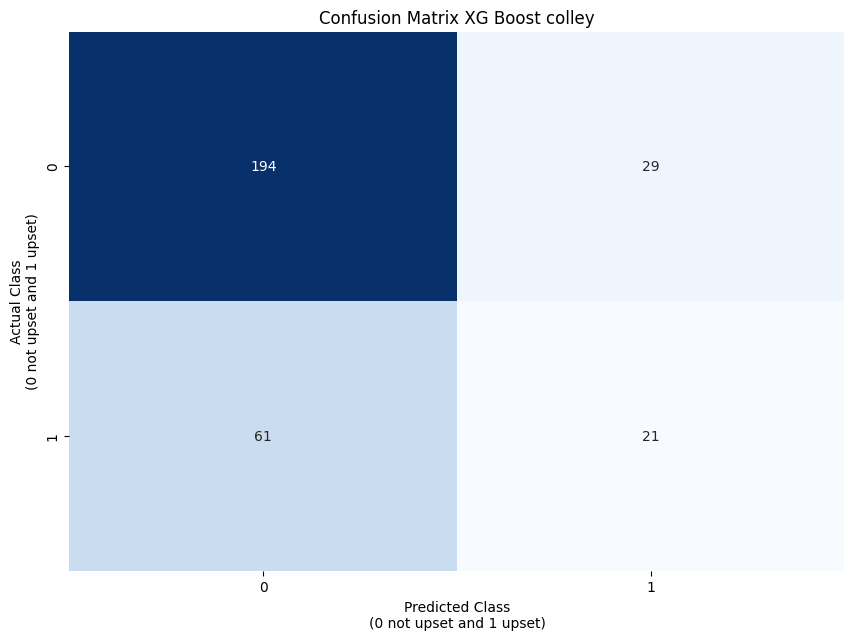

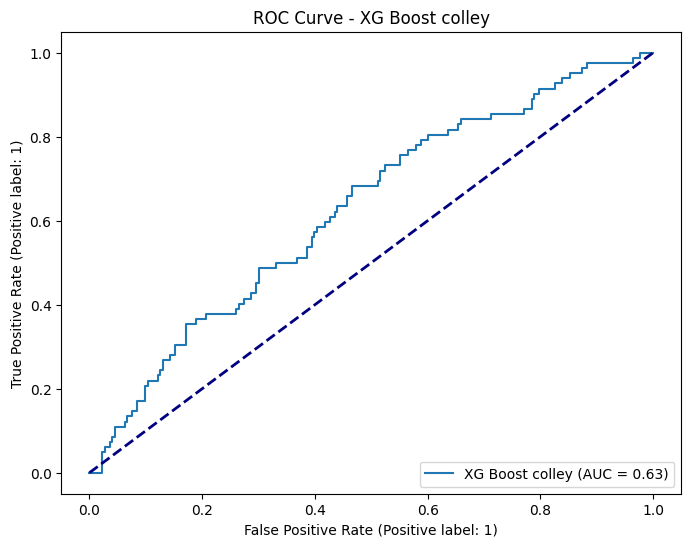

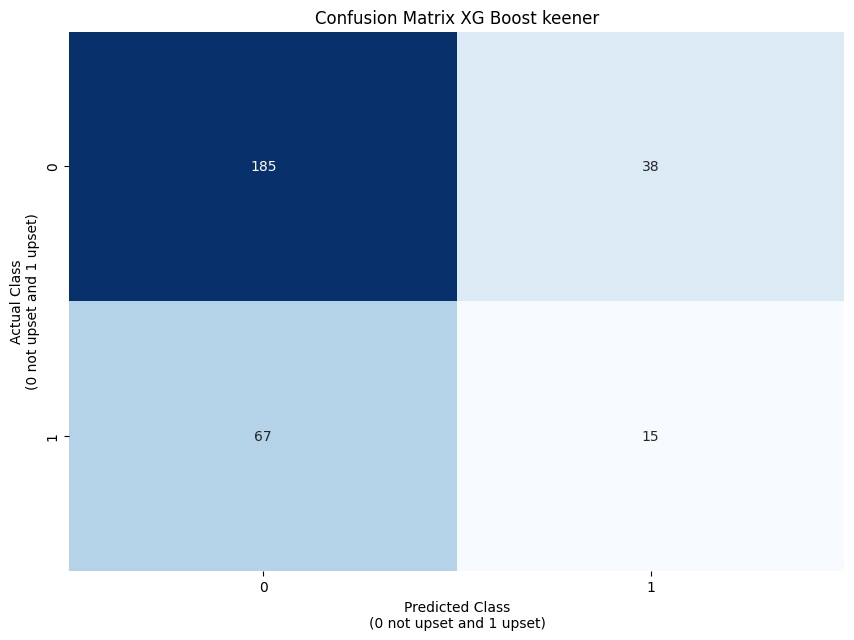

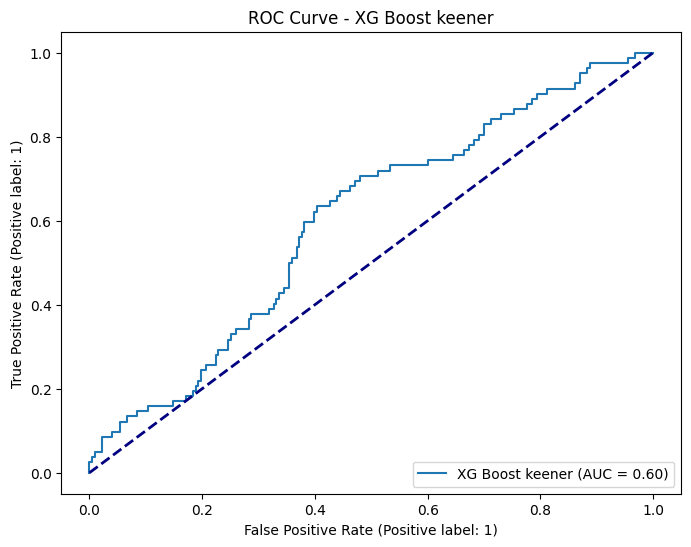

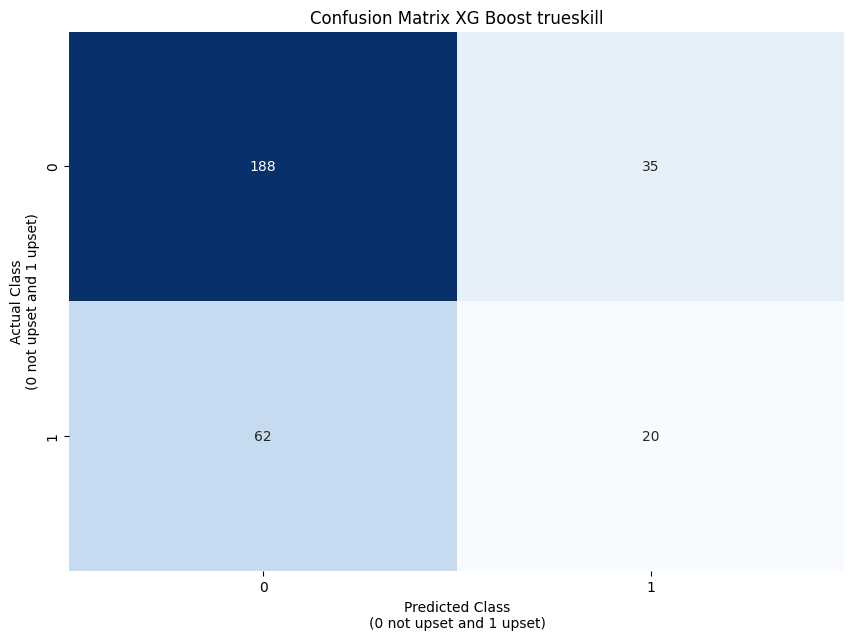

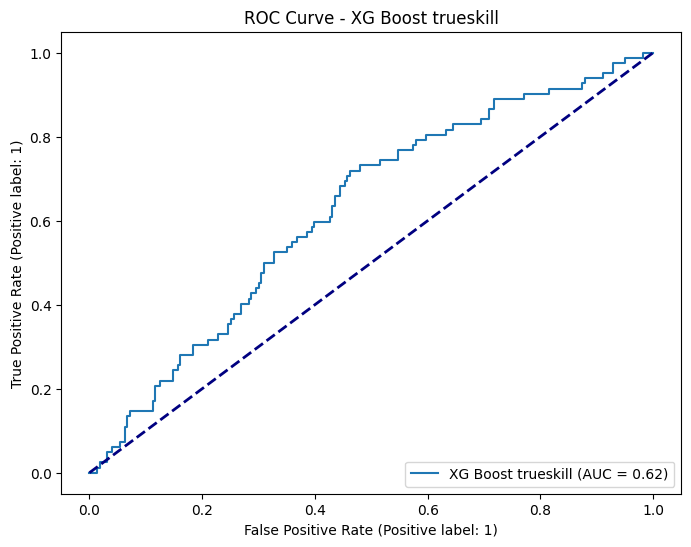

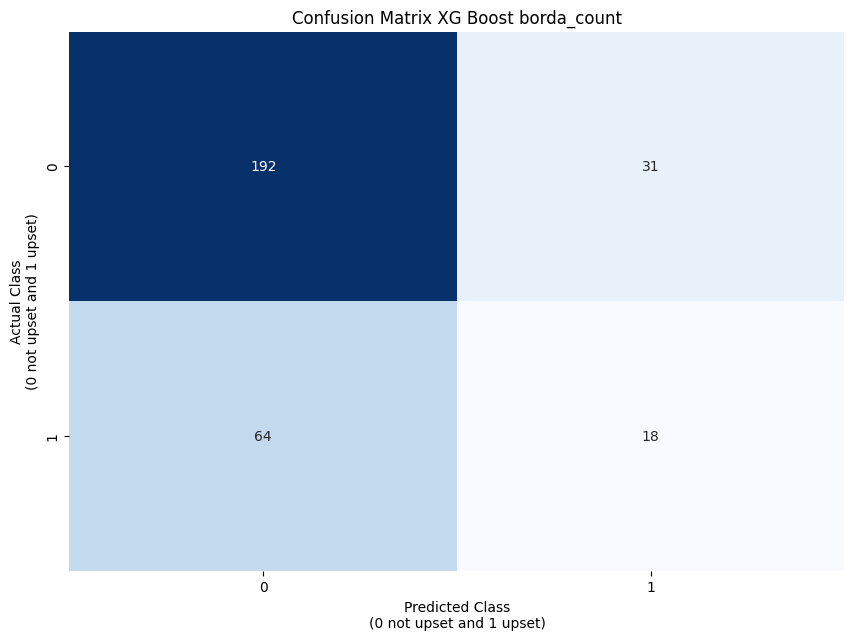

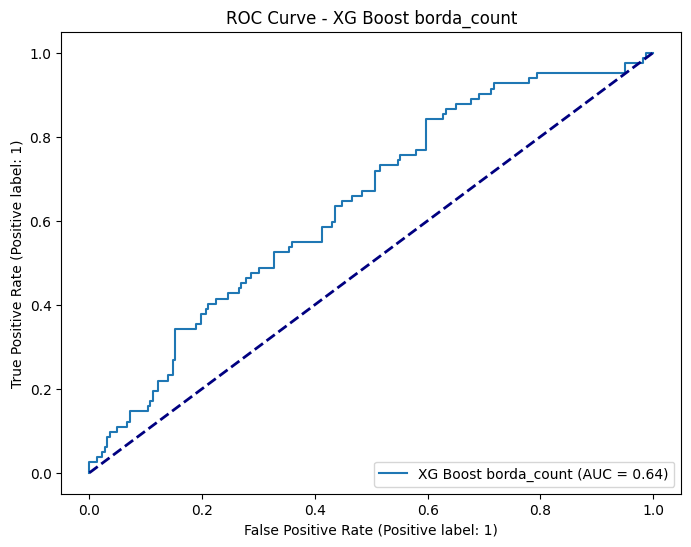

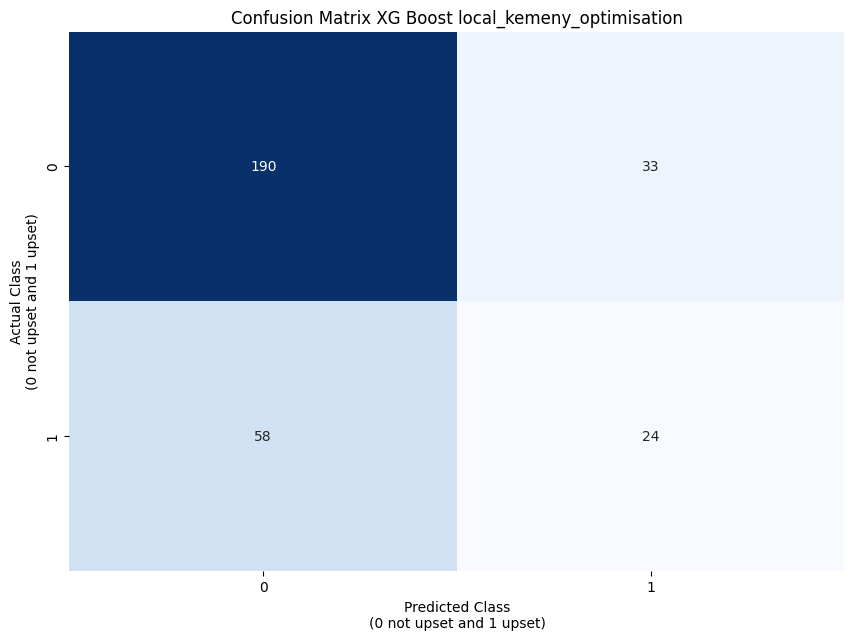

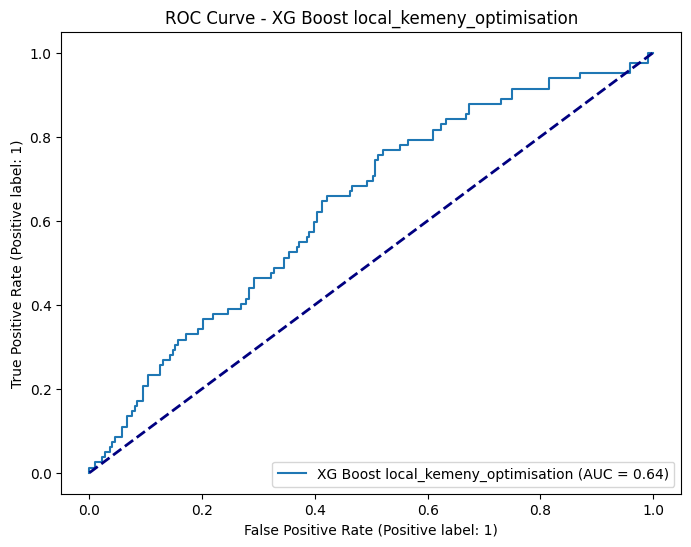

In [ ]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

XG Boost with home advantage no_ranking
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_cloudcover']
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV)

metric_id                                            metric  \
0           1              Cross-Validation Train Accuracy Mean   
1           2               Cross-Validation Standard Deviation   
2           3                    Cross-Validation Accuracy Mean   
3           4      Cross-Validation Accuracy Standard Deviation   
4           5                Cross-Validation Train Recall Mean   
5           6   Cross-Validation rain Recall Standard Deviation   
6           7                Cross-Validation  Test Recall Mean   
7           8  Cross-Validation  Test Recall Standard Deviation   
8           9                   Cross-Validation Train Log Loss   
9          10                    Cross-Validation Test Log Loss   
10         11                                  Overall Accuracy   
11         12        Confusion Matrix - True Negative (Class 0)   
12         13       Confusion Matrix - False Positive (Class 1)   
13         14       Confusion Matrix - False Negative (Class 0)   
14         15        Confusion Matrix - True Positive (Class 1)   
15         16                               Precision (Class 0)   
16         17                                  Recall (Class 0)   
17         18                                F1-score (Class 0)   
18         19                               Precision (Class 1)   
19         20                                  Recall (Class 1)   
20         21                                F1-score (Class 1)   
21         22                               Macro avg Precision   
22         23                                  Macro avg Recall   
23         24                                Macro avg F1-score   
24         25                            Weighted avg Precision   
25         26                               Weighted avg Recall   
26         27                             Weighted avg F1-score   
27         28                                           AUC-ROC   

   XG Boost with home advantage no_ranking  \
0                                    0.966   
1                                    0.017   
2                                    0.669   
3                                    0.059   
4                                    0.872   
5                                    0.061   
6                                    0.234   
7                                    0.110   
8                                    0.207   
9                                    0.664   
10                                   0.669   
11                                 185.000   
12                                  38.000   
13                                  63.000   
14                                  19.000   
15                                   0.746   
16                                   0.830   
17                                   0.786   
18                                   0.333   
19                                   0.232   
20                                   0.273   
21                                   0.540   
22                                   0.531   
23                                   0.529   
24                                   0.635   
25                                   0.669   
26                                   0.648   
27                                   0.606   

   XG Boost with home advantage round_3_position  \
0                                          0.928   
1                                          0.098   
2                                          0.705   
3                                          0.023   
4                                          0.730   
5                                          0.367   
6                                          0.198   
7                                          0.145   
8                                          0.243   
9                                          0.619   
10                                         0.705   
11                                       199.000   
12                                        24.000 

Model Name Ranking  Fold  \
0             XG Boost with home advantage no_ranking     1   
1             XG Boost with home advantage no_ranking     2   
2             XG Boost with home advantage no_ranking     3   
3             XG Boost with home advantage no_ranking     4   
4             XG Boost with home advantage no_ranking     5   
5       XG Boost with home advantage round_3_position     1   
6       XG Boost with home advantage round_3_position     2   
7       XG Boost with home advantage round_3_position     3   
8       XG Boost with home advantage round_3_position     4   
9       XG Boost with home advantage round_3_position     5   
10                XG Boost with home advantage massey     1   
11                XG Boost with home advantage massey     2   
12                XG Boost with home advantage massey     3   
13                XG Boost with home advantage massey     4   
14                XG Boost with home advantage massey     5   
15                XG Boost with home advantage colley     1   
16                XG Boost with home advantage colley     2   
17                XG Boost with home advantage colley     3   
18                XG Boost with home advantage colley     4   
19                XG Boost with home advantage colley     5   
20                XG Boost with home advantage keener     1   
21                XG Boost with home advantage keener     2   
22                XG Boost with home advantage keener     3   
23                XG Boost with home advantage keener     4   
24                XG Boost with home advantage keener     5   
25             XG Boost with home advantage trueskill     1   
26             XG Boost with home advantage trueskill     2   
27             XG Boost with home advantage trueskill     3   
28             XG Boost with home advantage trueskill     4   
29             XG Boost with home advantage trueskill     5   
30           XG Boost with home advantage borda_count     1   
31           XG Boost with home advantage borda_count     2   
32           XG Boost with home advantage borda_count     3   
33           XG Boost with home advantage borda_count     4   
34           XG Boost with home advantage borda_count     5   
35  XG Boost with home advantage local_kemeny_opti...     1   
36  XG Boost with home advantage local_kemeny_opti...     2   
37  XG Boost with home advantage local_kemeny_opti...     3   
38  XG Boost with home advantage local_kemeny_opti...     4   
39  XG Boost with home advantage local_kemeny_opti...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__colsample_bytree': 0.6, 'classif...   
1   {'classifier__colsample_bytree': 0.6, 'classif...   
2   {'classifier__colsample_bytree': 0.6, 'classif...   
3   {'classifier__colsample_bytree': 0.6, 'classif...   
4   {'classifier__colsample_bytree': 0.6, 'classif...   
5   {'classifier__colsample_bytree': 1.0, 'classif...   
6   {'classifier__colsample_bytree': 1.0, 'classif...   
7   {'classifier__colsample_bytree': 0.6, 'classif...   
8   {'classifier__colsample_bytree': 0.6, 'classif...   
9   {'classifier__colsample_bytree': 0.6, 'classif...   
10  {'classifier__colsample_bytree': 1.0, 'classif...   
11  {'classifier__colsample_bytree': 0.6, 'classif...   
12  {'classifier__colsample_bytree': 1.0, 'classif...   
13  {'classifier__colsample_bytree': 1.0, 'classif...   
14  {'classifier__colsample_bytree': 0.6, 'classif...   
15  {'classifier__colsample_bytree': 1.0, 'classif...   
16  {'classifier__colsample_bytree': 0.6, 'classif...   
17  {'classifier__colsample_bytree': 1.0, 'classif...   
18  {'classifier__colsample_bytree': 1.0, 'classif...   
19  {'classifier__colsample_bytree': 0.6, 'classif...   
20  {'classifier__colsample_bytree': 0.6, 'classif...   
21  {'classifier__colsample_bytree': 0.6, 'classif...   
22  {'classifier__colsample_bytree': 1.0, 'classif...   
23  {'classifier__colsample_bytree': 0.6, 'classif...   
24  {'classifier__colsampl

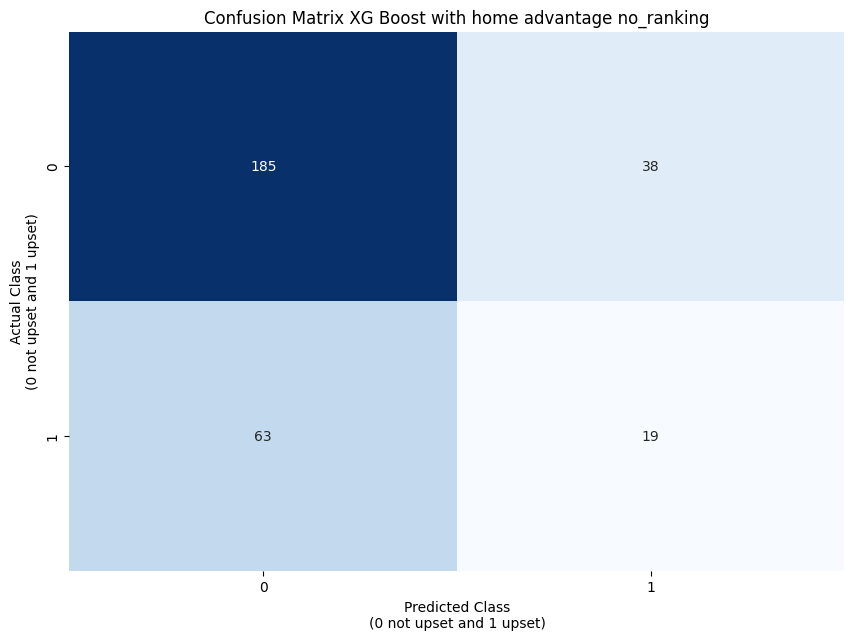

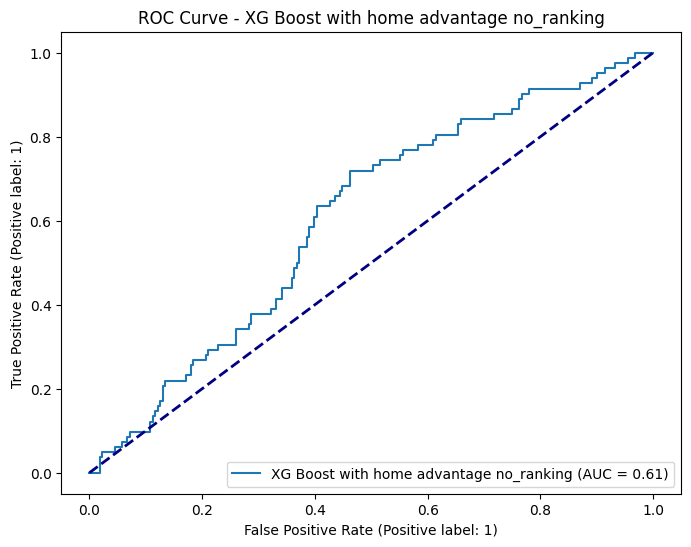

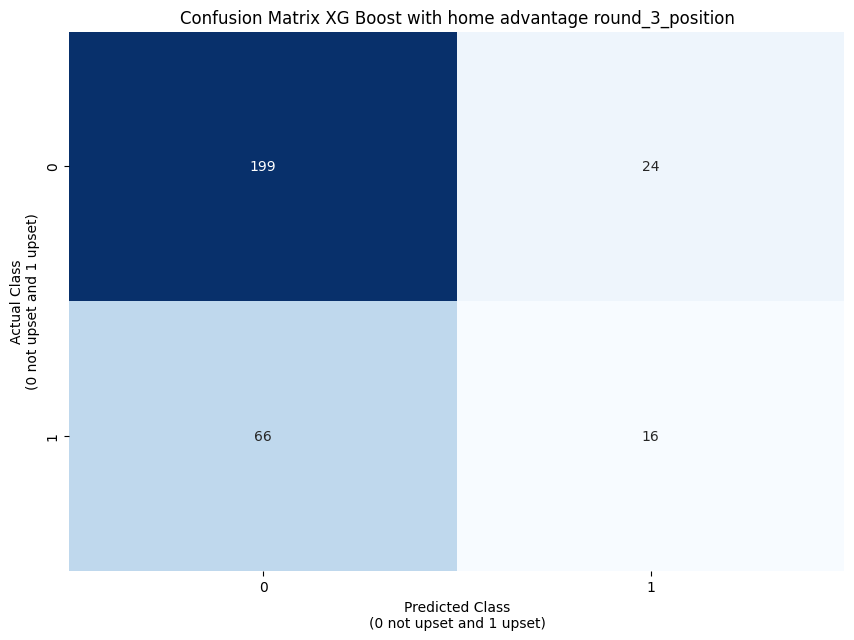

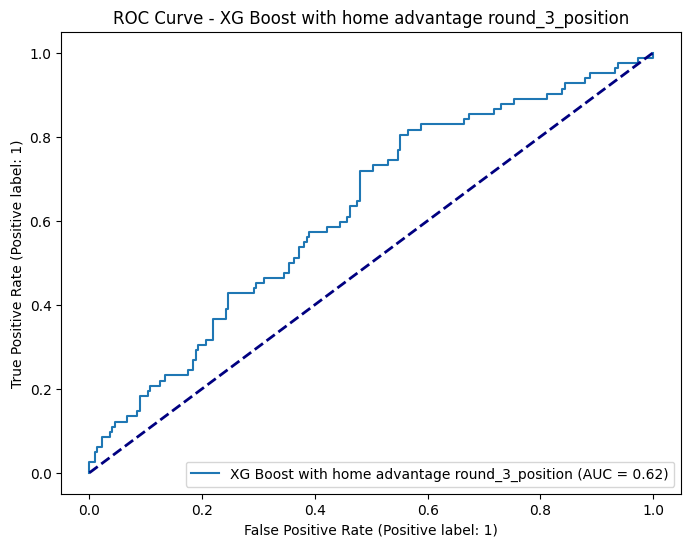

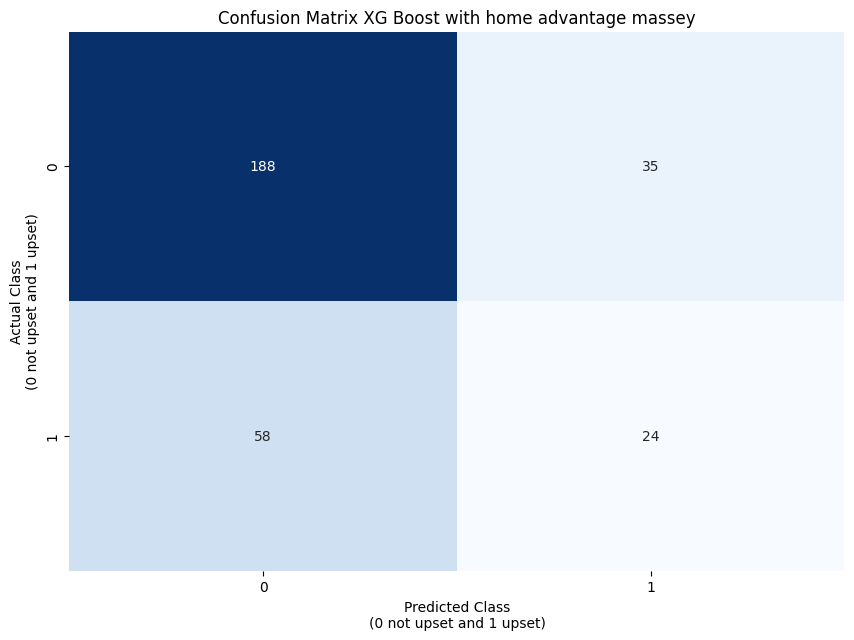

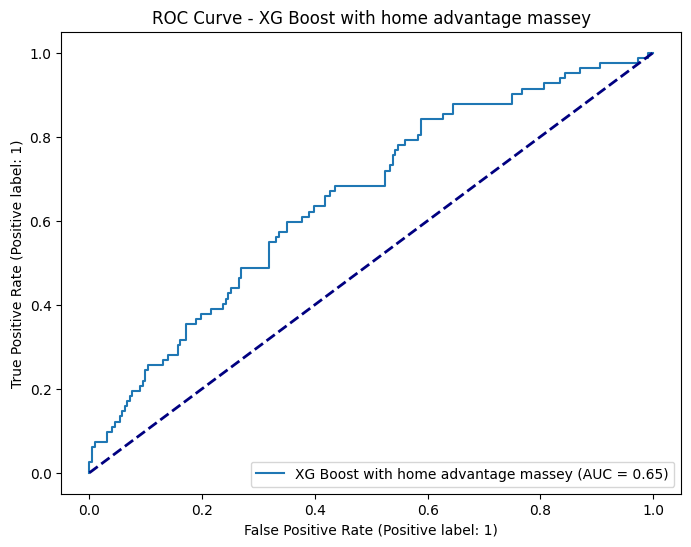

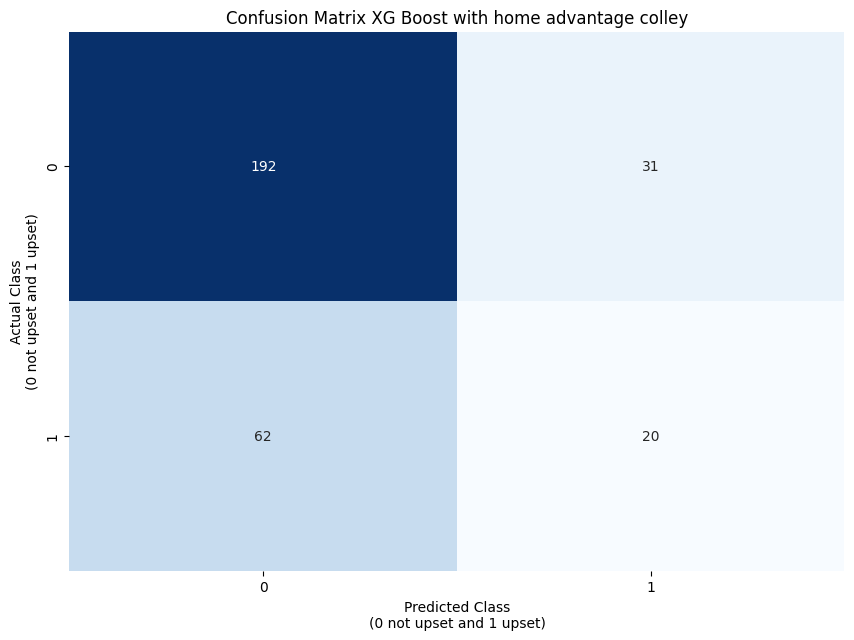

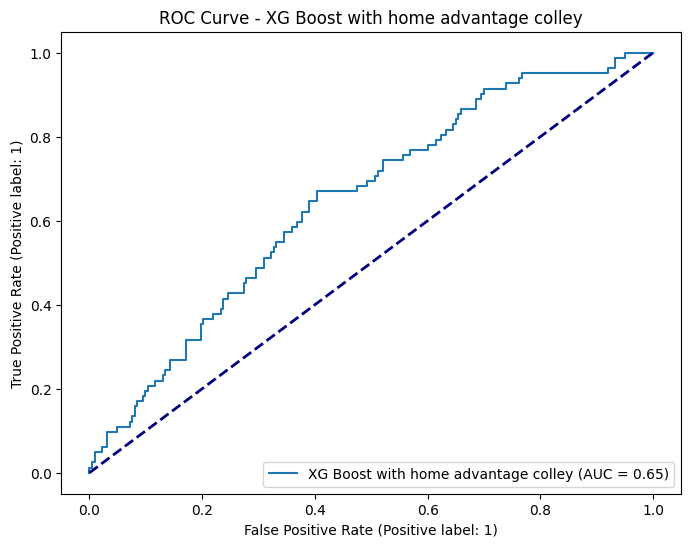

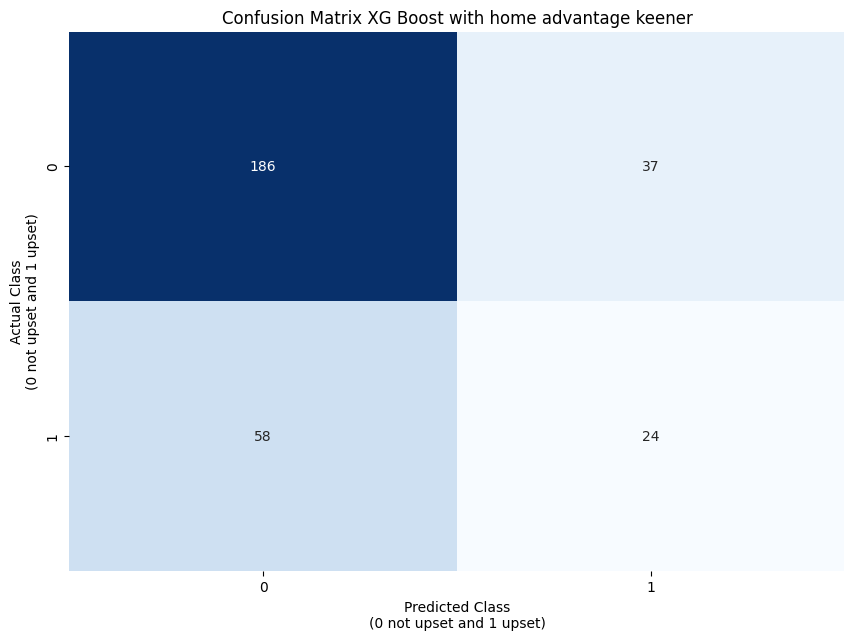

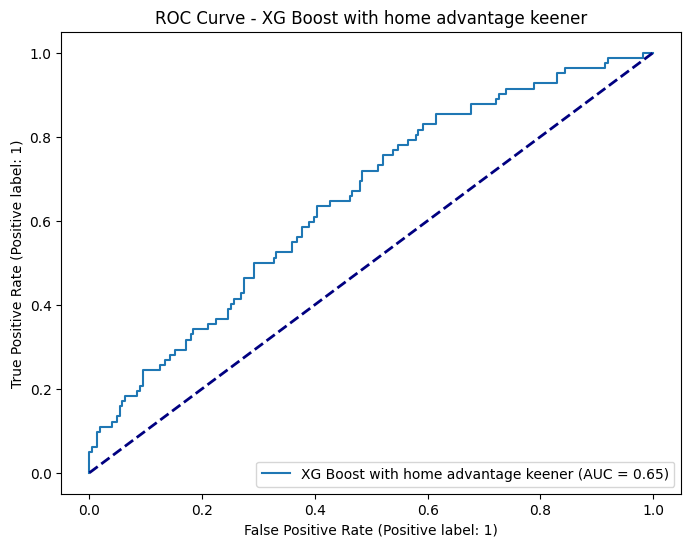

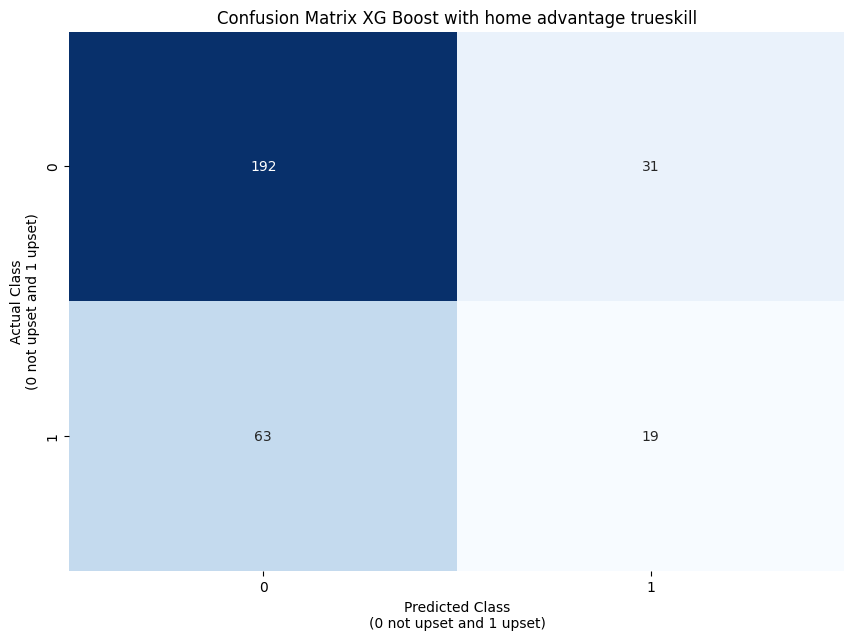

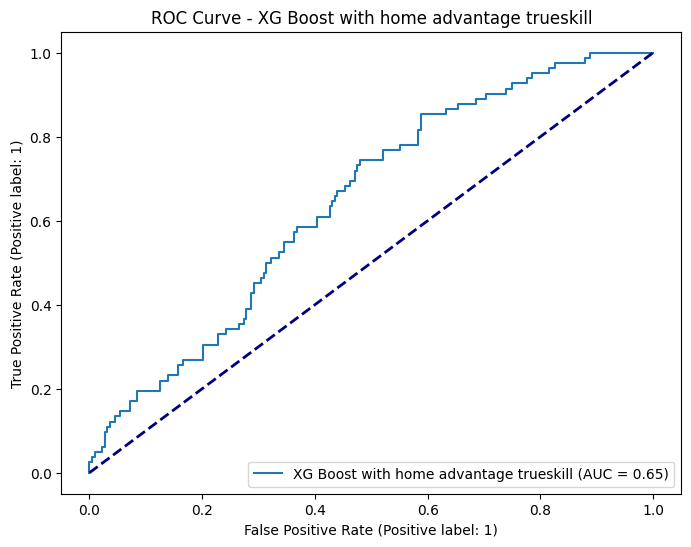

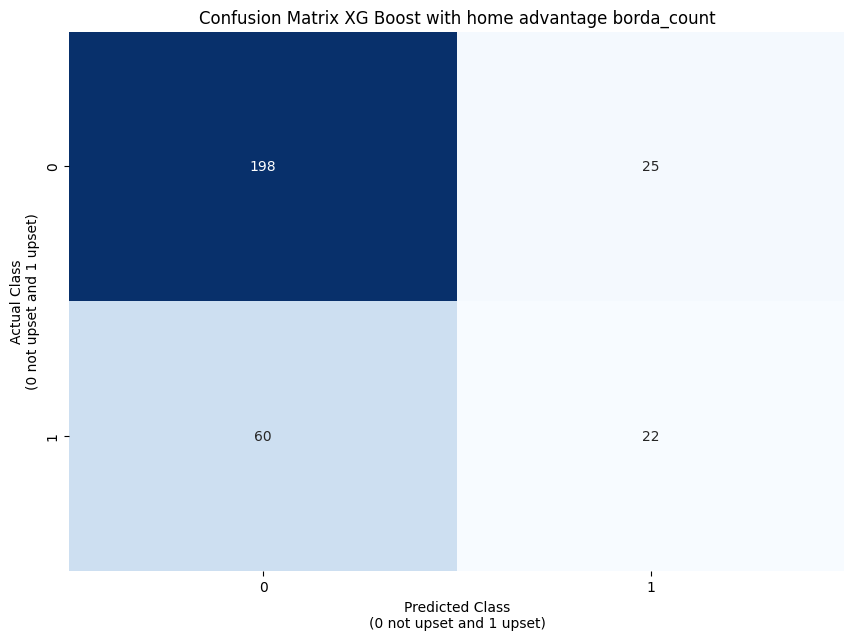

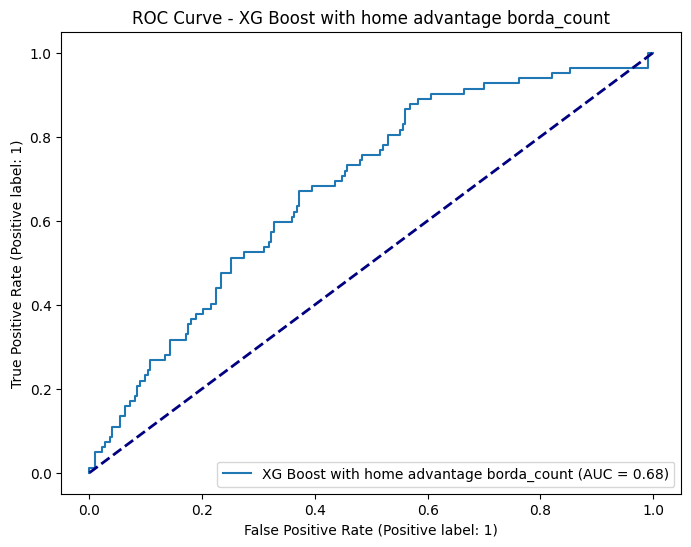

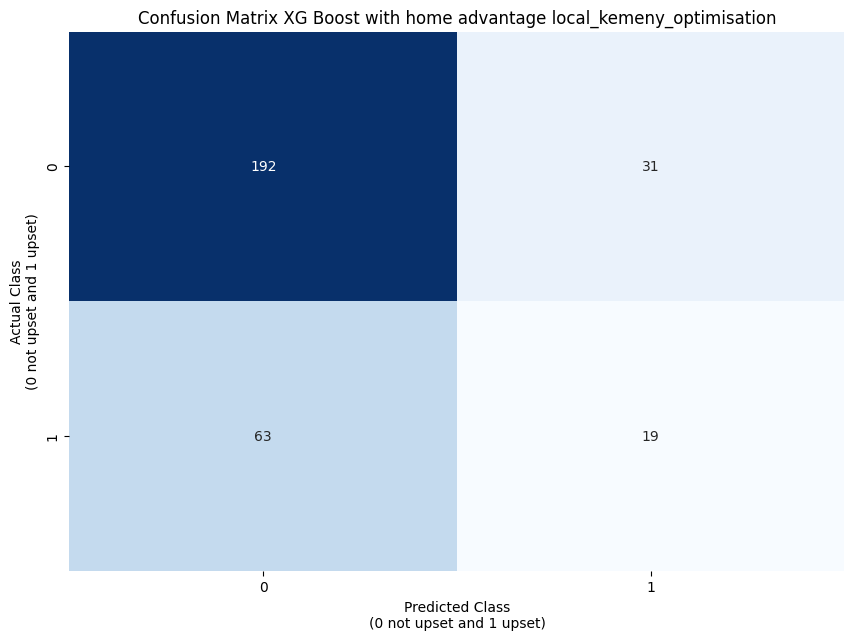

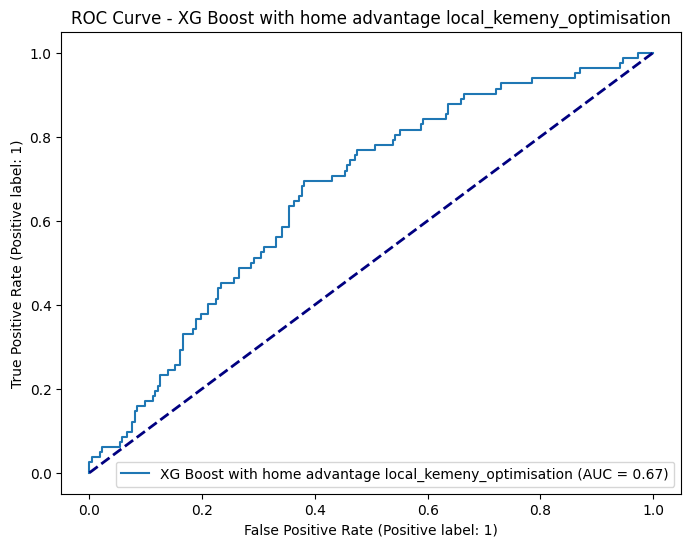

In [ ]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [1]:
all_results_df = all_results_df_xg.merge(all_results_df_xgh, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')

all_results_df = all_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(all_results_df)
all_results_df.to_excel("ml_model_confusion_matrix_results.xlsx")

# Load data from Excel to Google BigQuery
all_results_from_excel = pd.read_excel("all_results.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(all_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


NameError: name 'all_results_df' is not defined

In [ ]:
# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Load updated Fold results to Google Big Query
# Merge fold results from each model
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlr, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
fold_results_df = fold_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(fold_results_df)

# Write to Excel
fold_results_df.to_excel("ml_model_fold_results.xlsx")

# Load fold results data from Excel to Google BigQuery
fold_results_from_excel = pd.read_excel("ml_model_fold_results.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(fold_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


model_name_ranking  fold  \
0              Standard LogisticRegression no_ranking     1   
1              Standard LogisticRegression no_ranking     2   
2              Standard LogisticRegression no_ranking     3   
3              Standard LogisticRegression no_ranking     4   
4              Standard LogisticRegression no_ranking     5   
..                                                ...   ...   
35  XG Boost with home advantage local_kemeny_opti...     1   
36  XG Boost with home advantage local_kemeny_opti...     2   
37  XG Boost with home advantage local_kemeny_opti...     3   
38  XG Boost with home advantage local_kemeny_opti...     4   
39  XG Boost with home advantage local_kemeny_opti...     5   

                         best_parameters_gridsearchcv  \
0   {'classifier__C': 100.0, 'classifier__penalty'...   
1   {'classifier__C': 1000.0, 'classifier__penalty...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 1000.0, 'classifier__penalty...   
..                                                ...   
35  {'classifier__colsample_bytree': 0.6, 'classif...   
36  {'classifier__colsample_bytree': 1.0, 'classif...   
37  {'classifier__colsample_bytree': 0.6, 'classif...   
38  {'classifier__colsample_bytree': 0.6, 'classif...   
39  {'classifier__colsample_bytree': 1.0, 'classif...   

    best_recall_gridsearchcv  train_accuracy  train_recall  test_accuracy  \
0                   0.227273        0.778689      0.318182       0.721311   
1                   0.272727        0.782787      0.348485       0.672131   
2                   0.303030        0.762295      0.272727       0.655738   
3                   0.320346        0.770492      0.276923       0.639344   
4                   0.321789        0.758197      0.292308       0.721311   
..                       ...             ...           ...            ...   
35                  0.348485        0.959016      0.848485       0.688525   
36                  0.393939        0.991803      0.984848       0.688525   
37                  0.393939        0.967213      0.878788       0.721311   
38                  0.445166        0.987705      0.953846       0.655738   
39                  0.495671        1.000000      1.000000       0.704918   

    test_recall  
0      0.187500  
1      0.250000  
2      0.250000  
3      0.058824  
4      0.117647  
..          ...  
35     0.187500  
36     0.375000  
37     0.375000  
38     0.117647  
39     0.117647  

[400 rows x 8 columns]

100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_fold_results
